In [1]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, graph, serial
import glob
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

import os

# Listing current data on our folder.
def getStreams(filepath):
    streams = []
    for file in glob.glob(filepath + "/*.mid"):
        midi = converter.parse(file)
        streams.append(midi)
    return streams

def getNotes(midi):
    notes = []
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            # normalOrder is always a list of intergers
            notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes

In [2]:
print("Starting to read files...")
classics = getStreams("midi_classic")
print("Done with classic")
LSTMSongs = getStreams("LSTM_Generated/LSTM_ARGMAX")
print("Done with LSTM")
RBMSongs = getStreams("RBM_Generated/RBM_Sklearn_15")
print("Files read")

Starting to read files...
Done with classic
Done with LSTM
Files read


### Comparando usando Pitch class histogram (PCH) 

Usando como exemplo uma música gerada pela LTSM e comparando com as músicas do dataset de treino, podemos verificar que temos algumas gráficos com comportamentos semelhantes.

C:\Users\hugofac.TECGRAF\Anaconda3\envs\ts-gpu\lib\site-packages\music21\graph\primitives.py:478: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.figure = plt.figure(facecolor=self.colorBackgroundFigure)


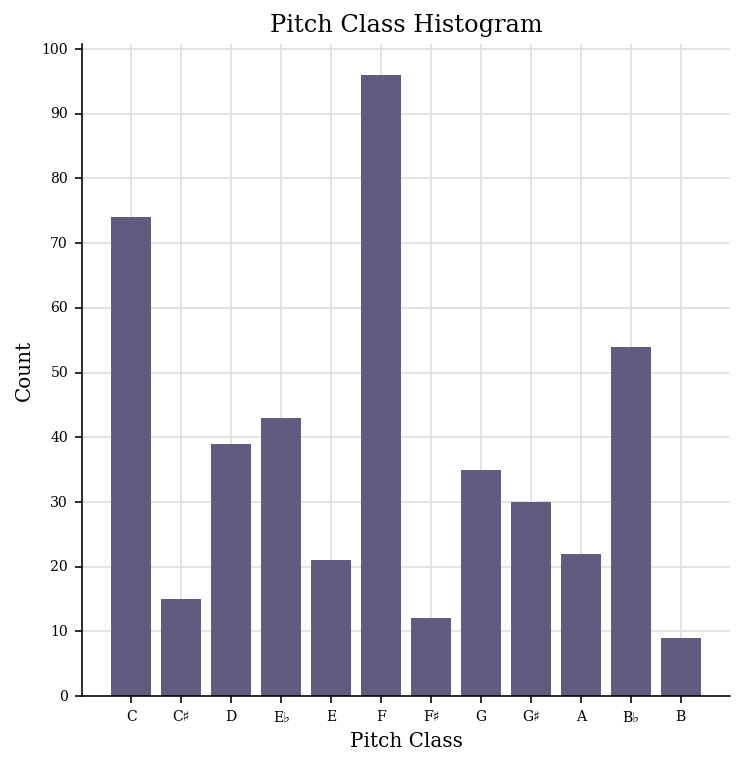

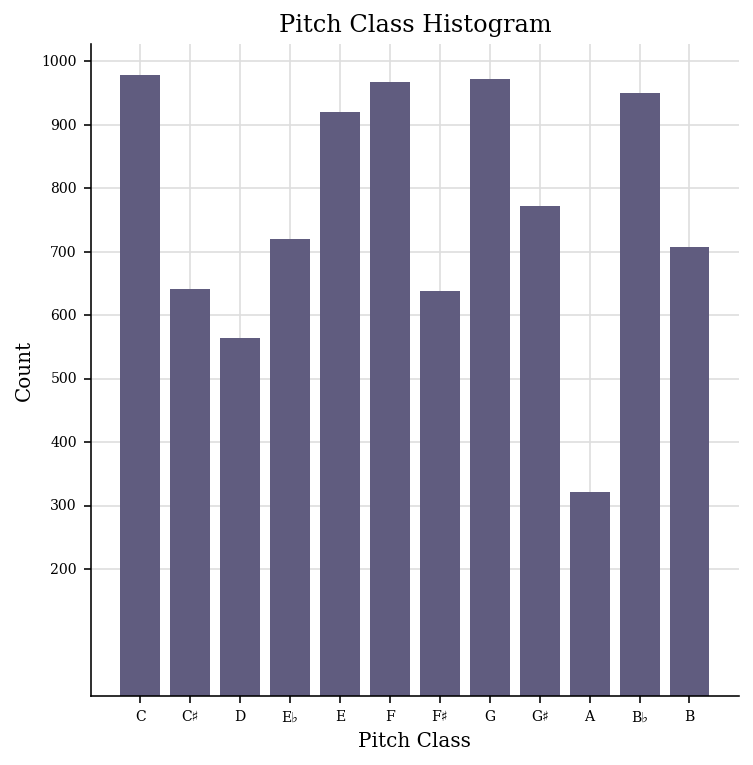

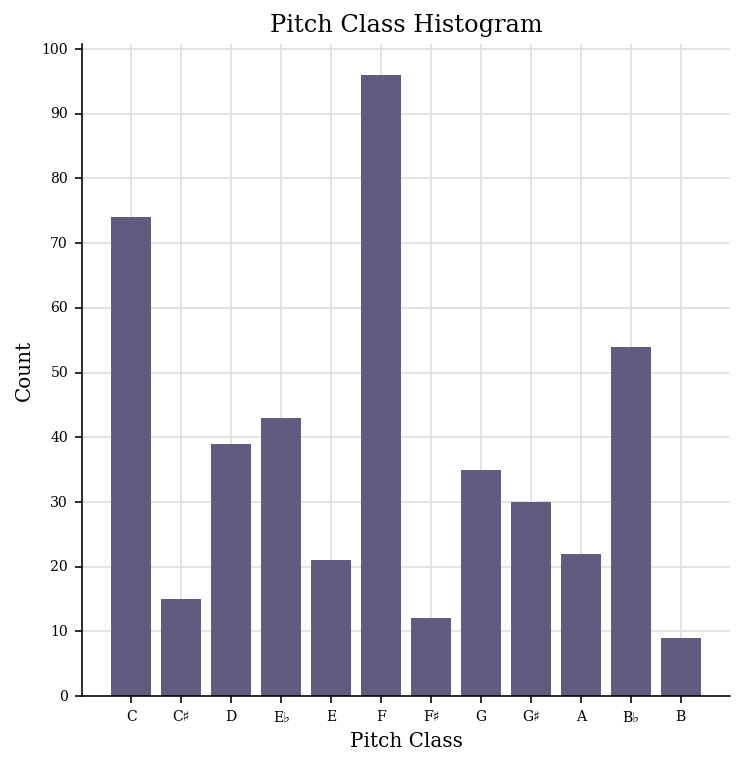

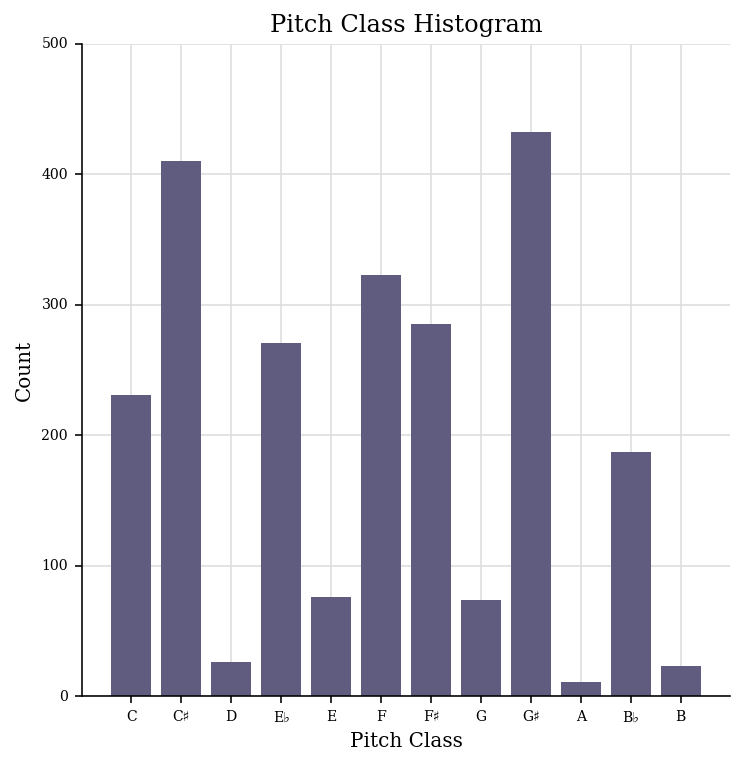

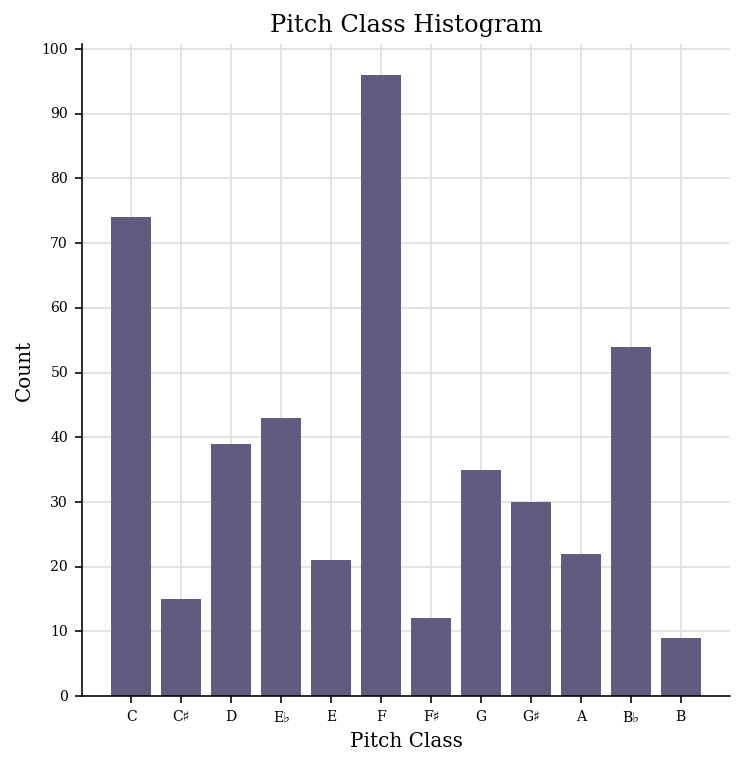

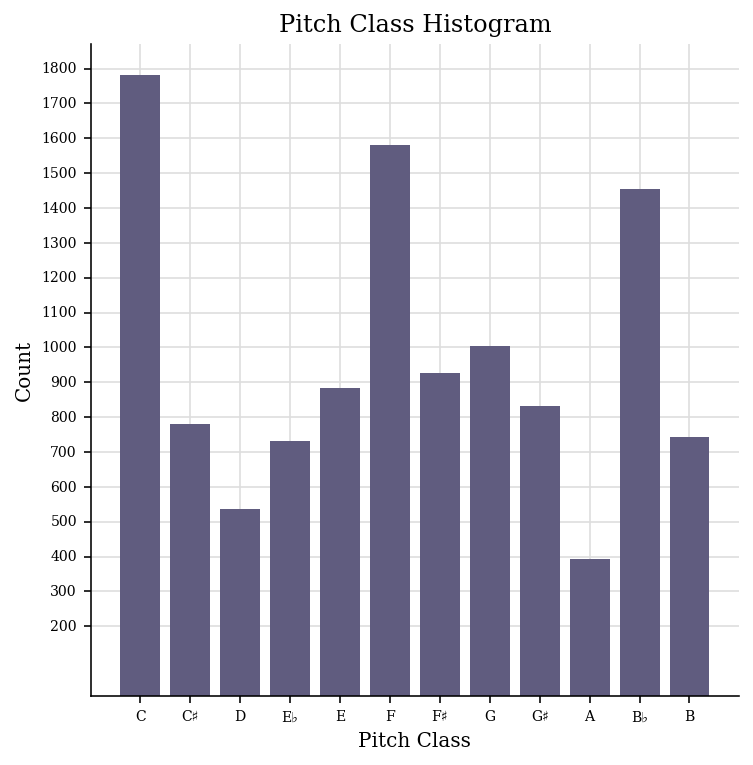

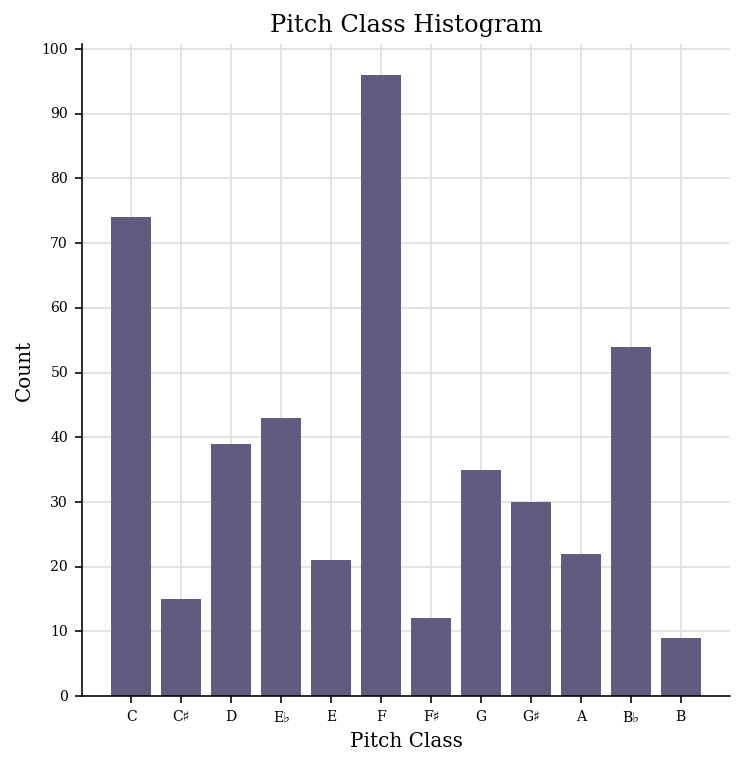

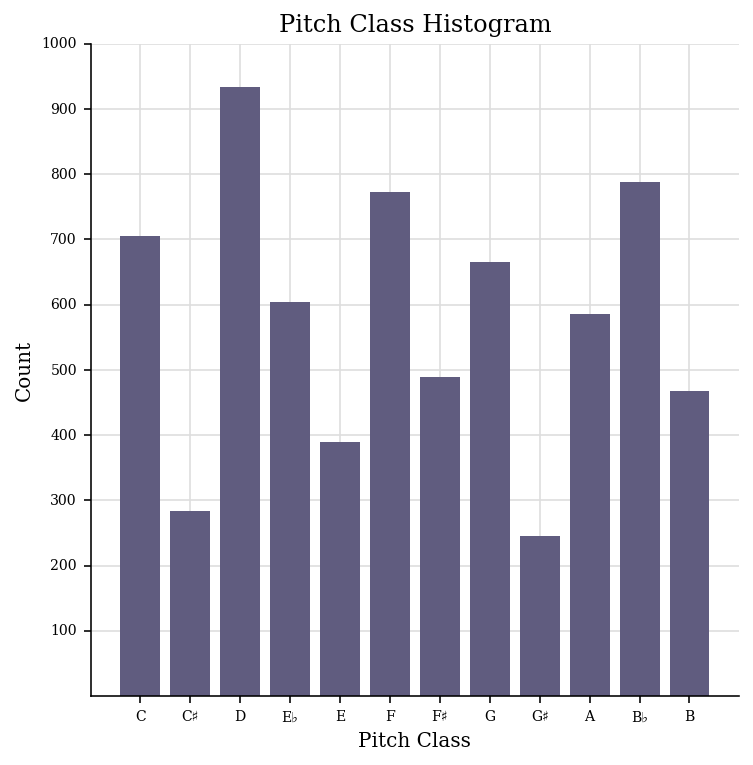

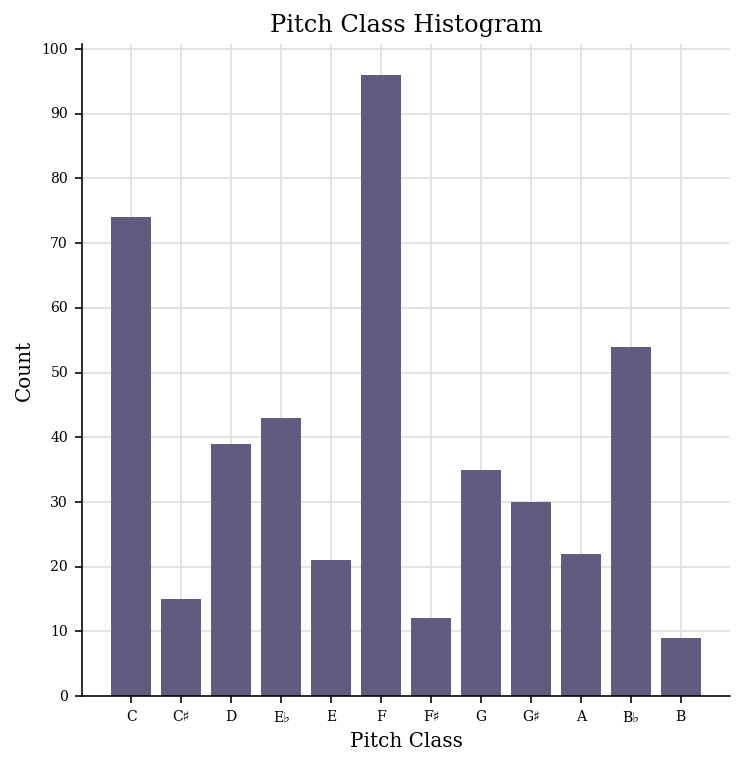

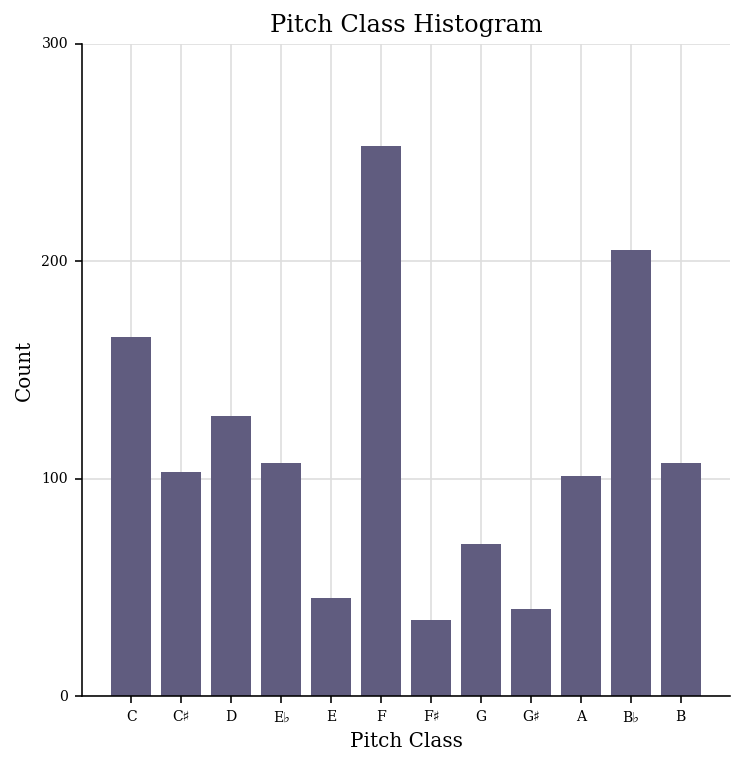

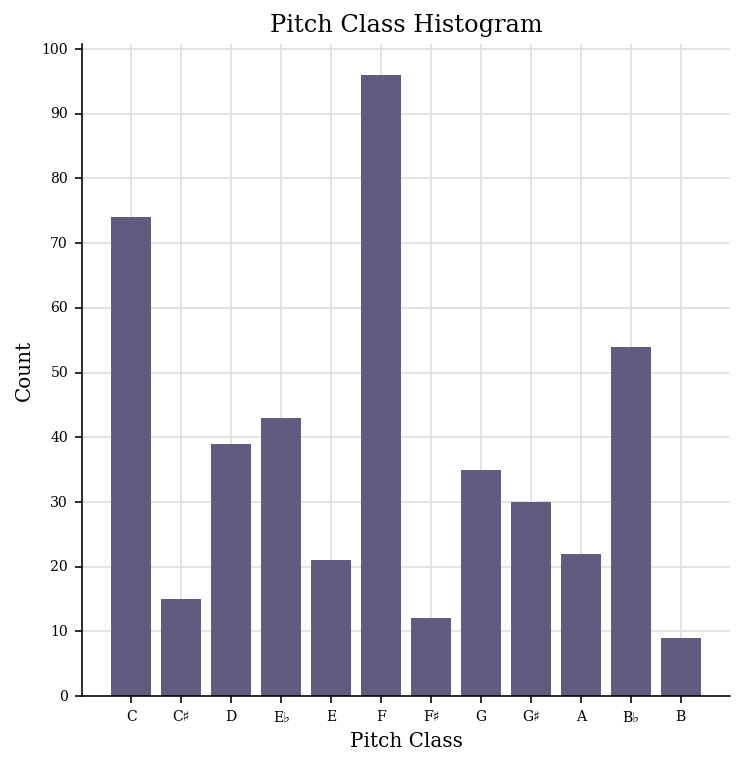

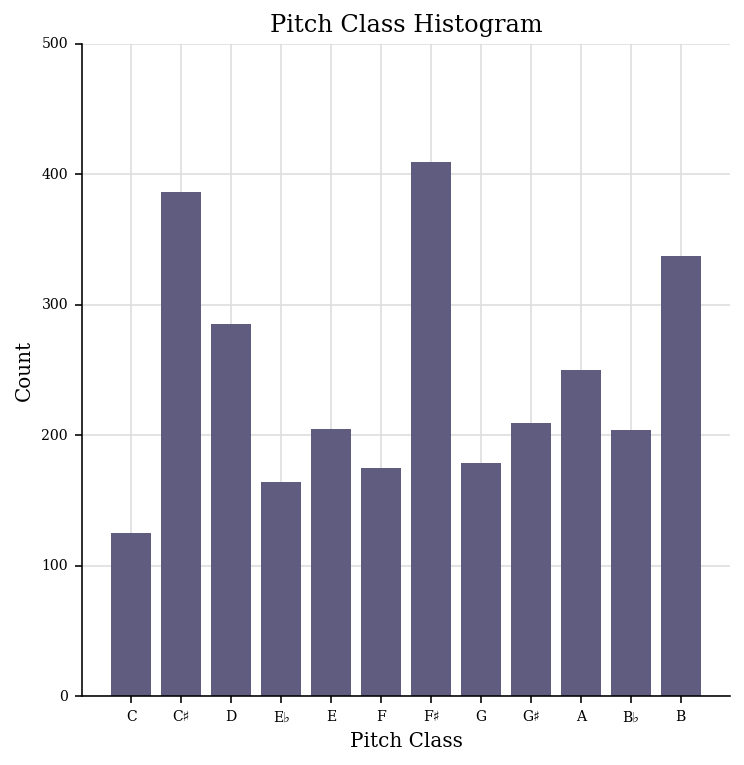

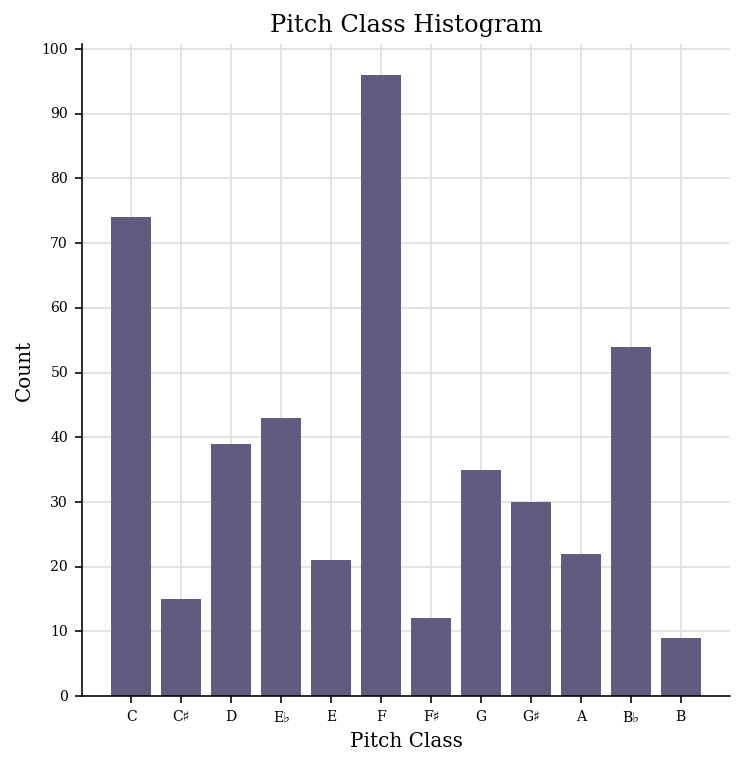

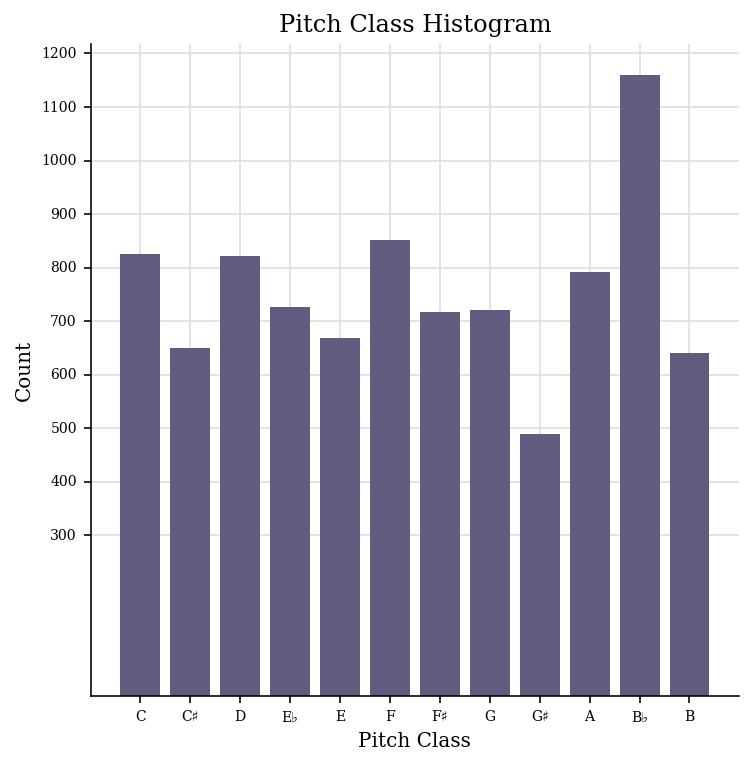

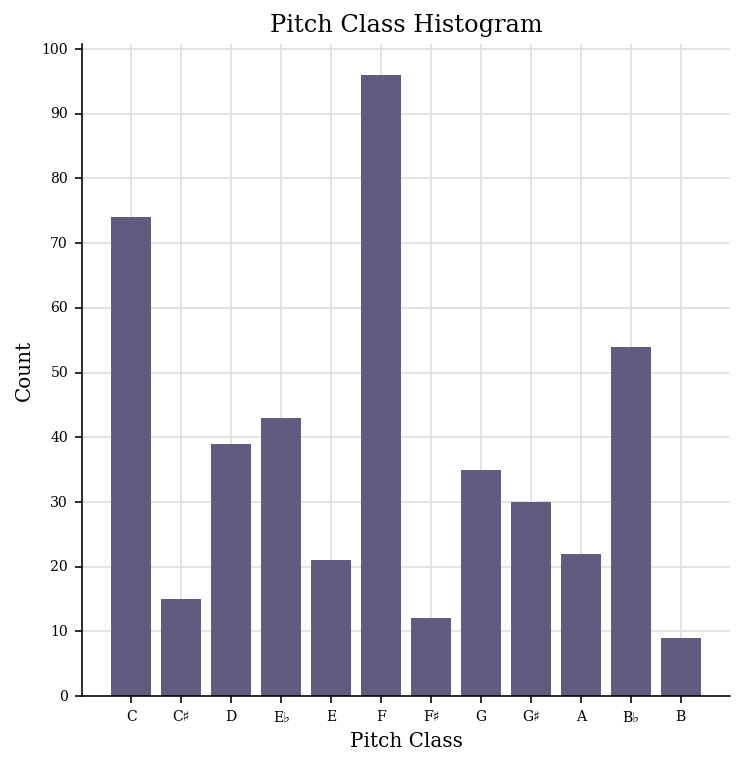

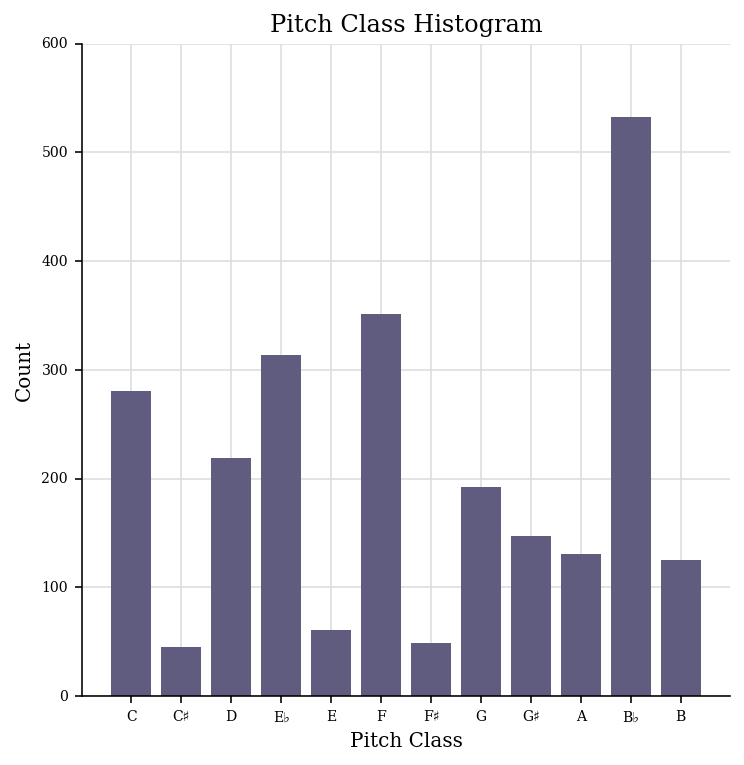

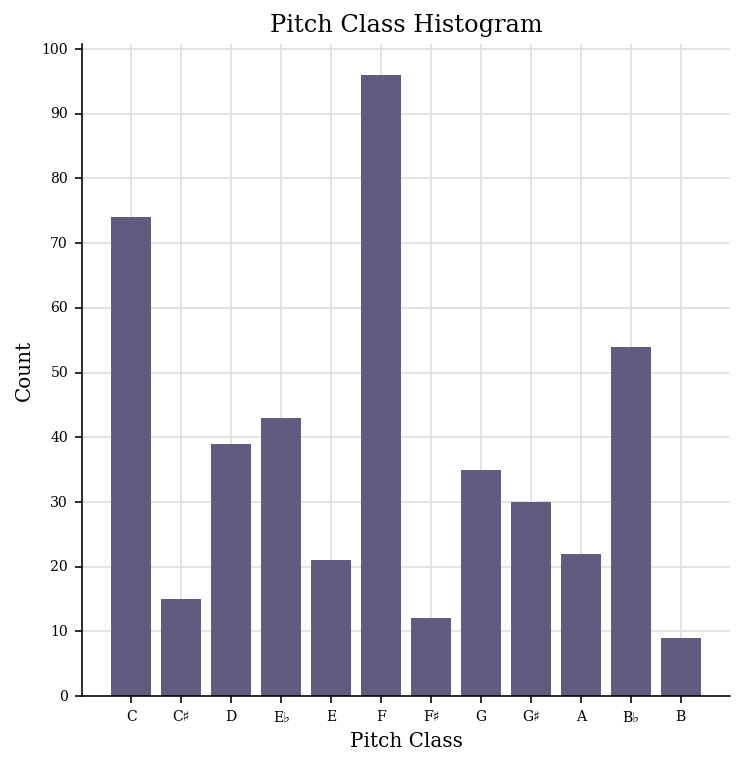

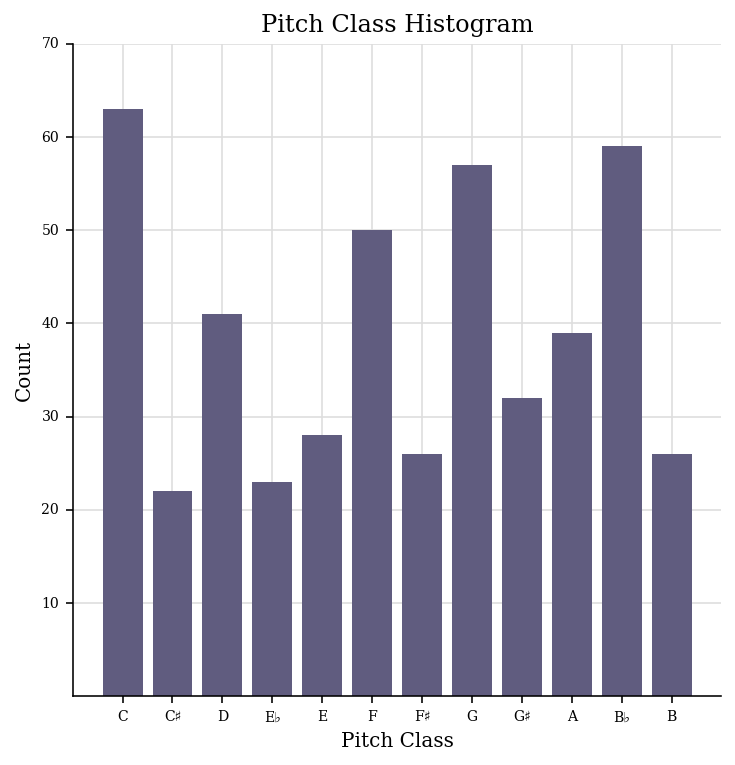

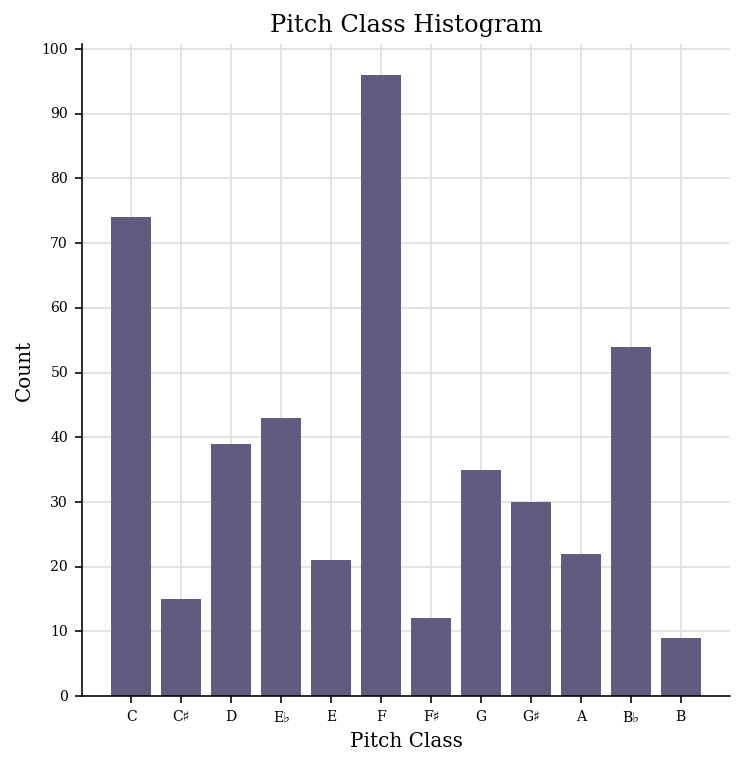

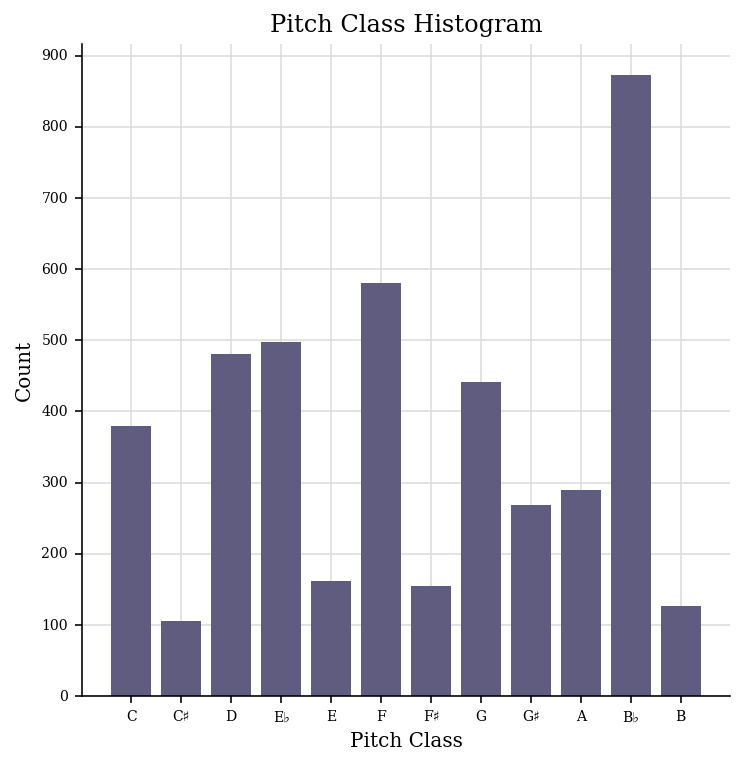

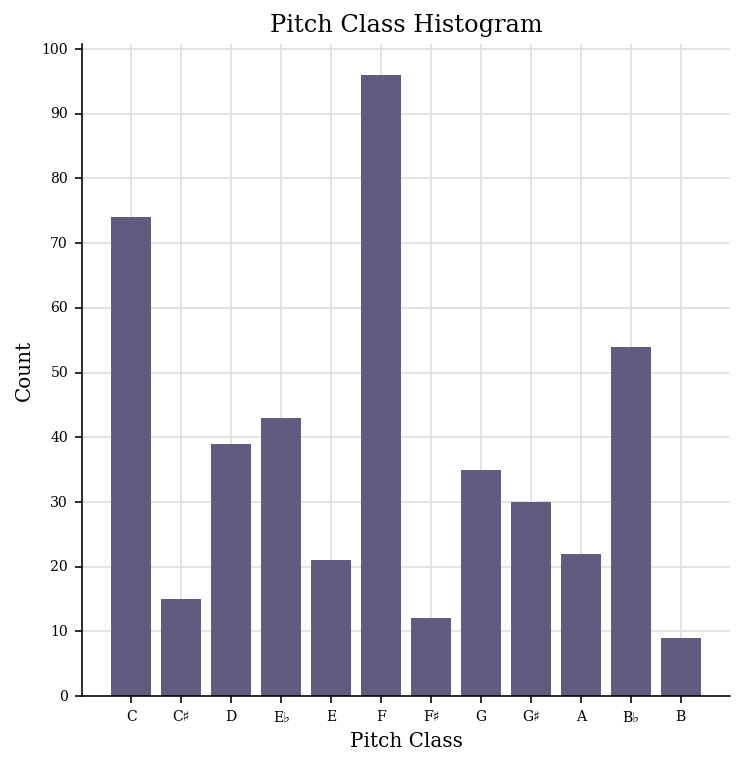

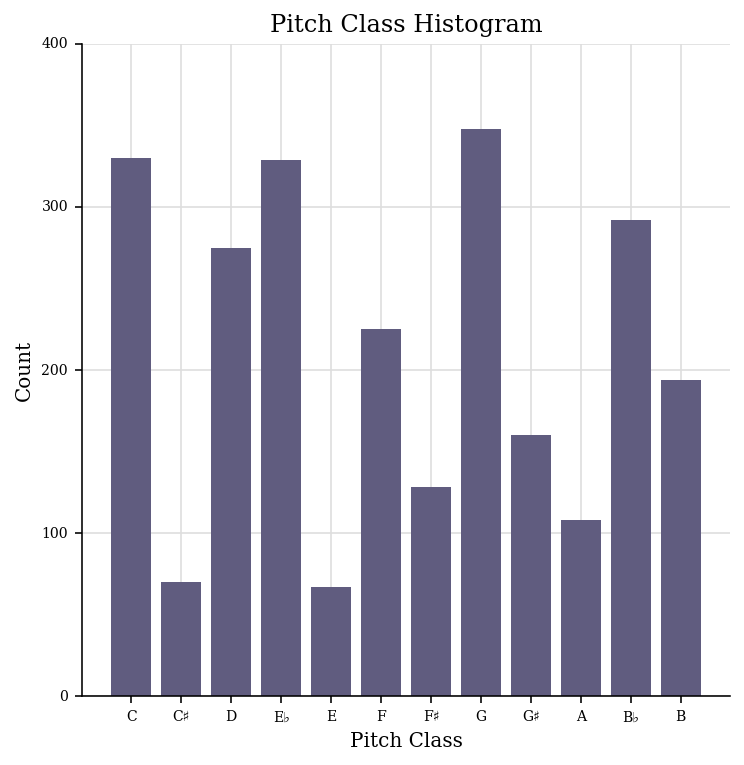

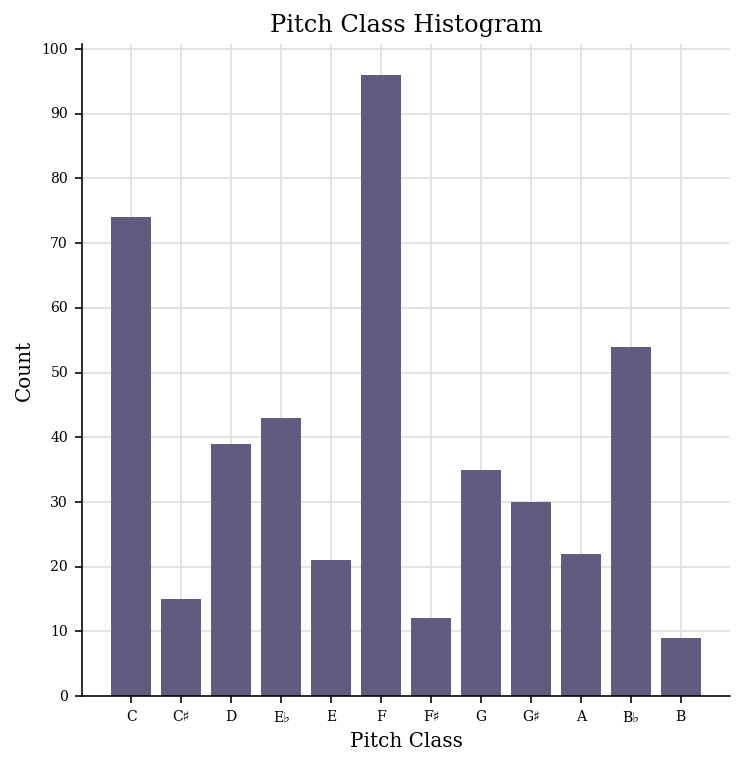

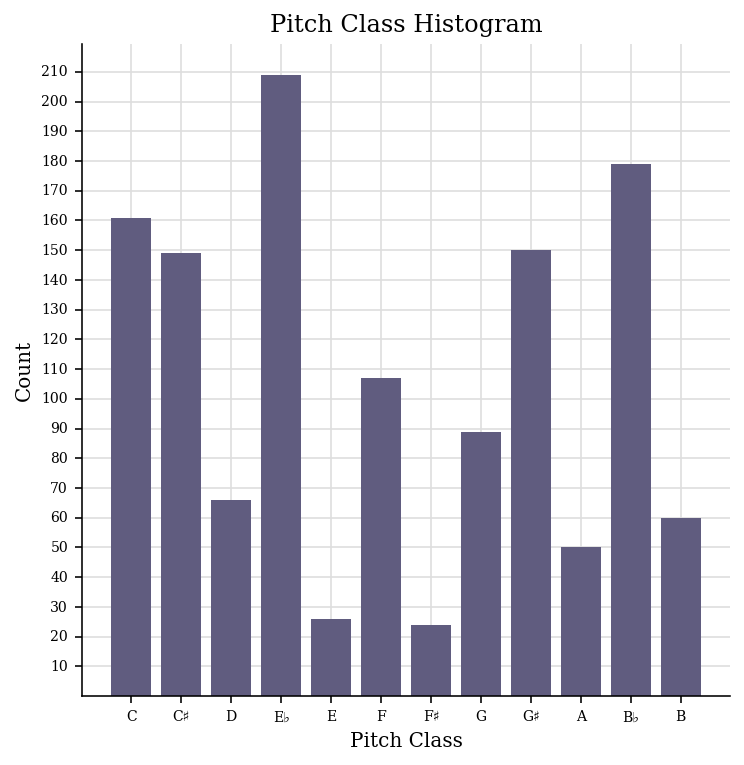

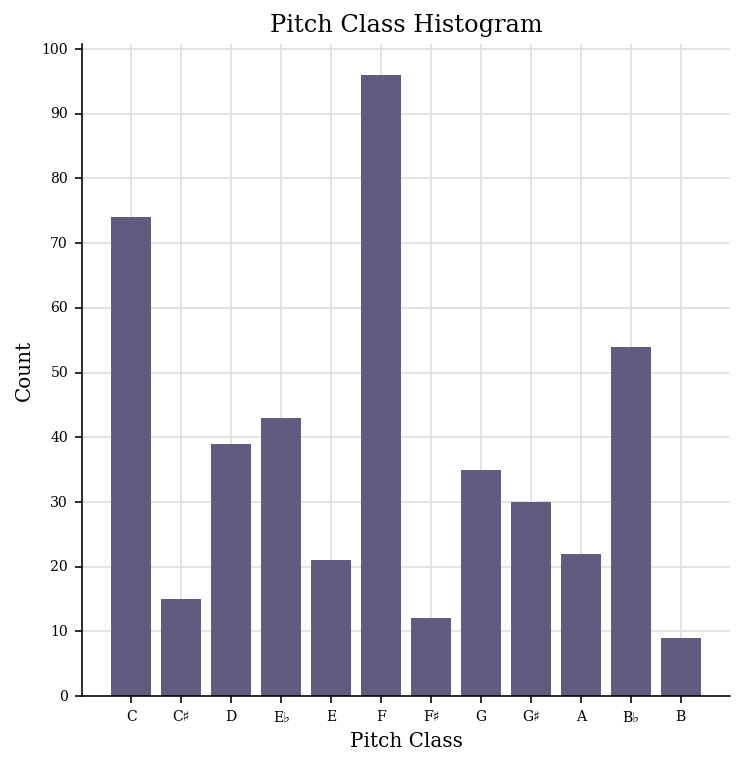

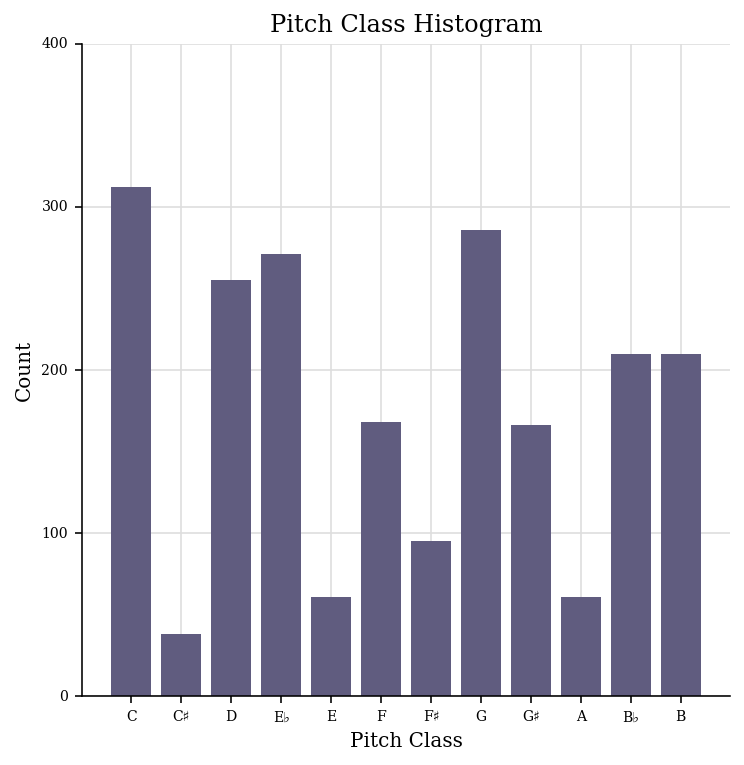

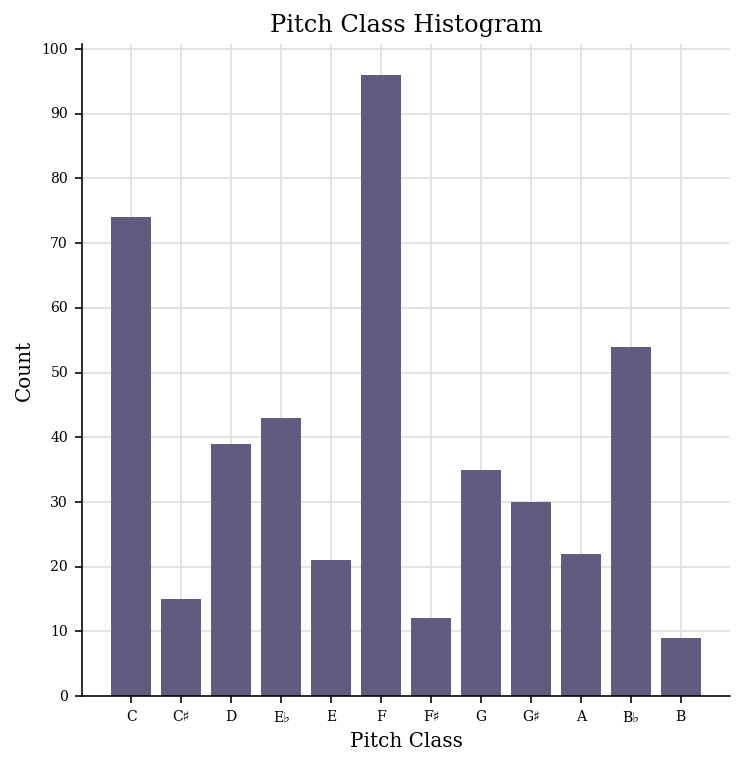

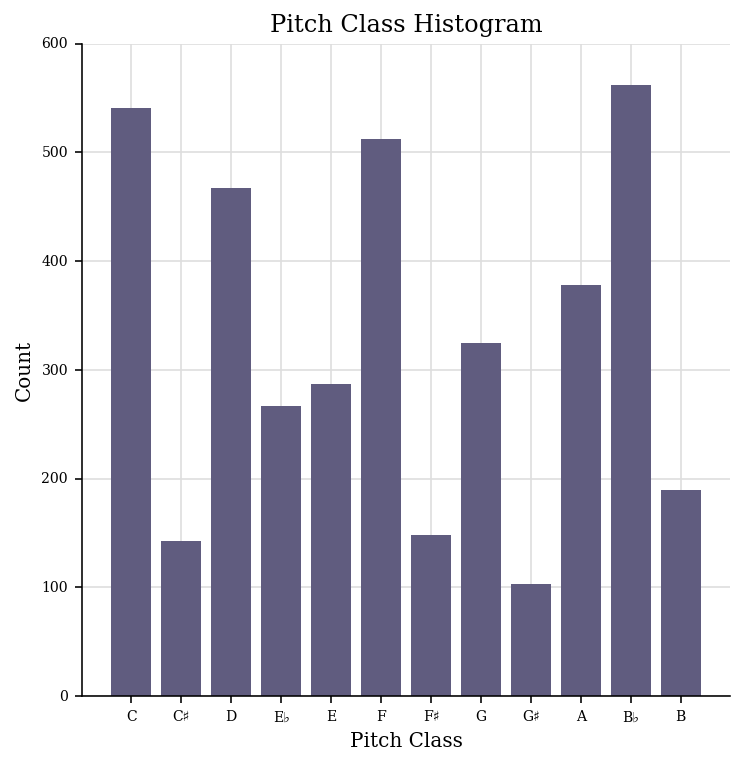

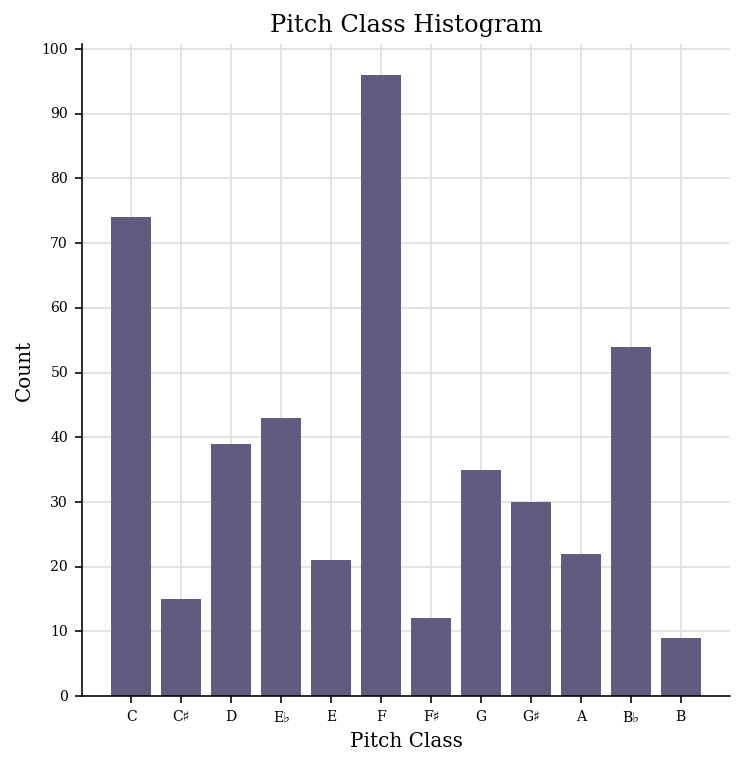

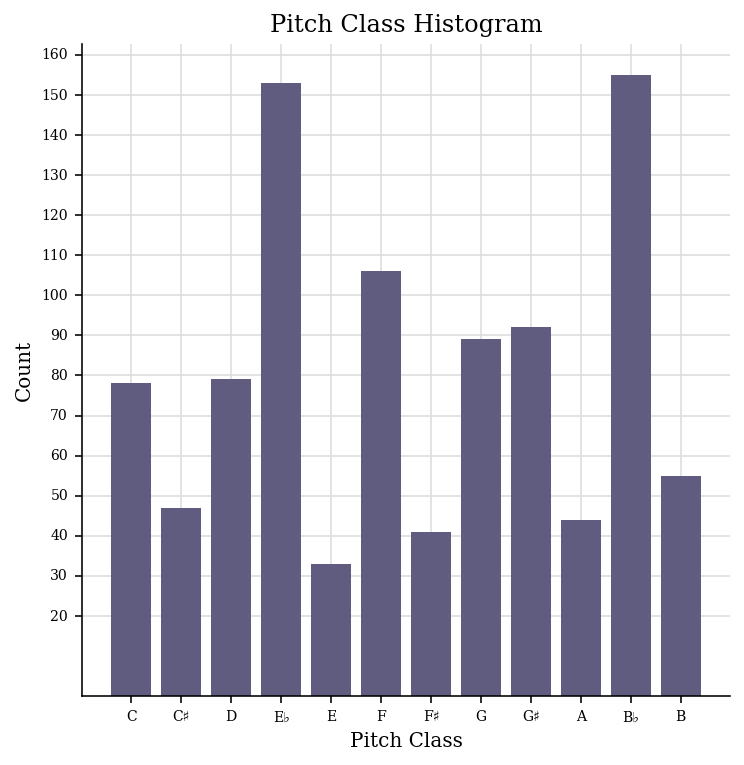

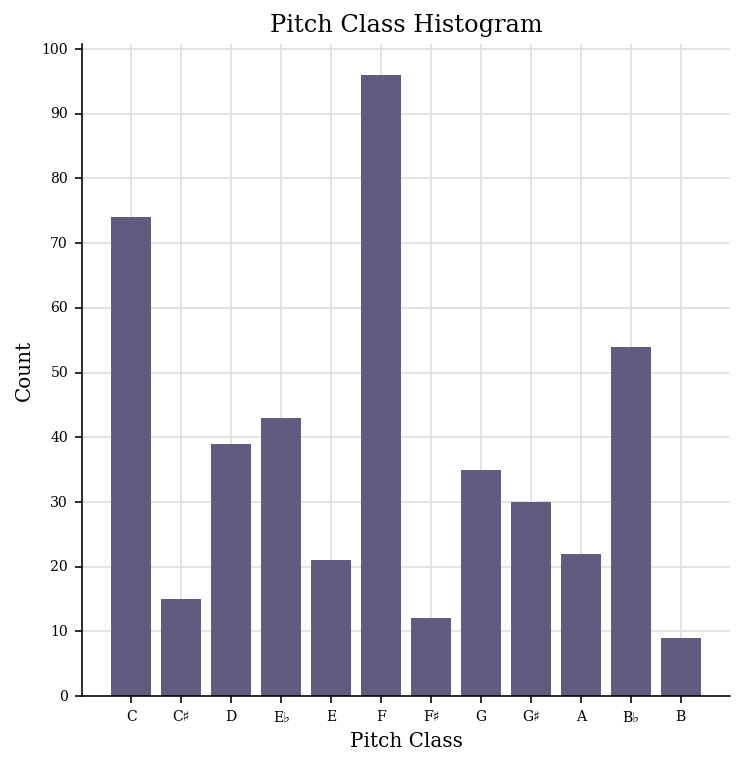

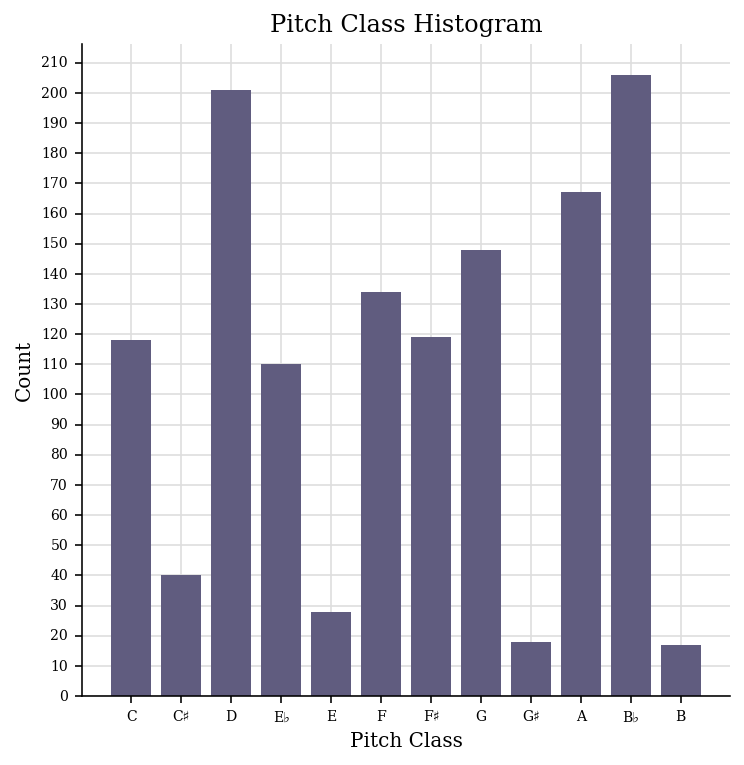

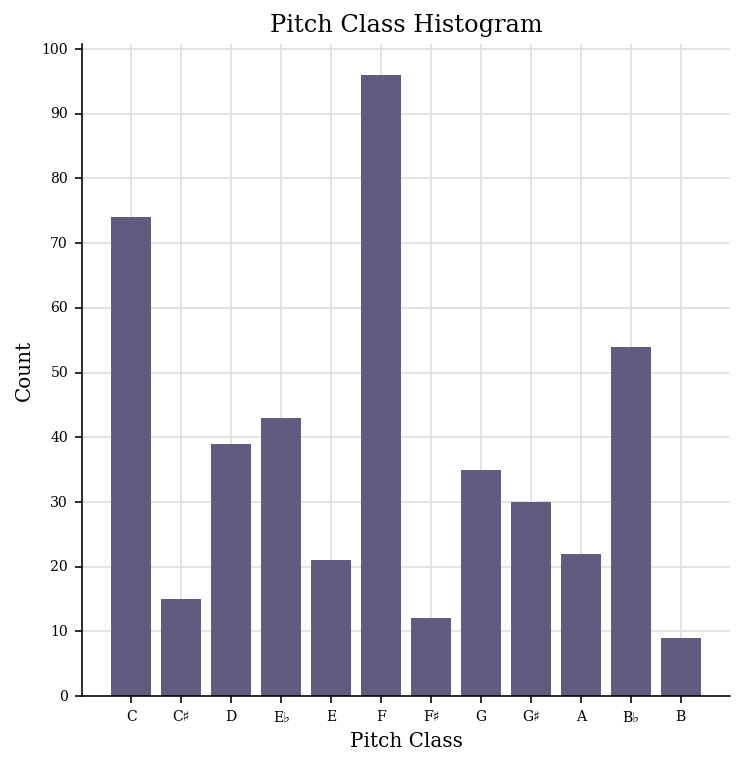

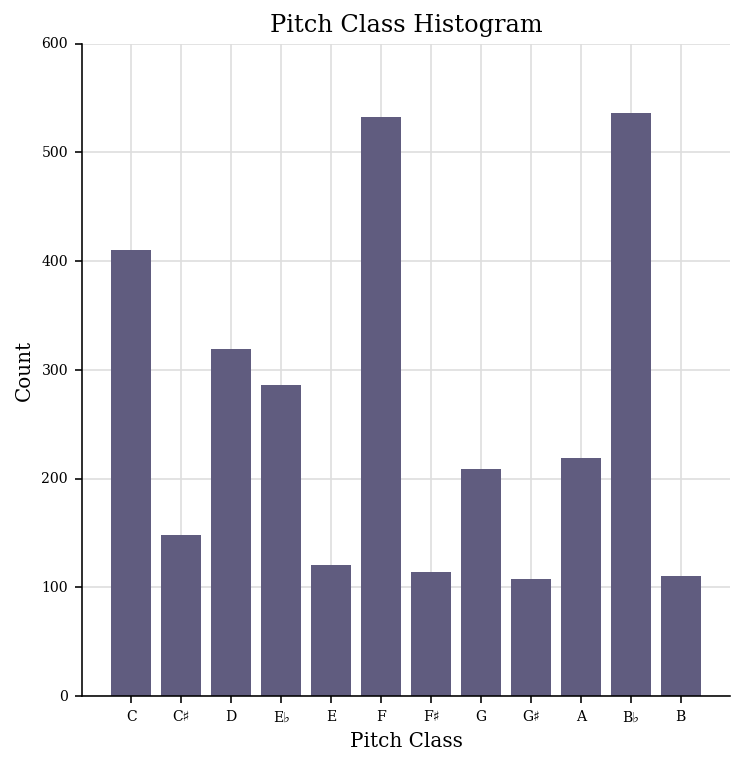

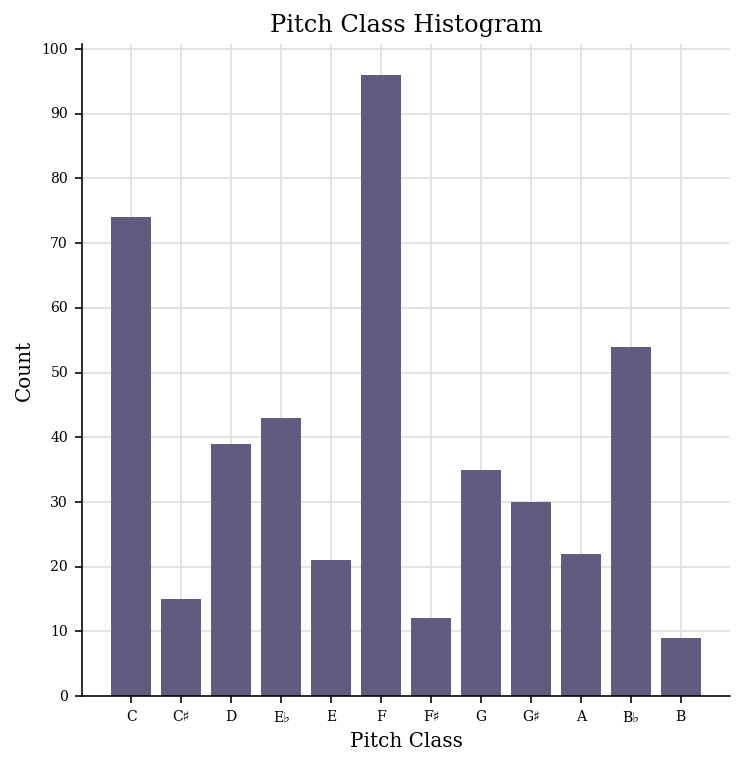

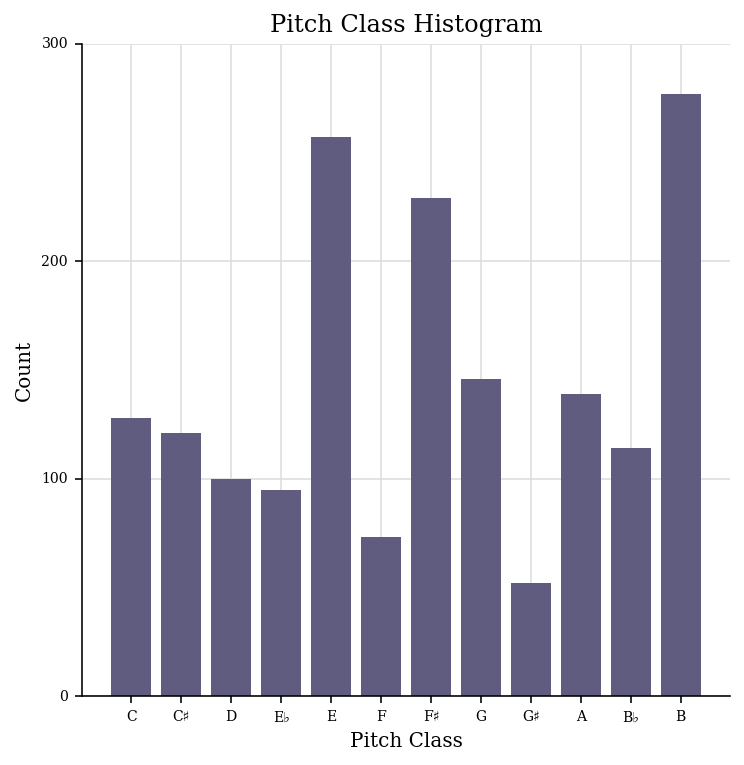

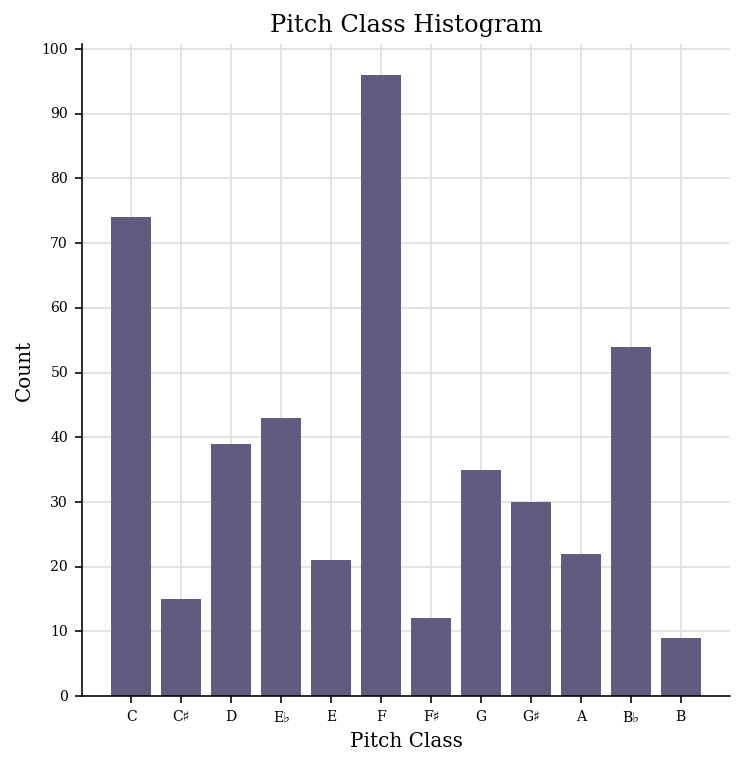

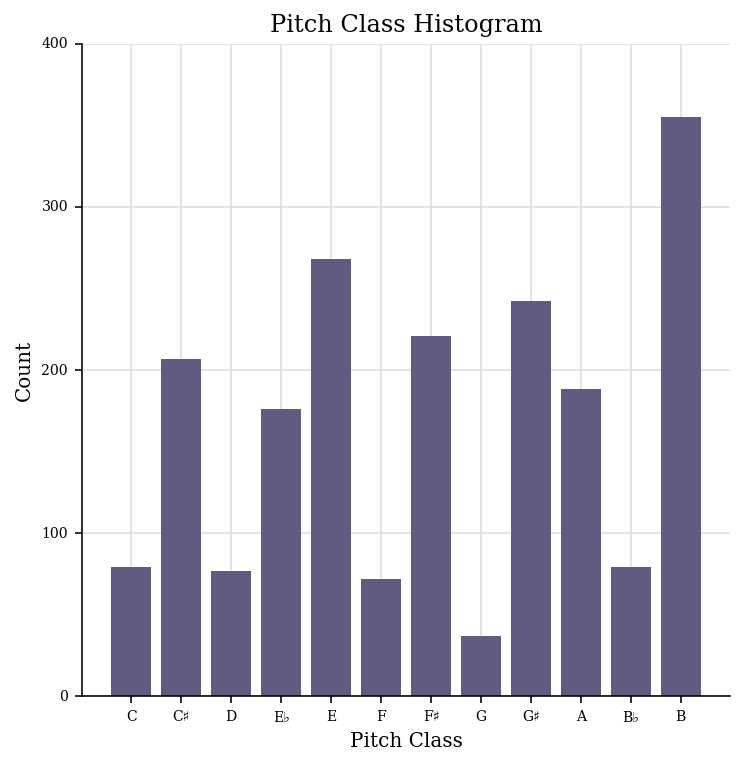

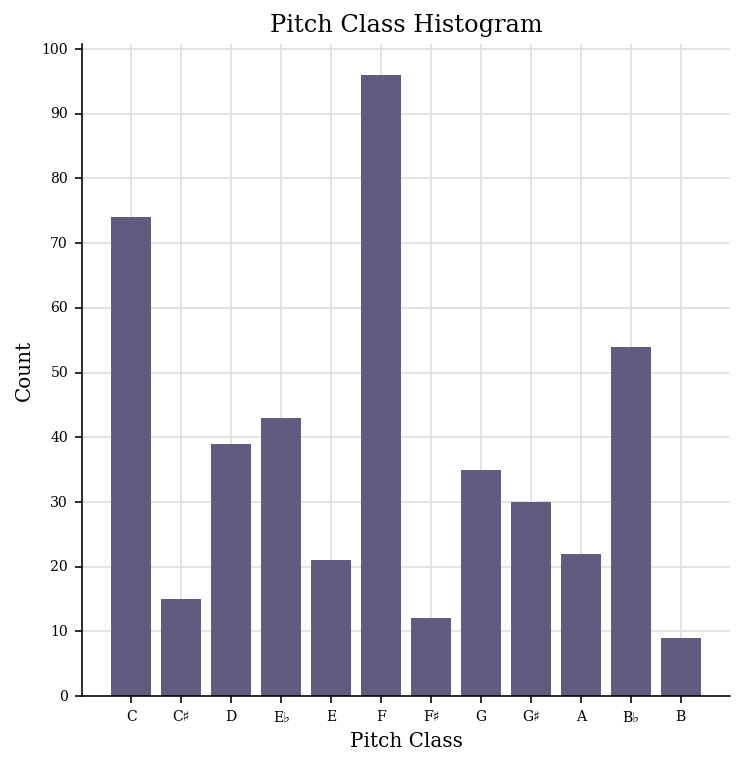

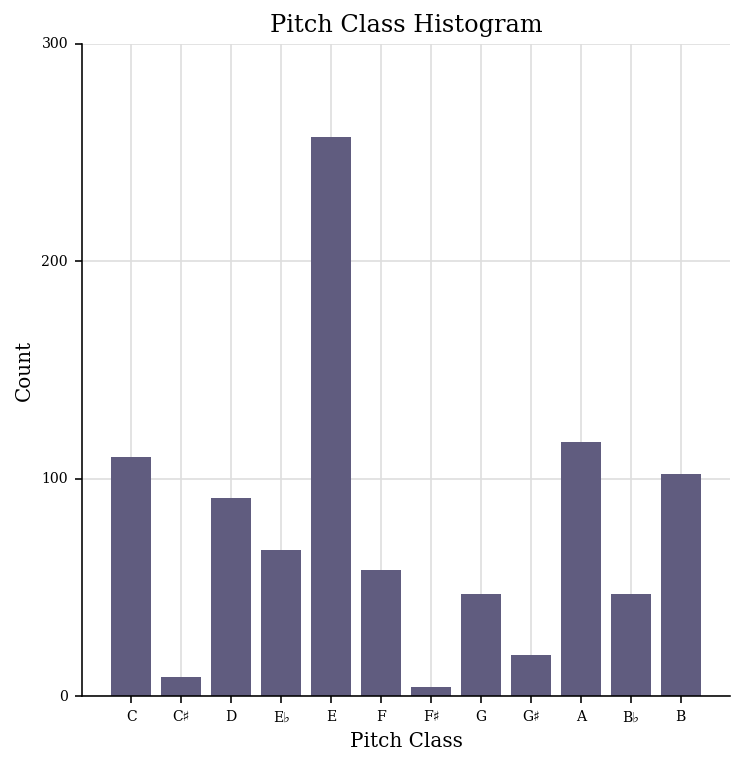

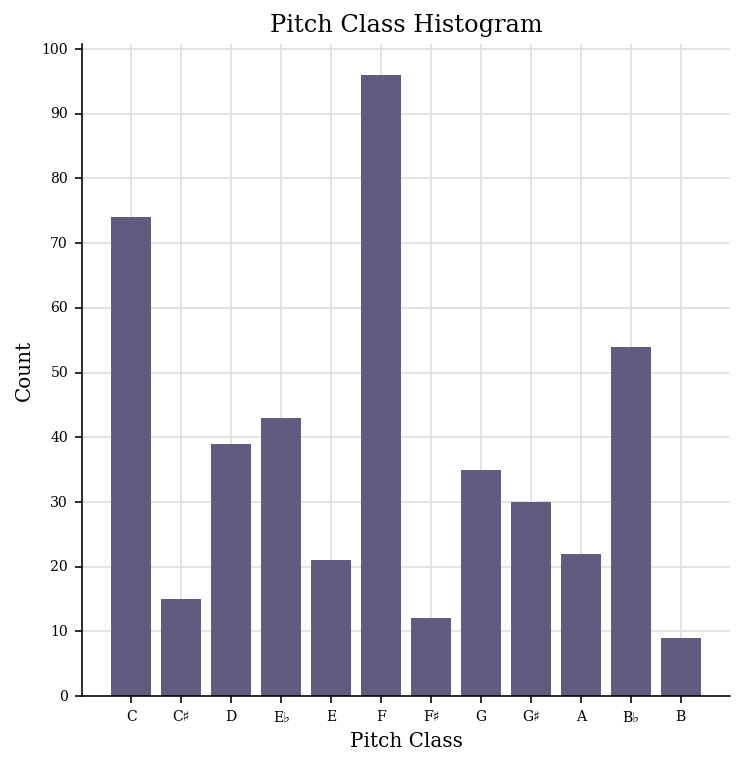

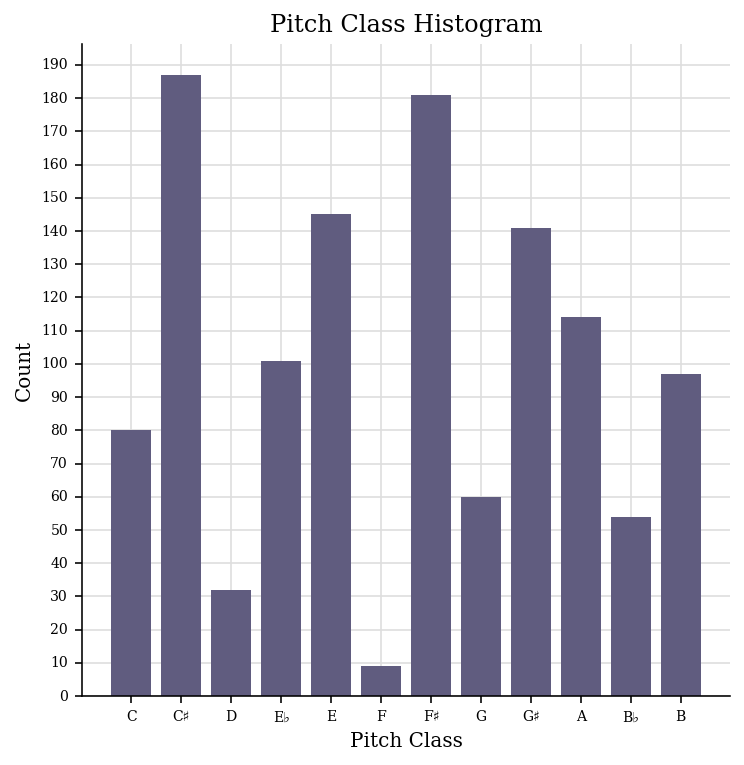

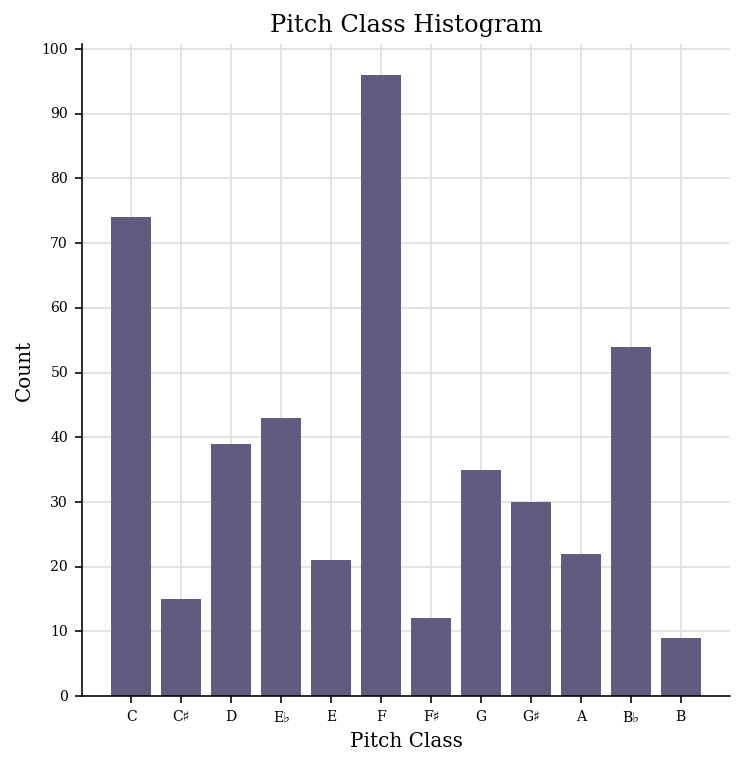

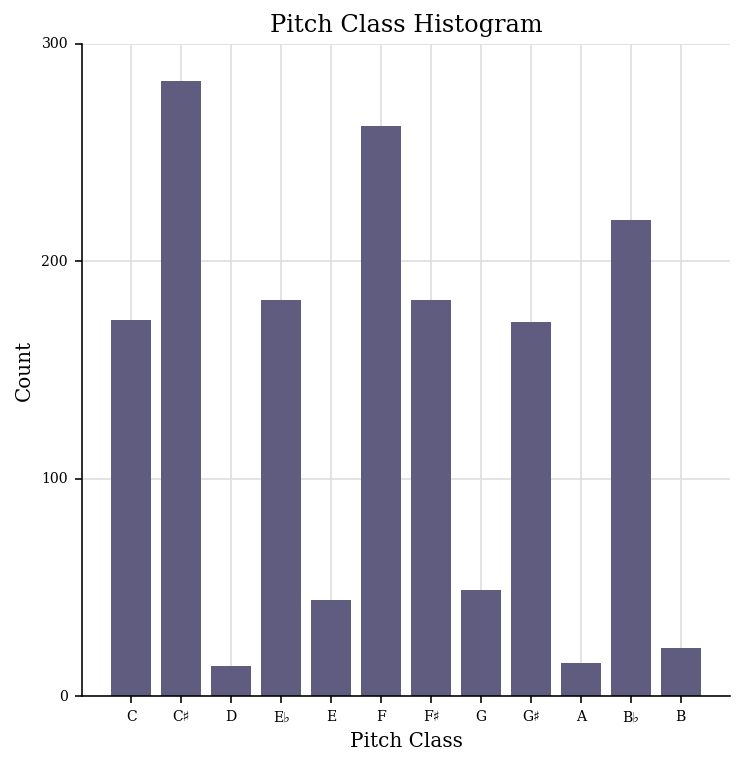

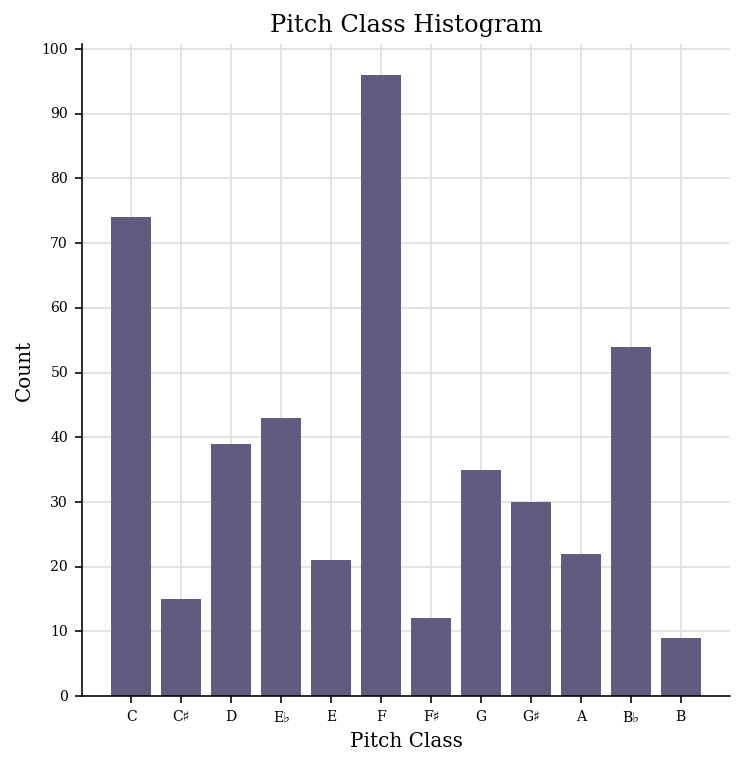

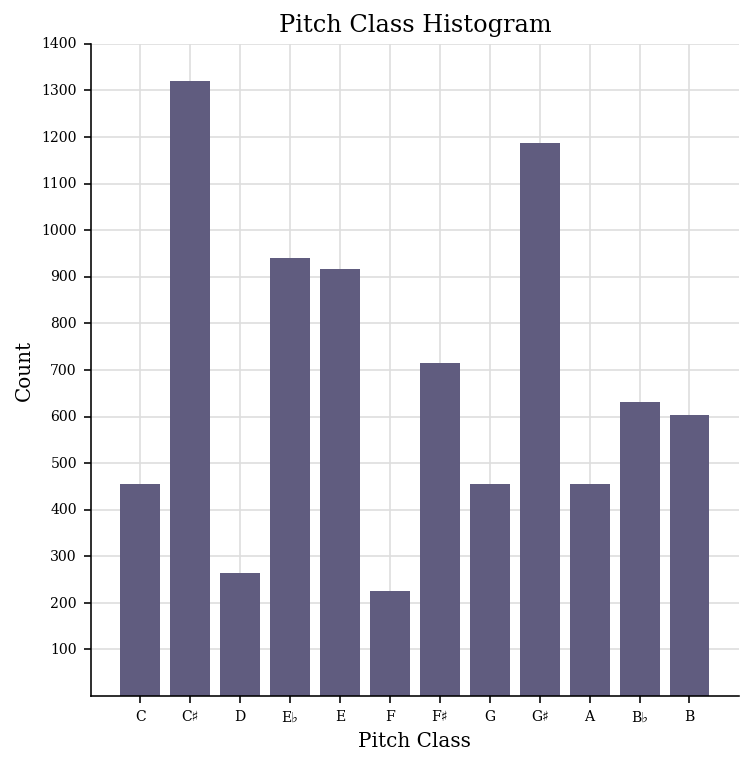

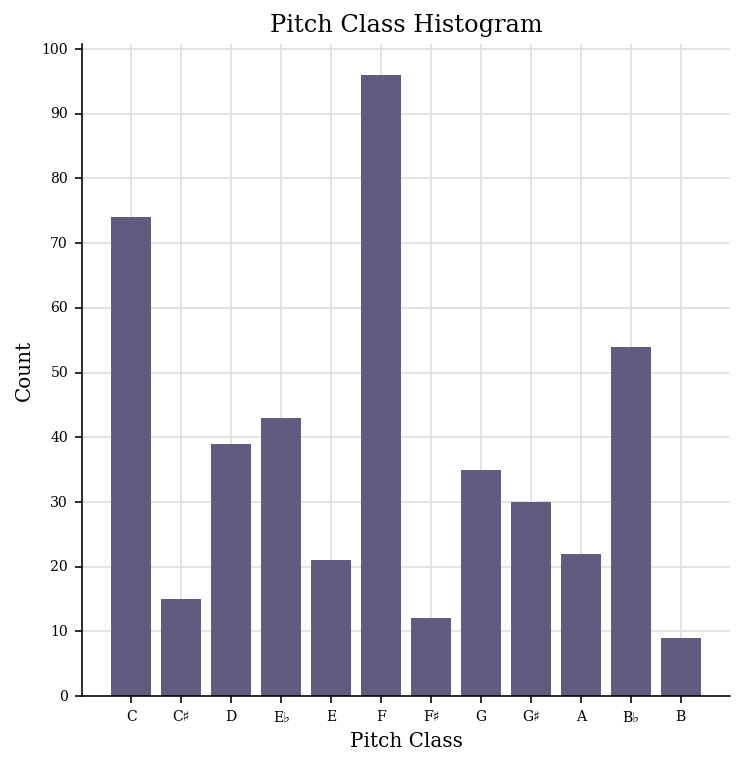

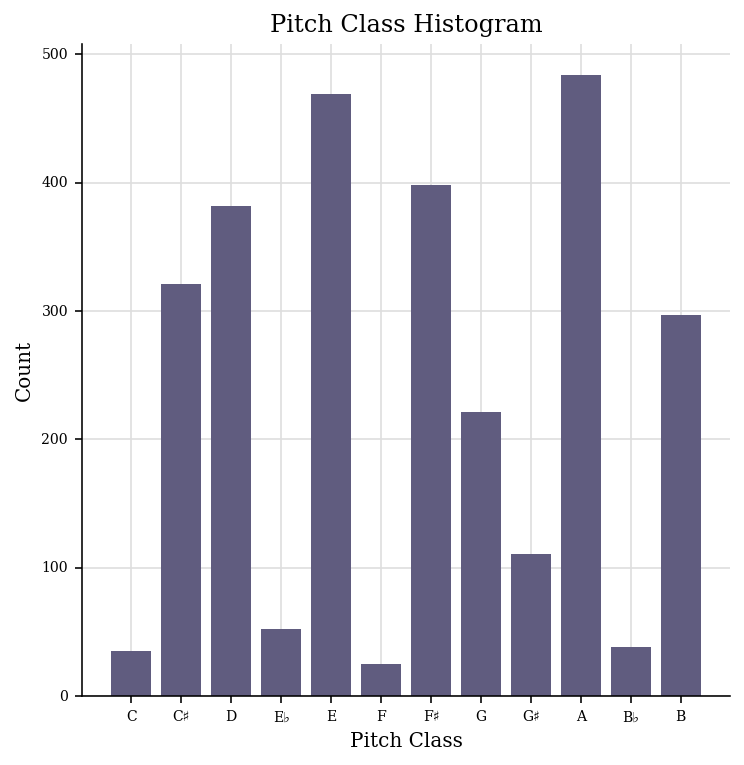

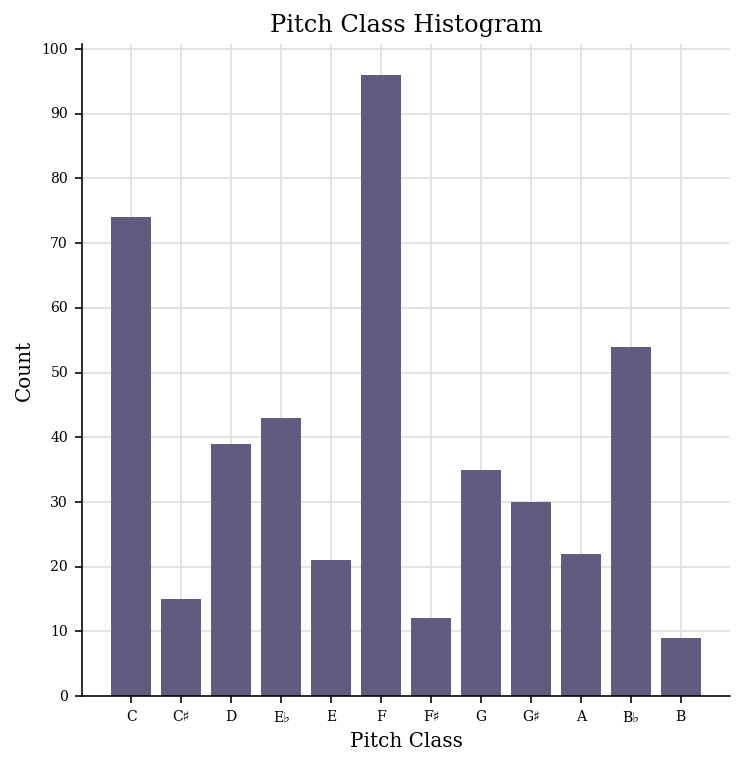

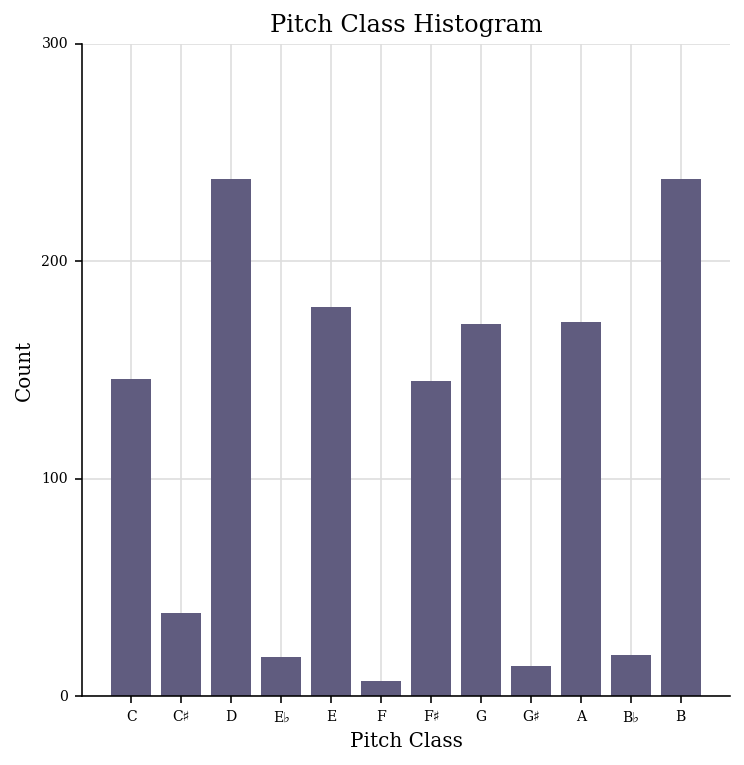

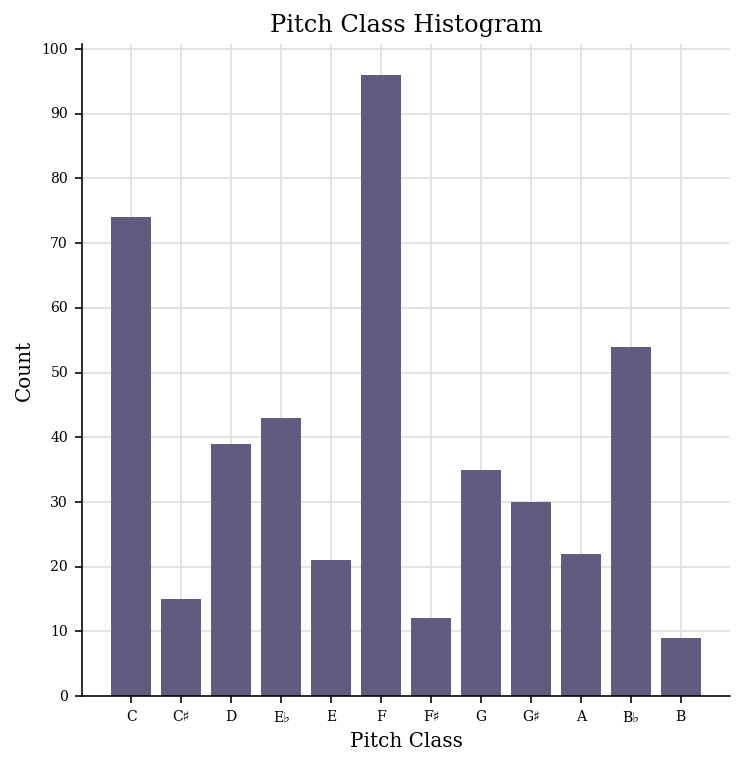

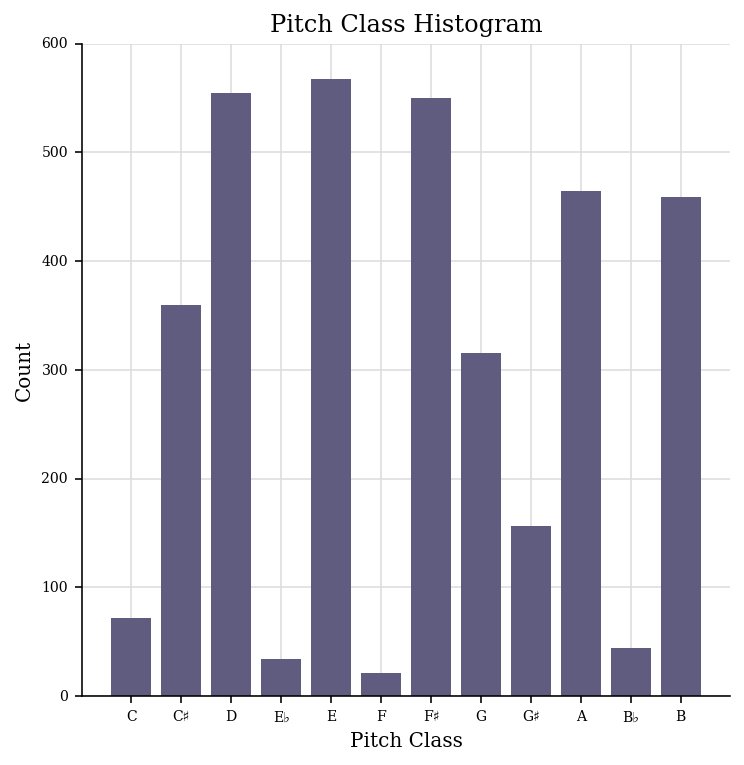

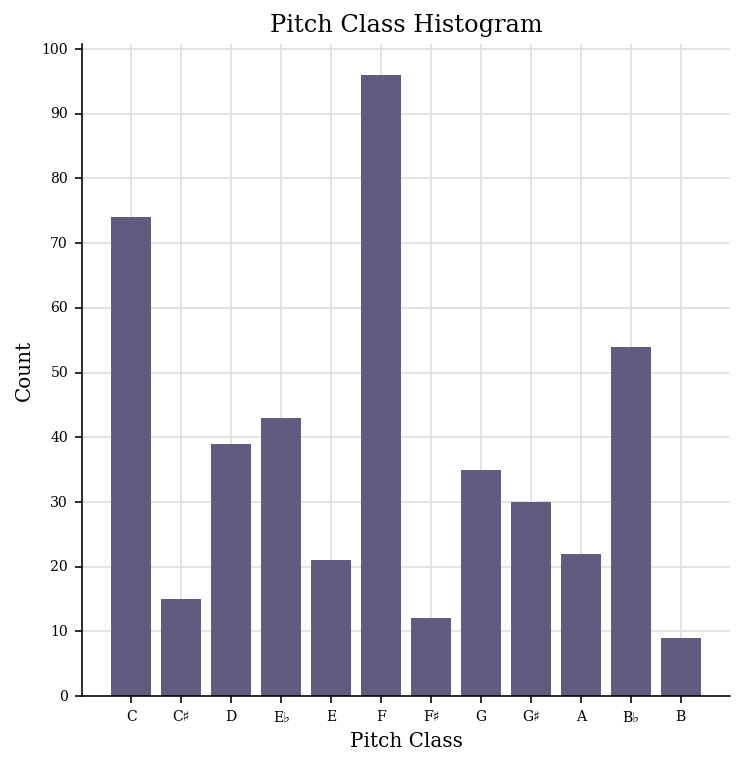

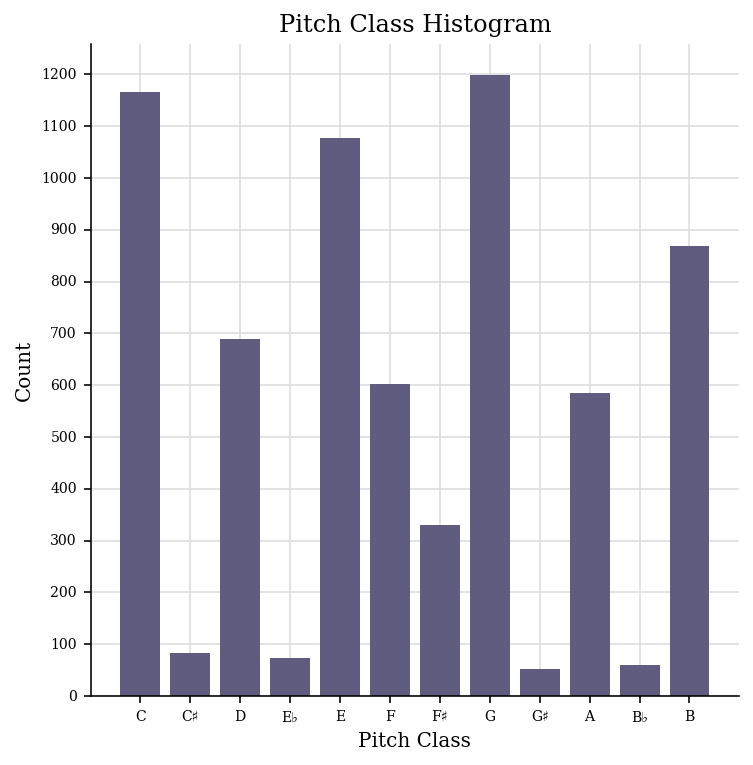

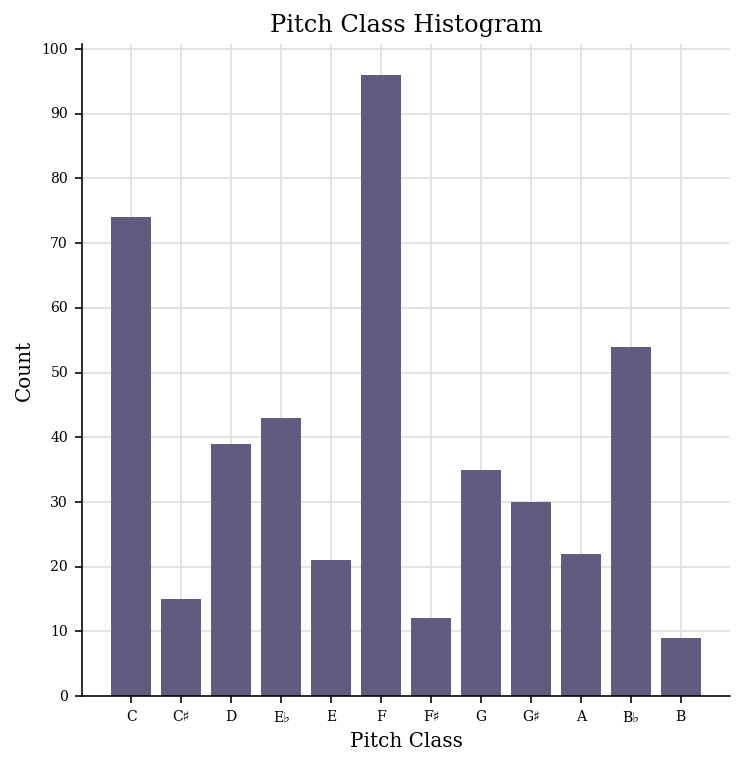

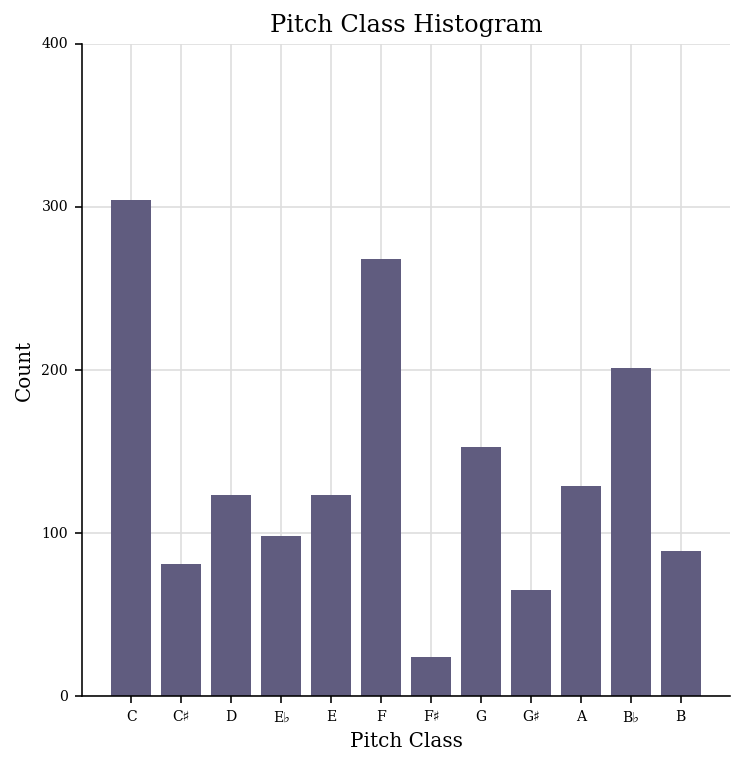

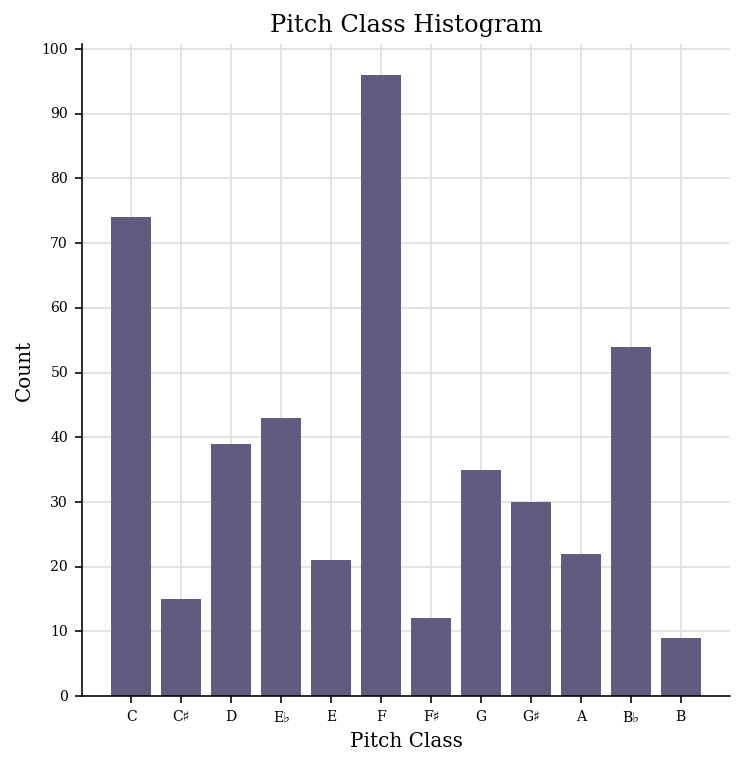

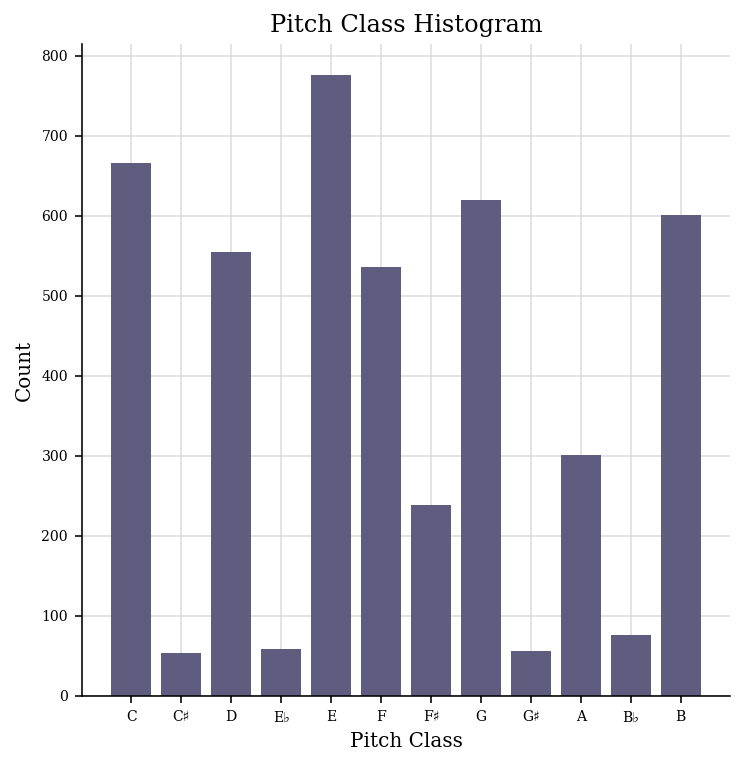

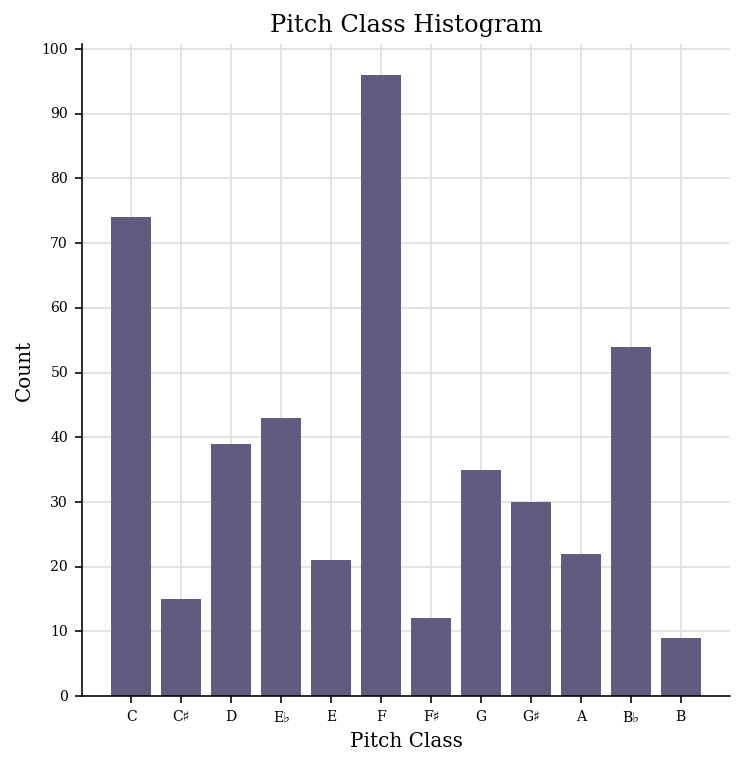

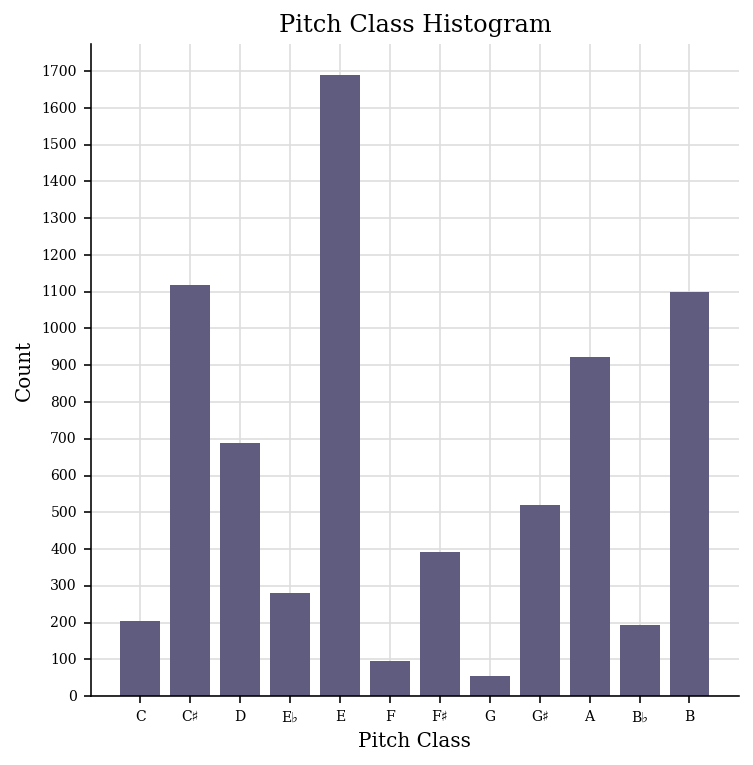

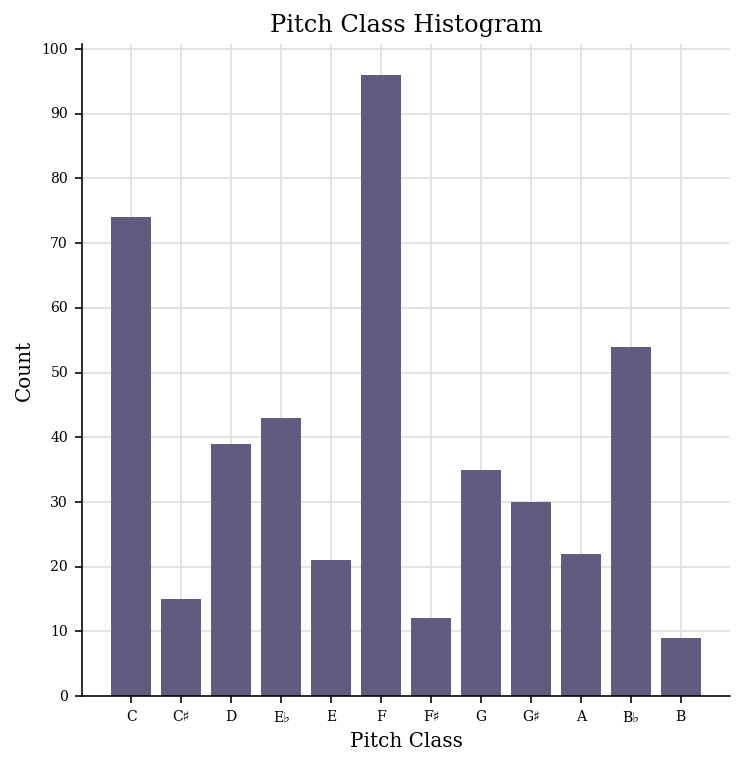

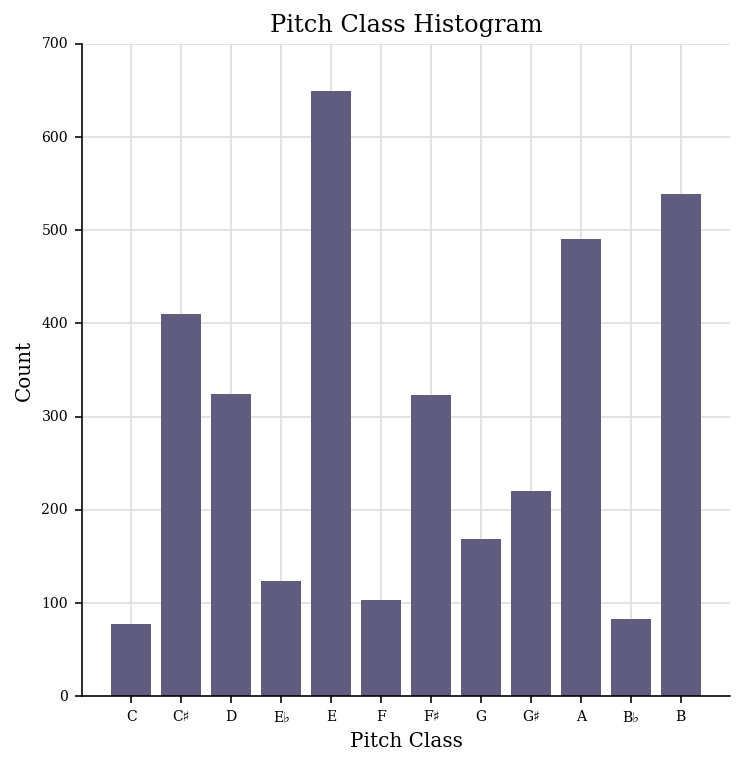

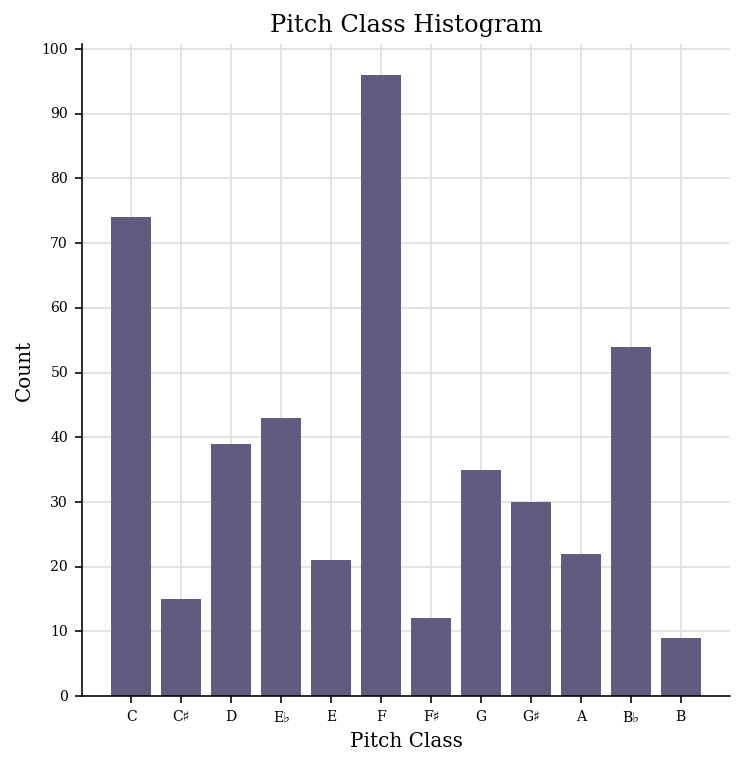

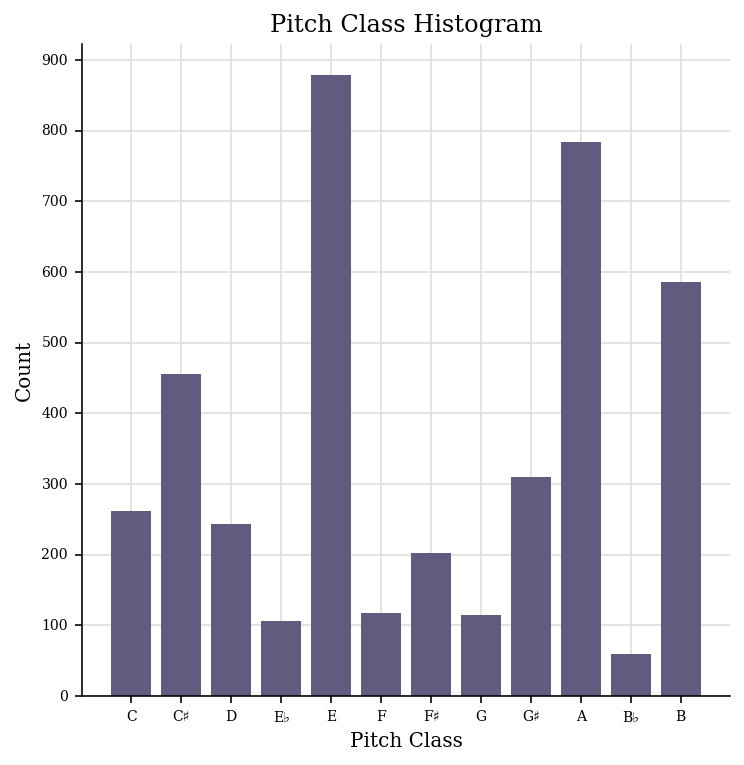

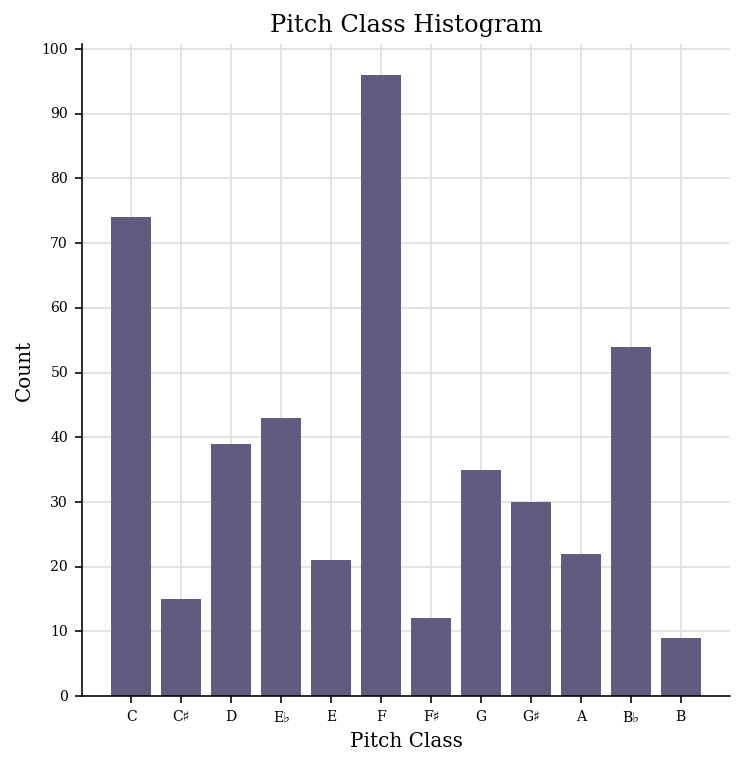

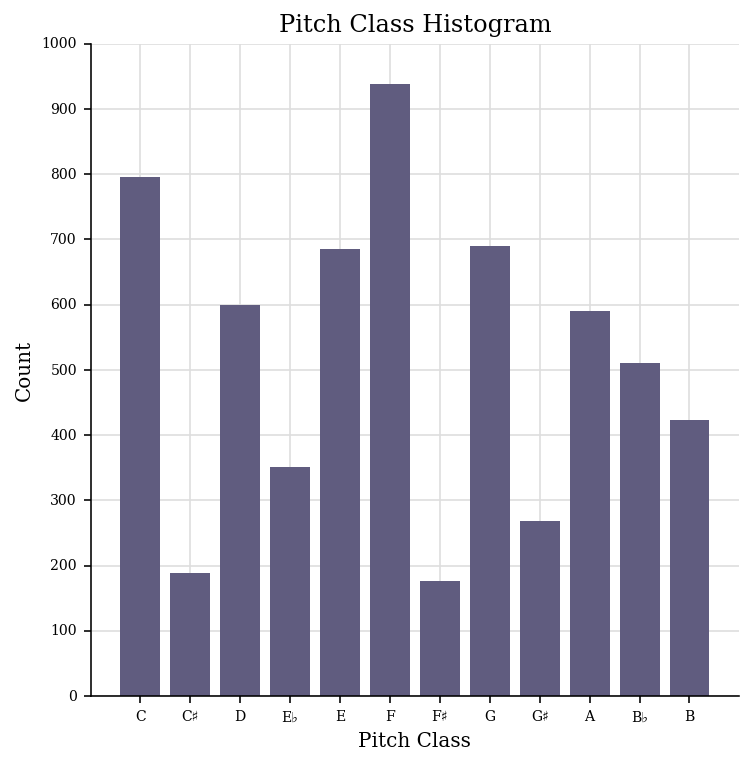

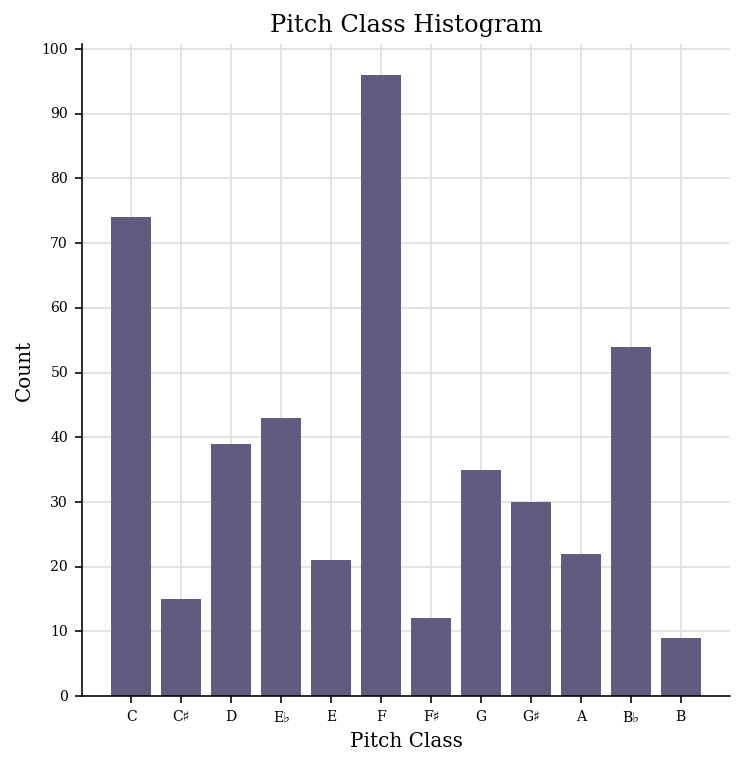

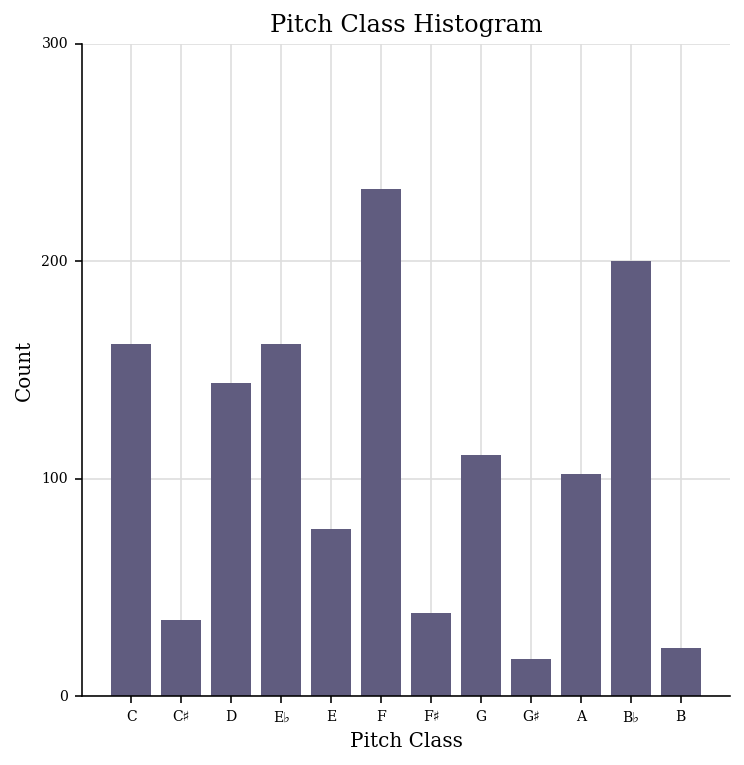

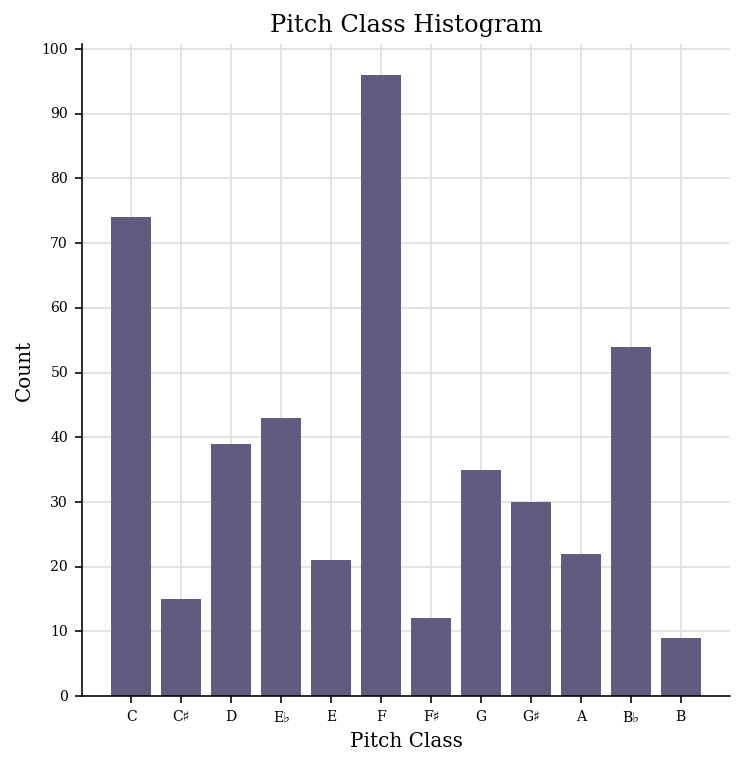

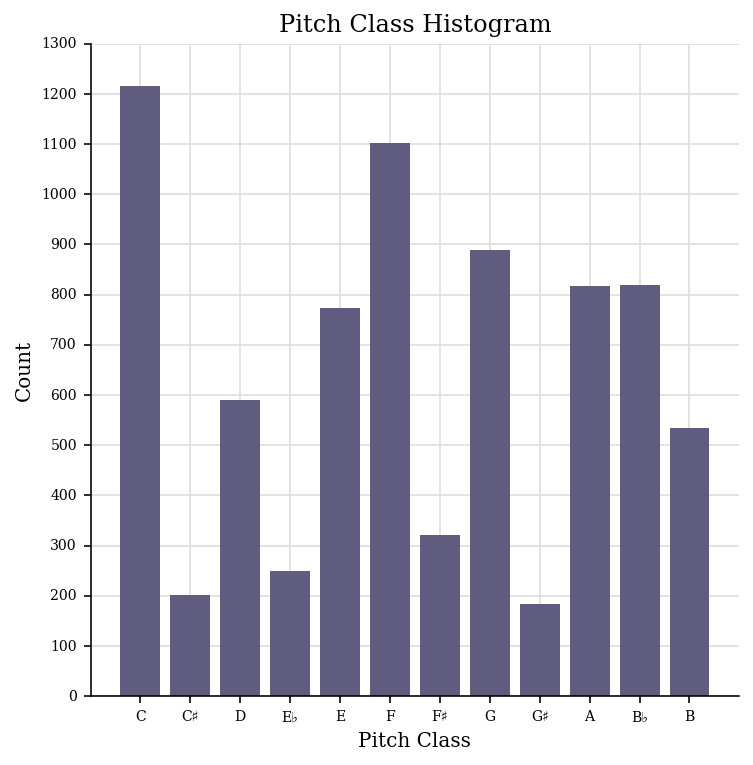

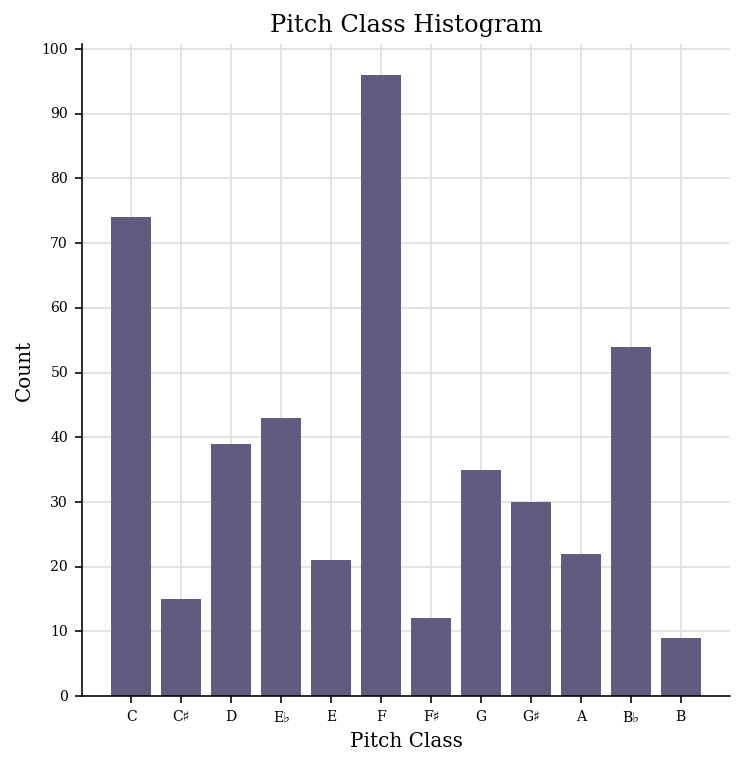

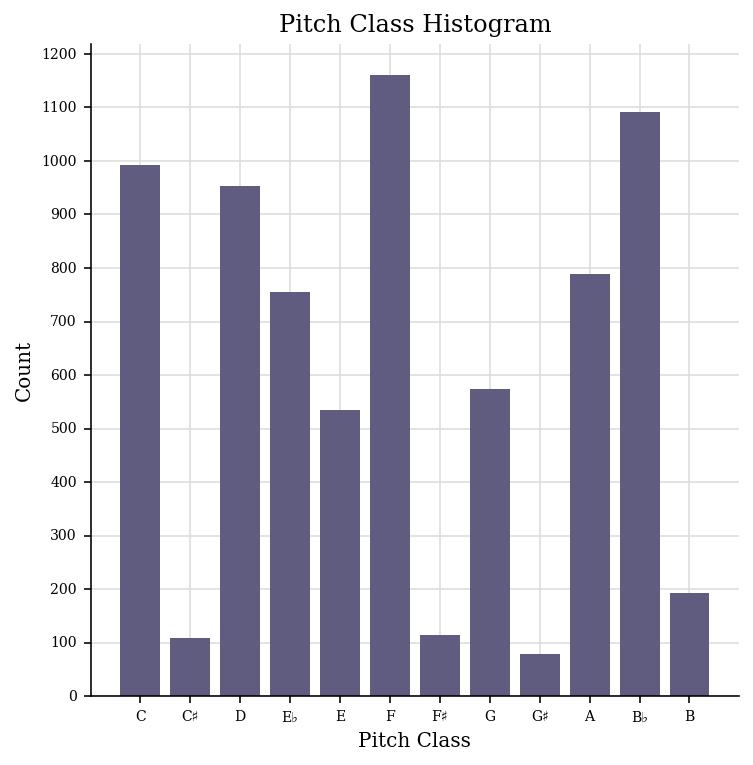

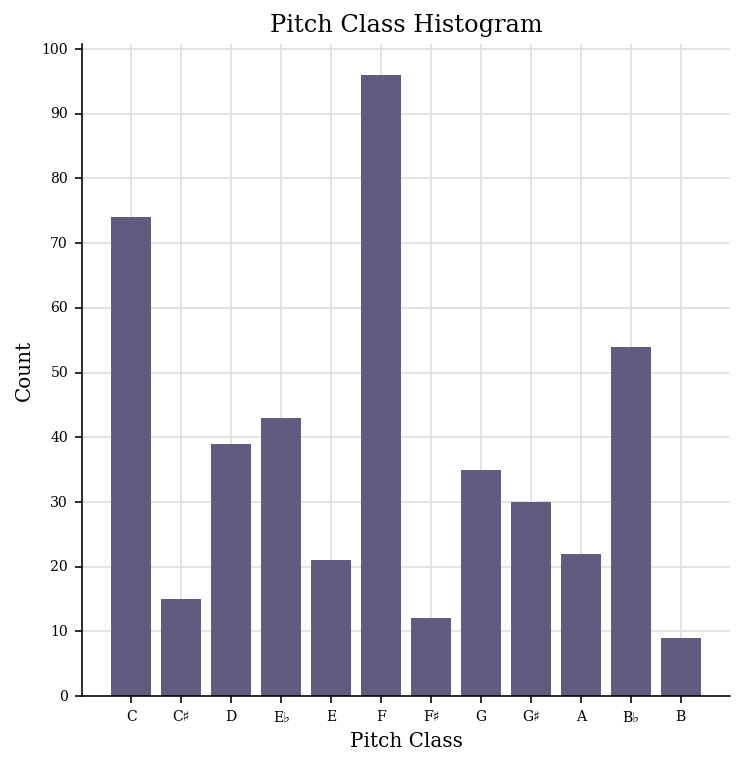

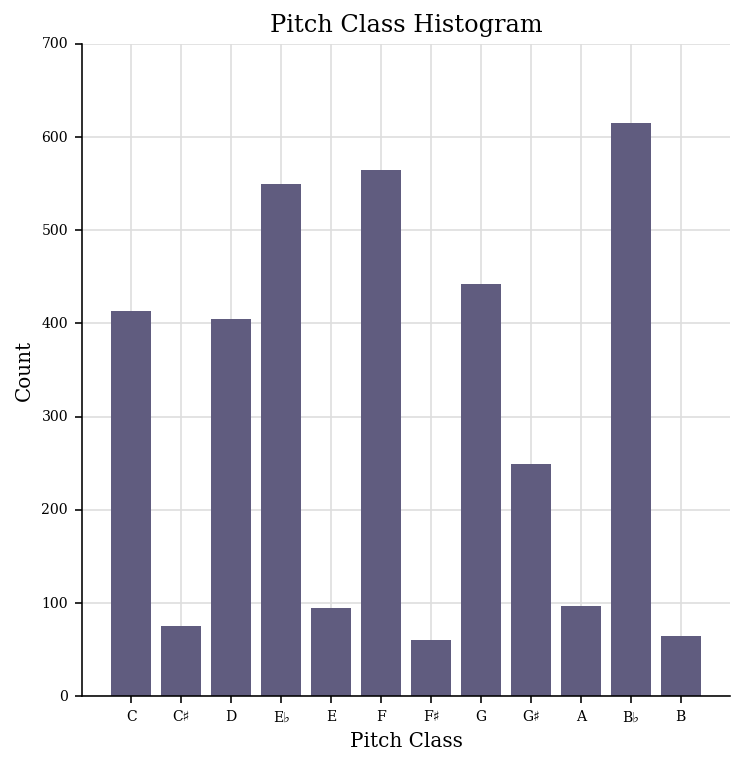

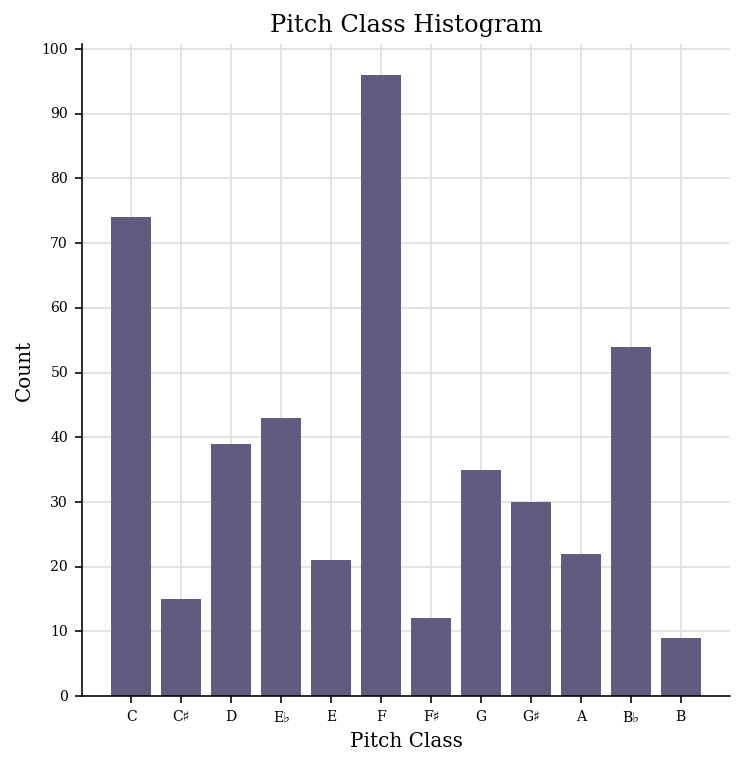

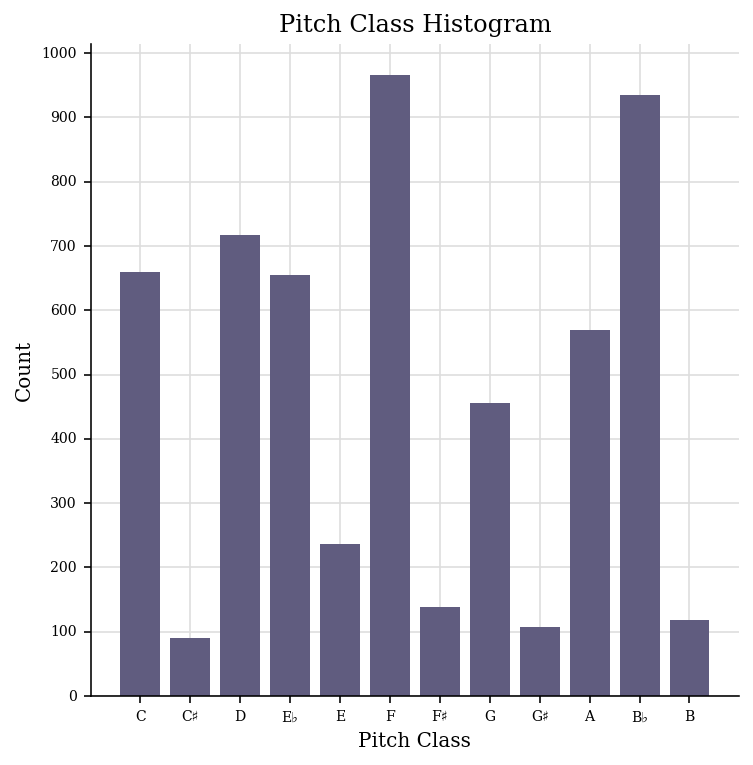

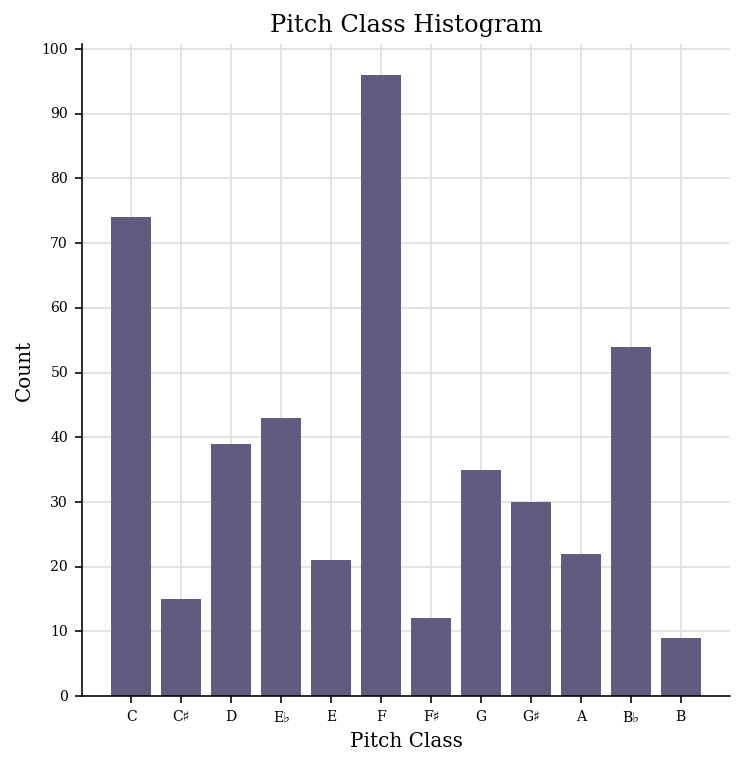

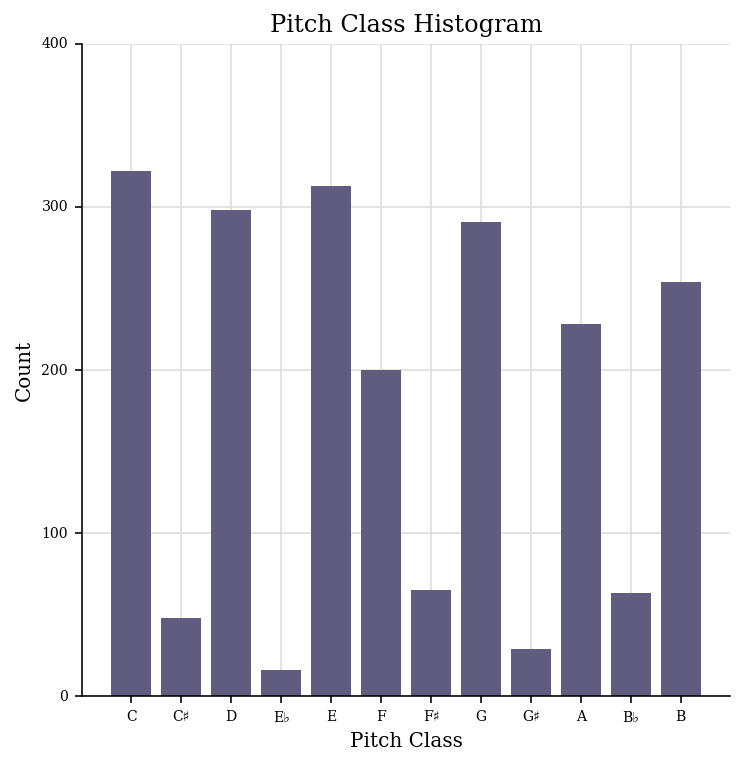

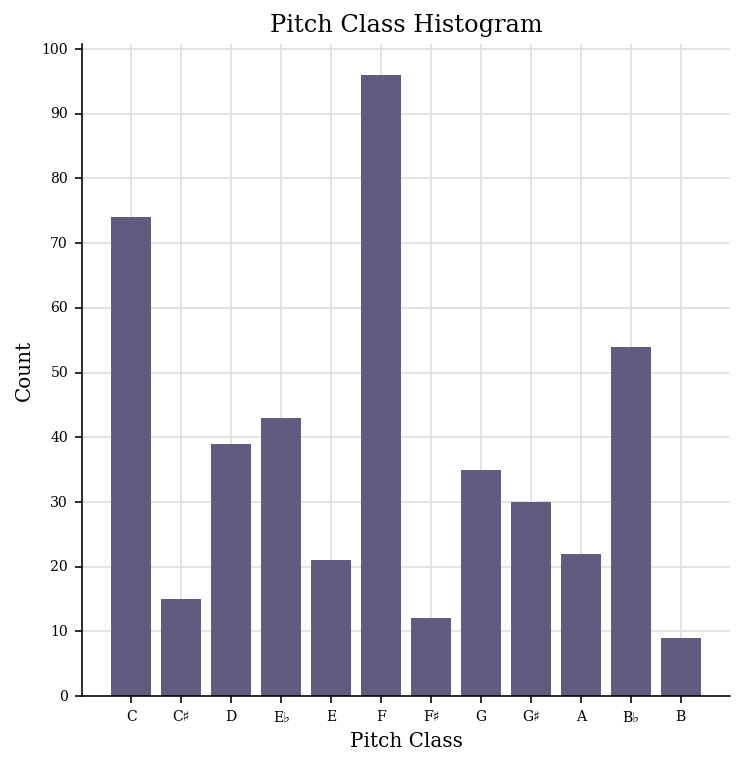

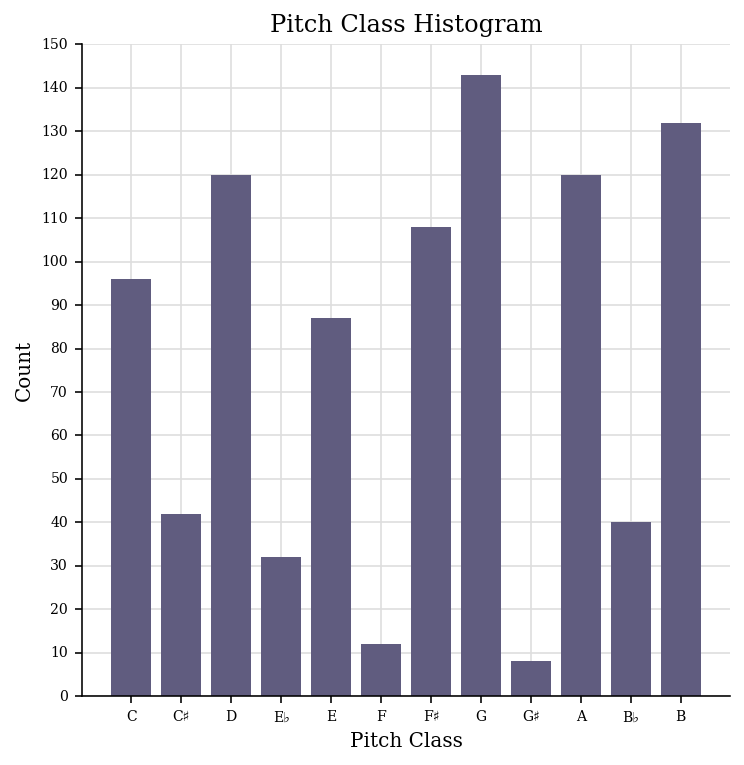

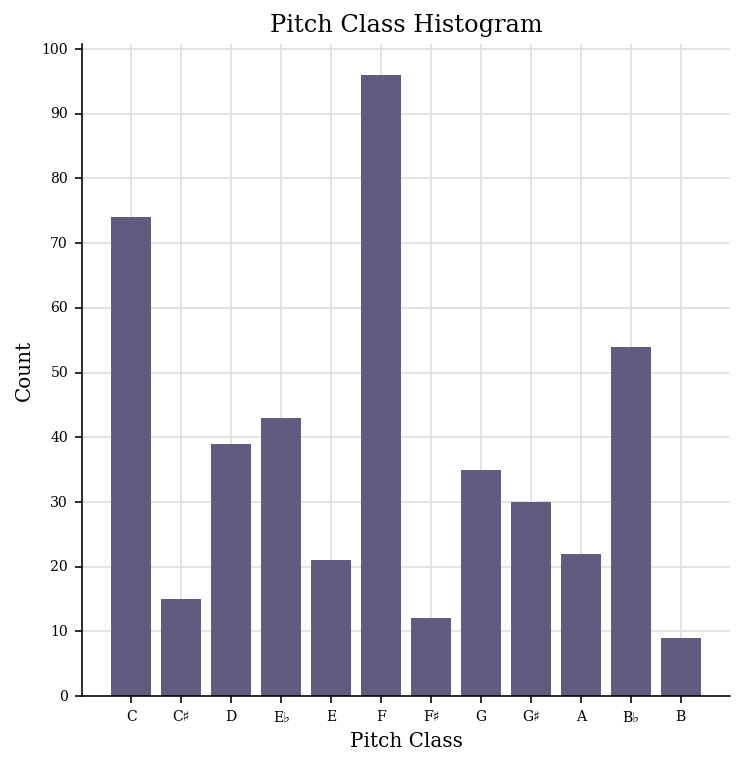

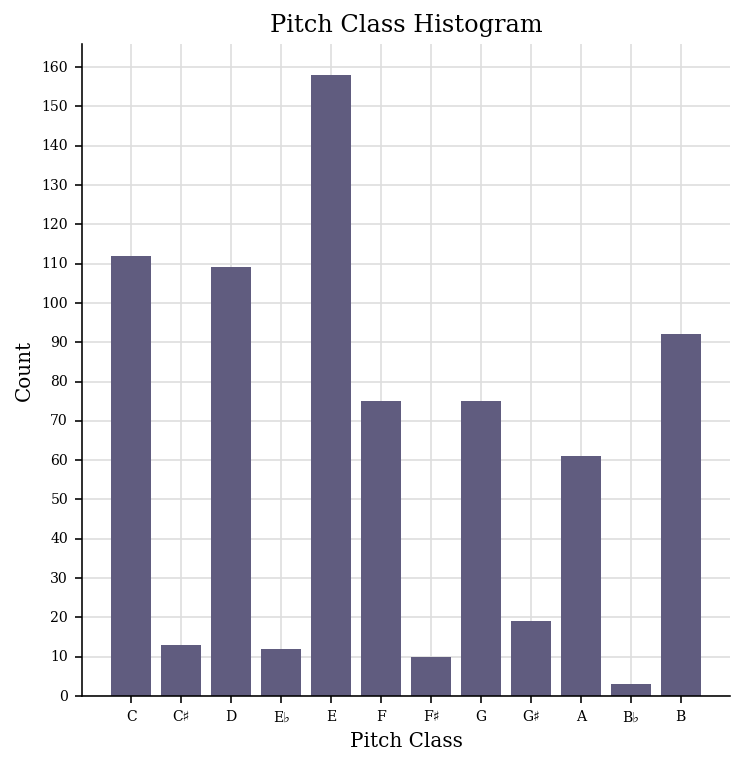

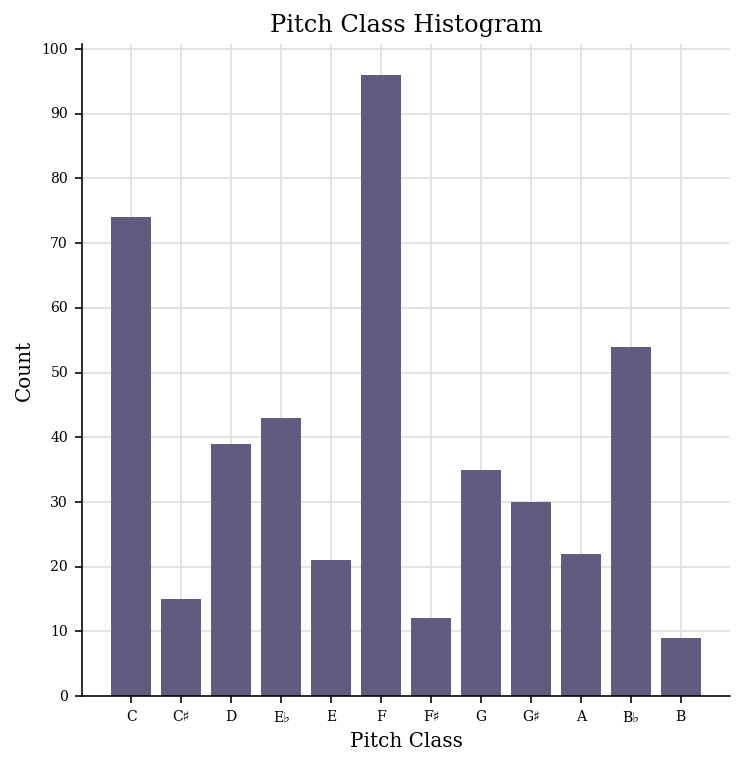

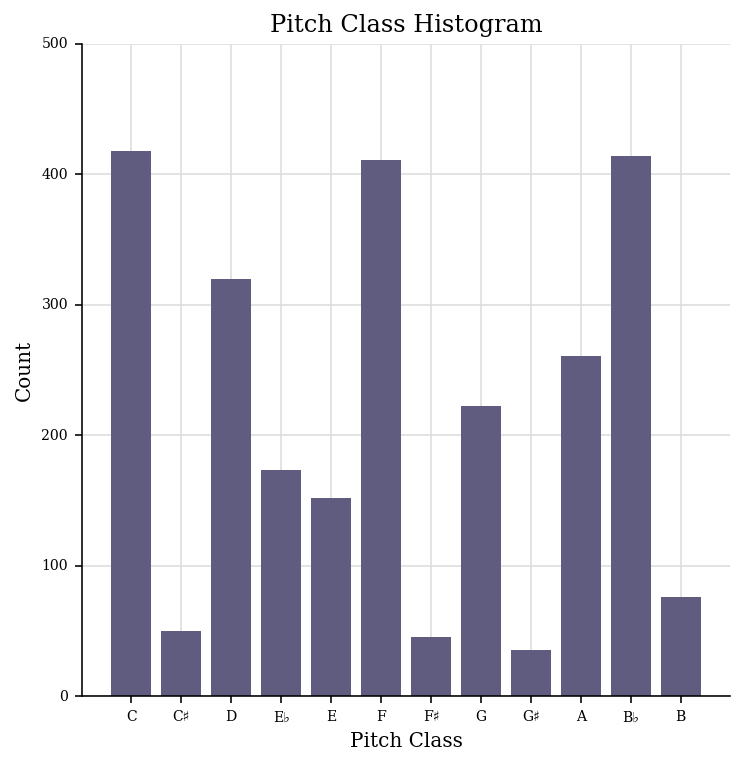

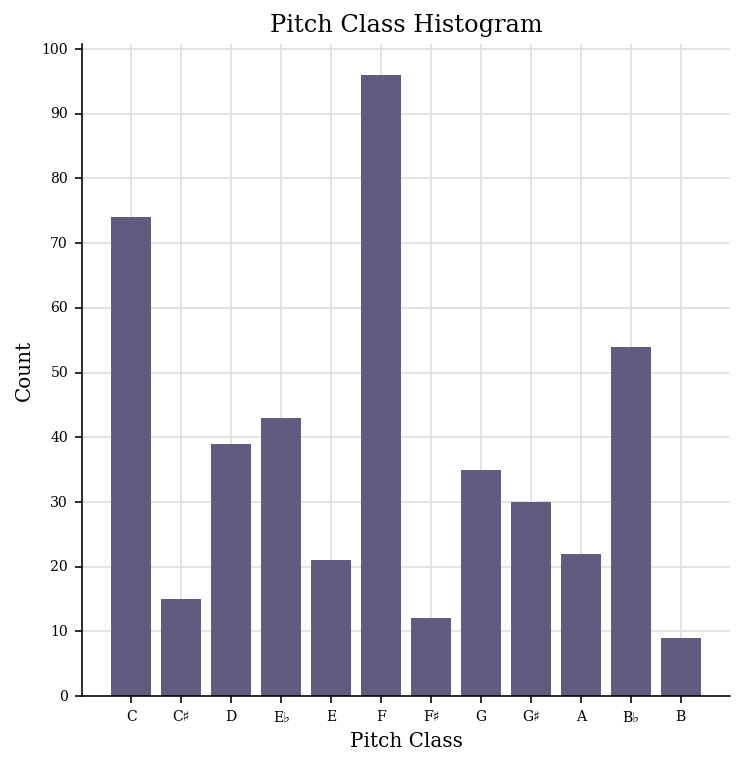

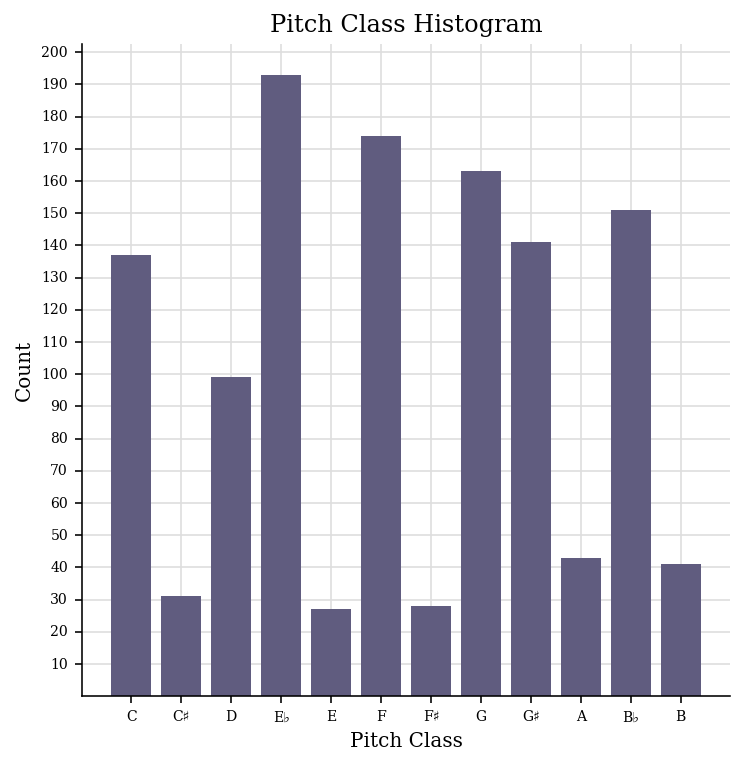

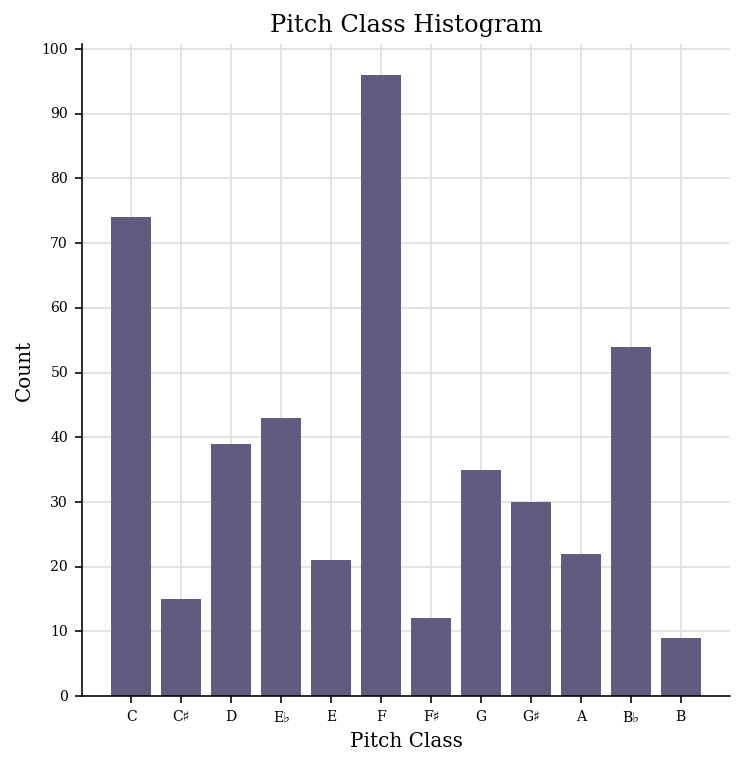

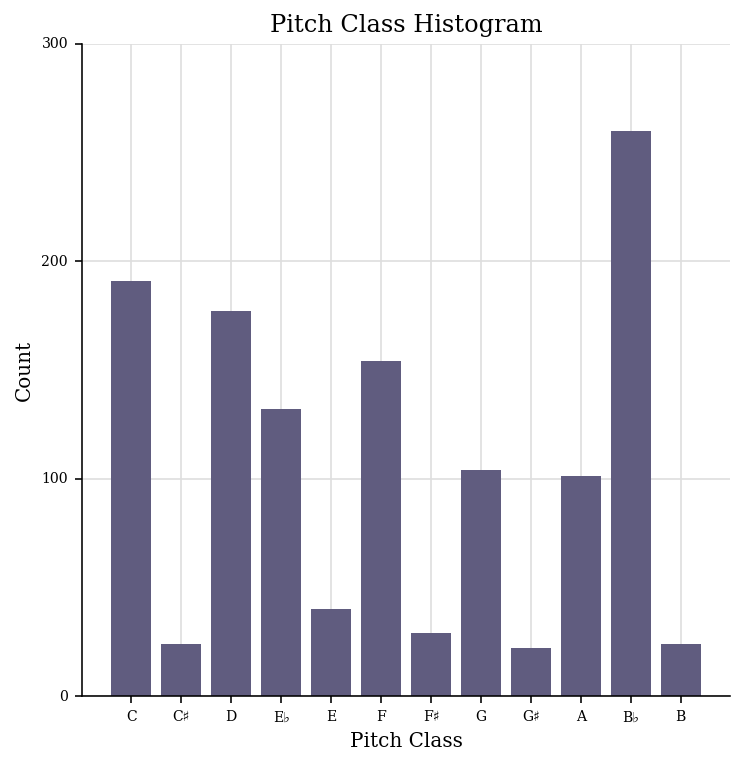

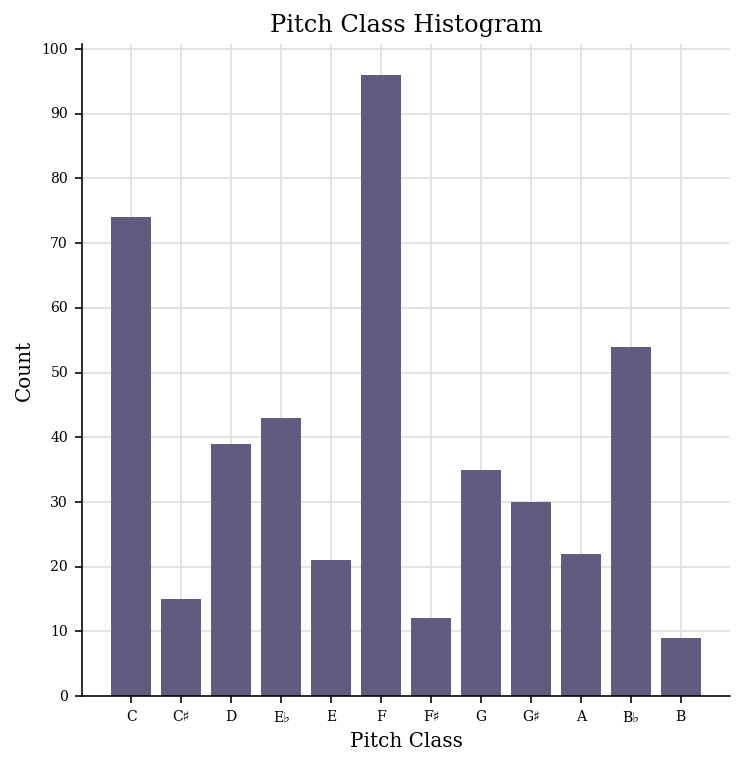

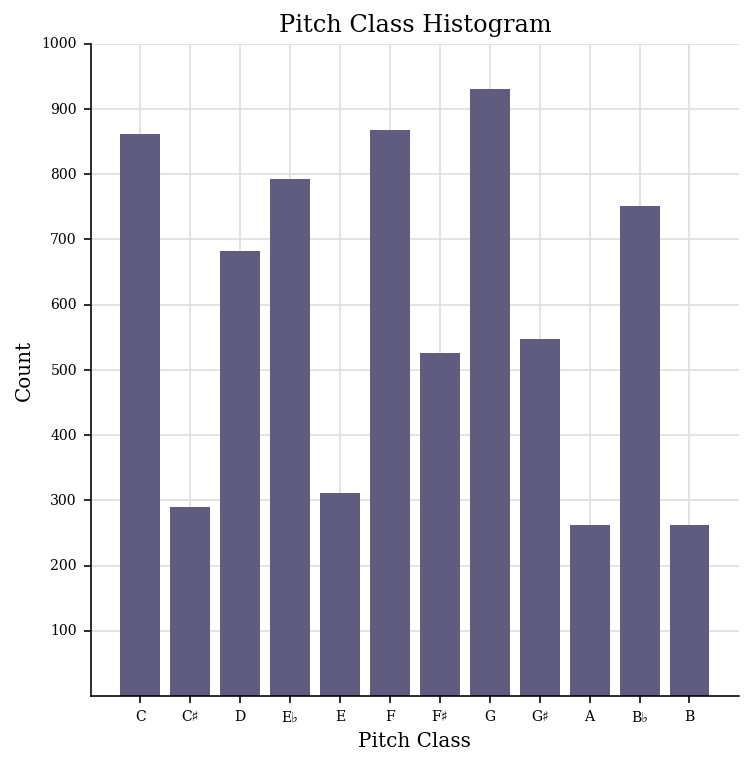

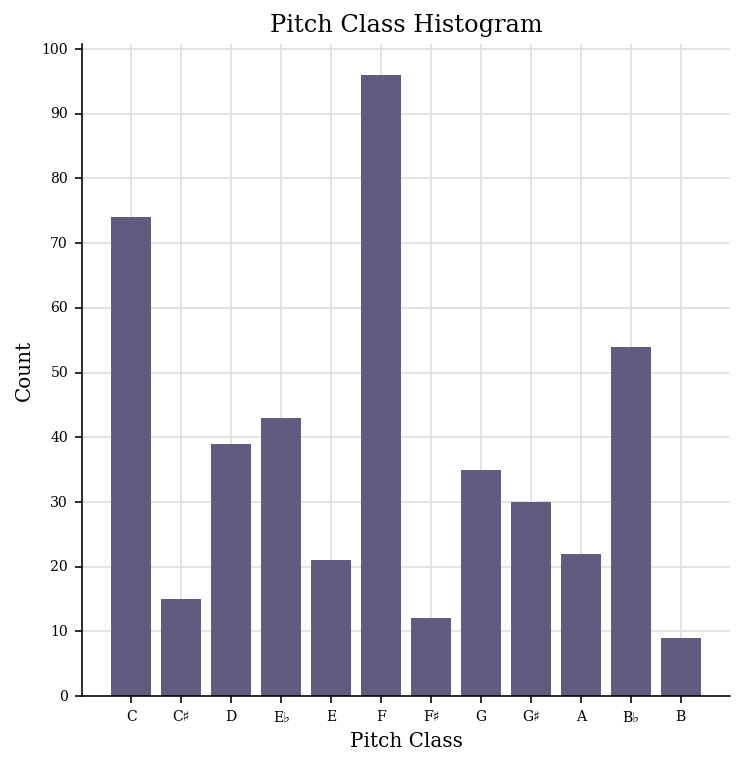

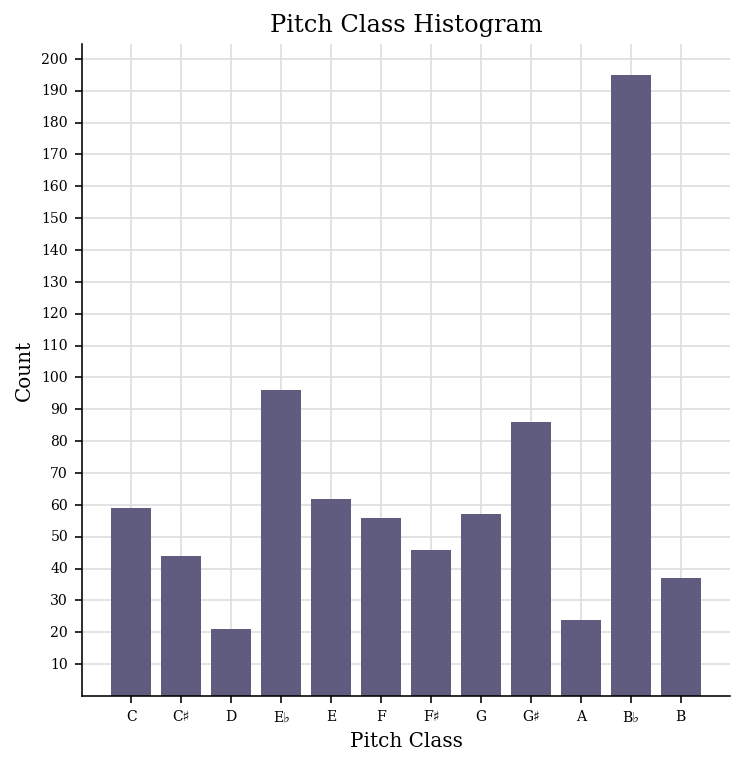

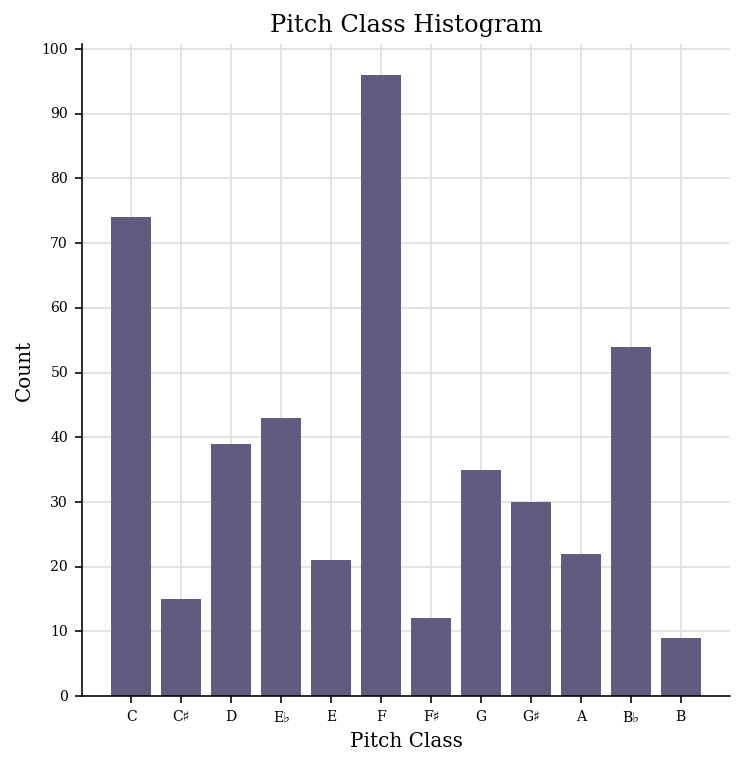

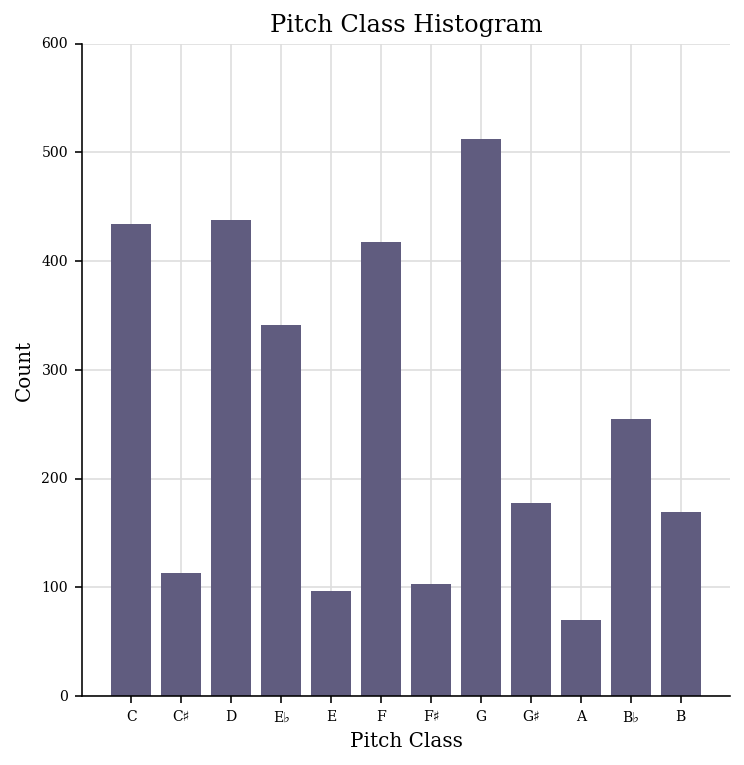

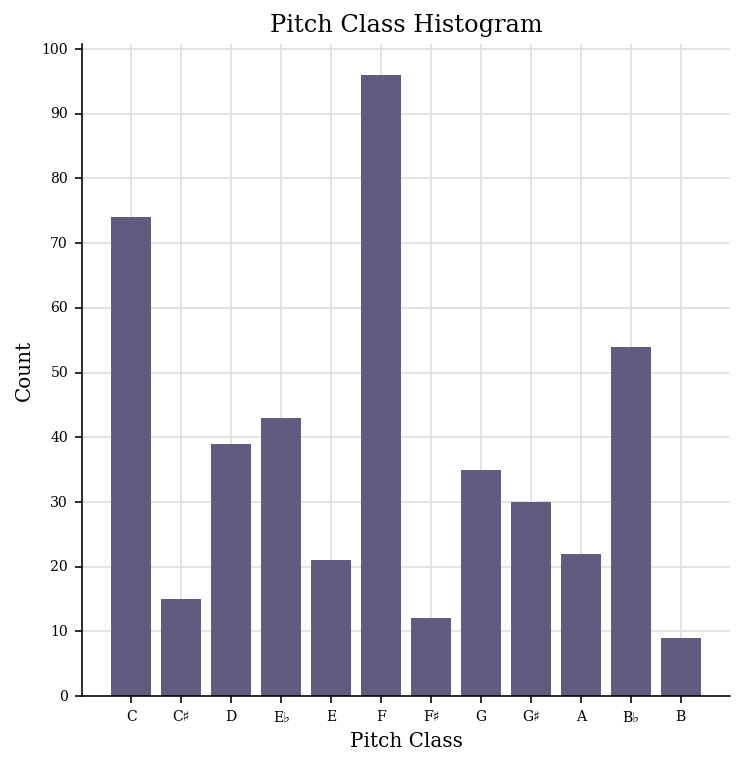

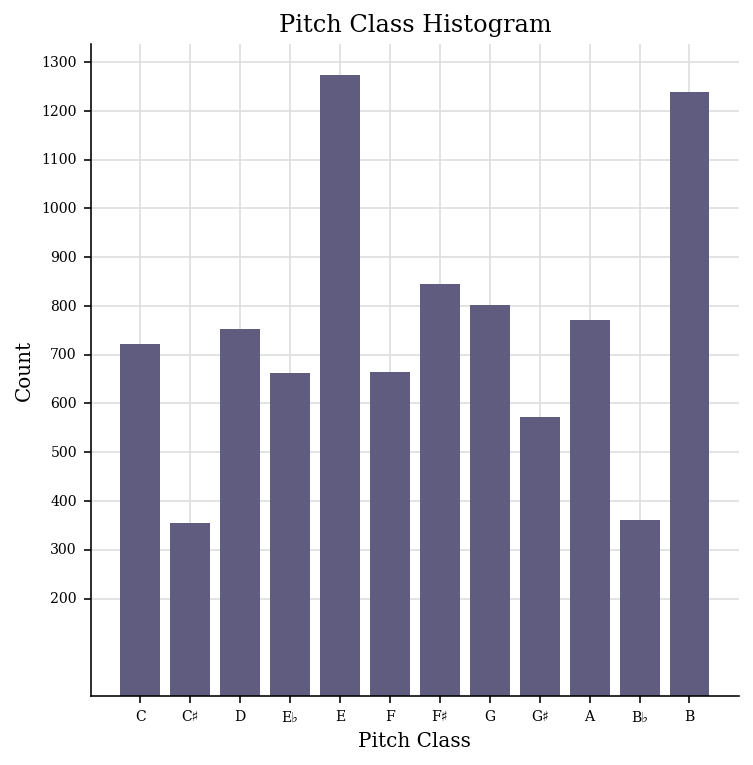

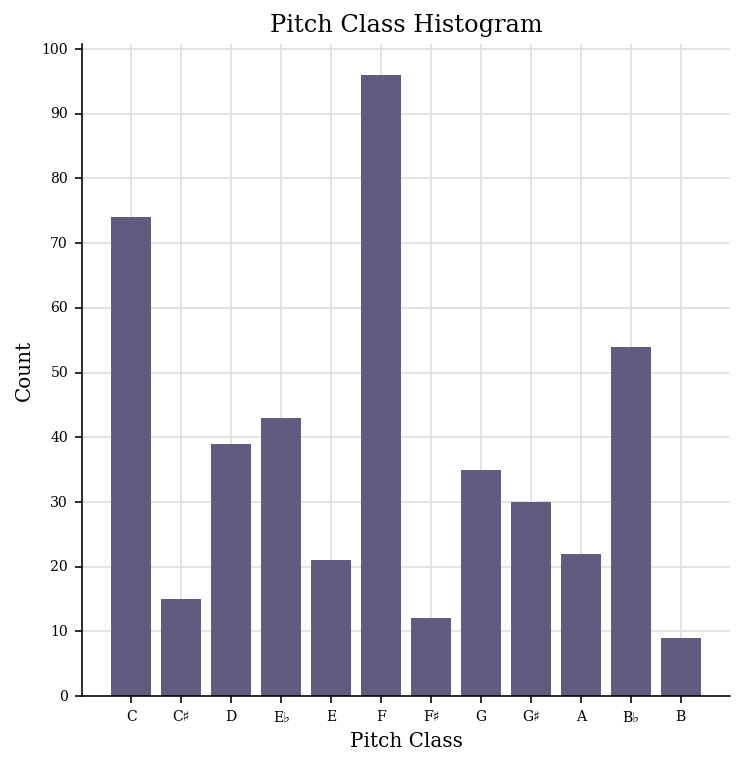

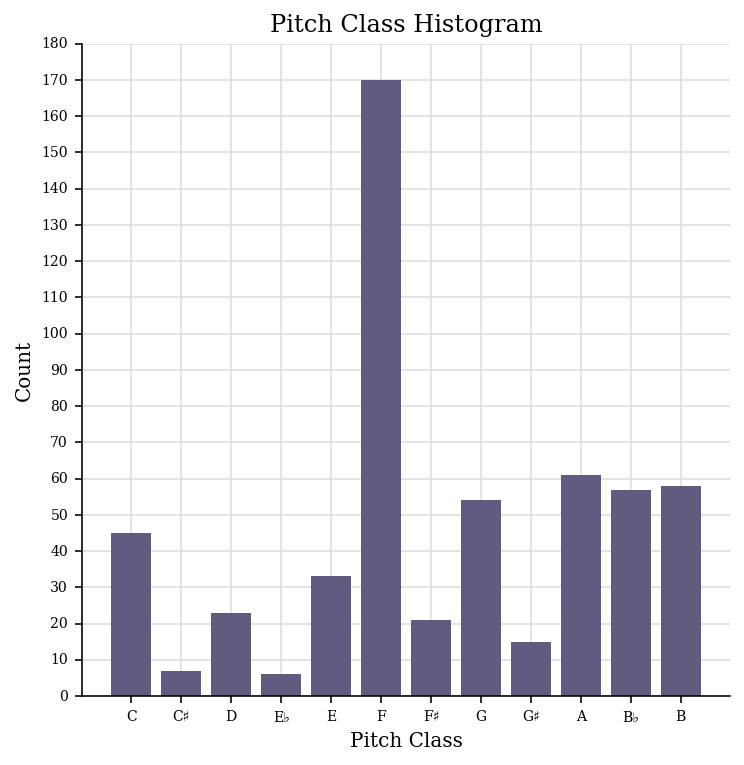

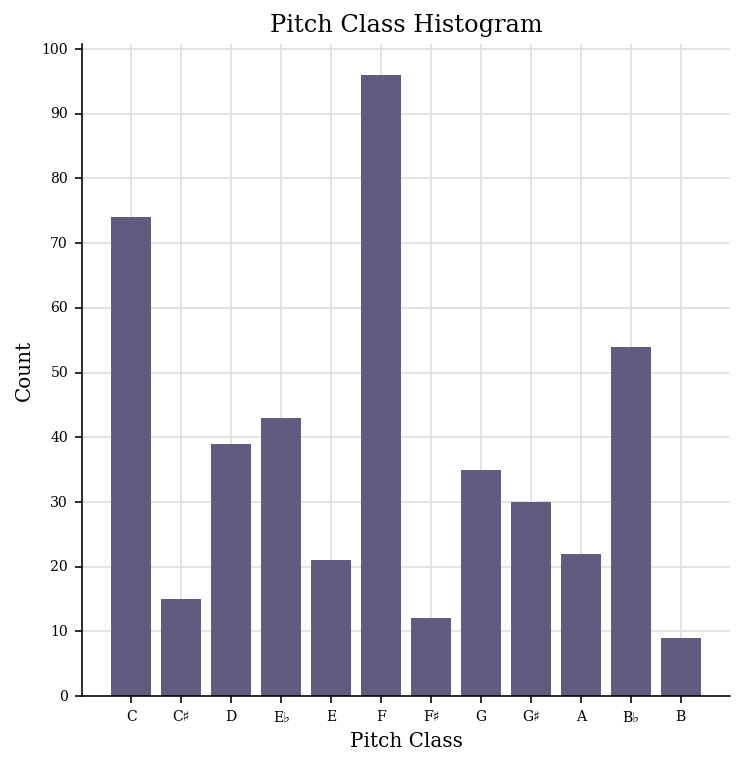

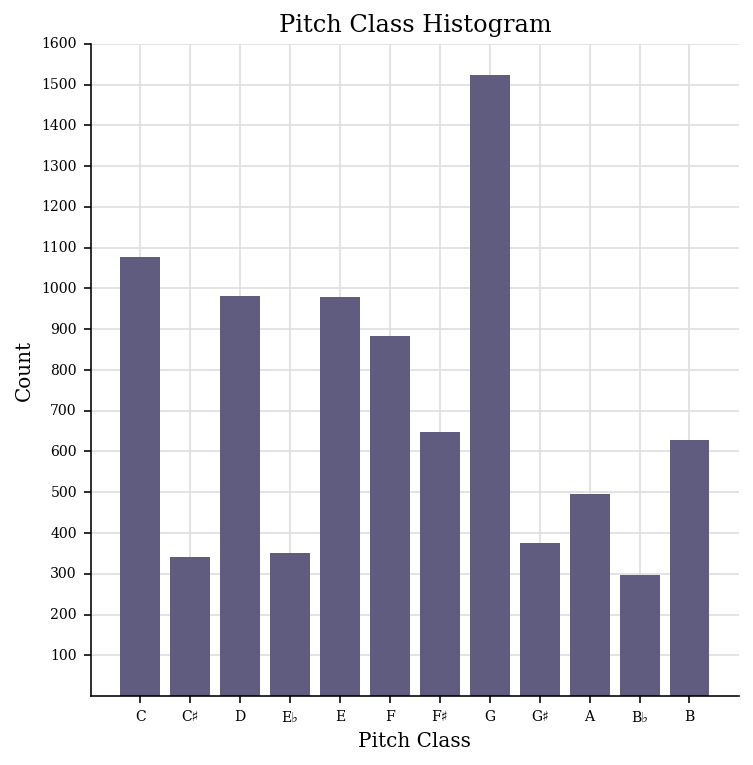

In [3]:
for song in classics:
    LSTMSongs[0].plot('histogram', 'pitchClass', 'count')
    song.plot('histogram', 'pitchClass', 'count')

Destes gráficos, selecionei alguns cujo comportamento se assemelha ao gerado pelo modelo LSTM 

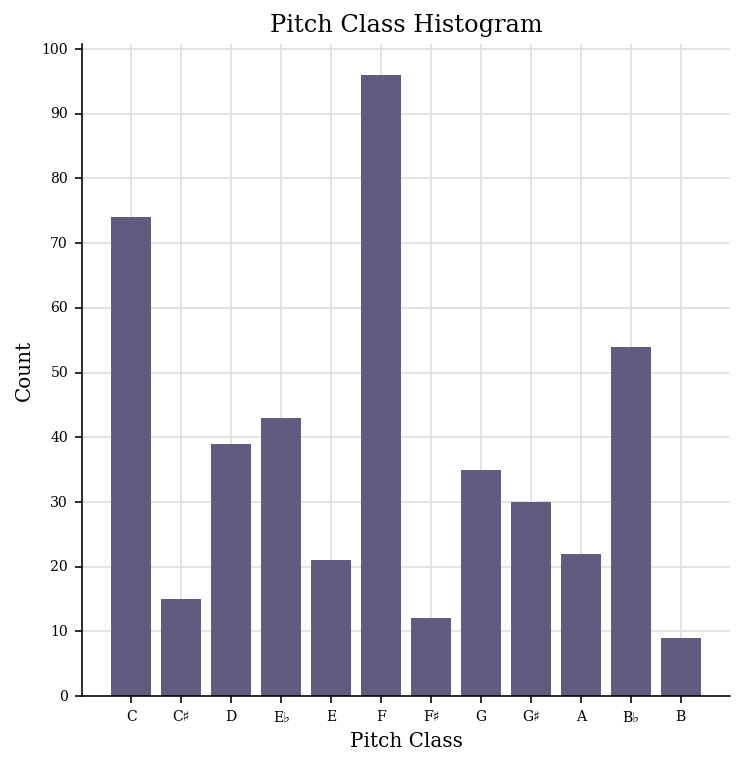

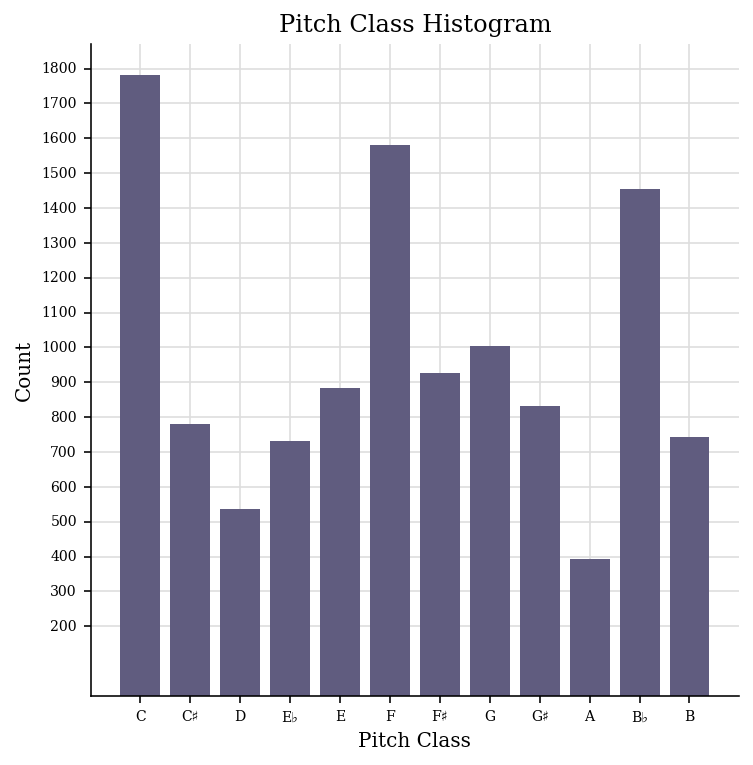

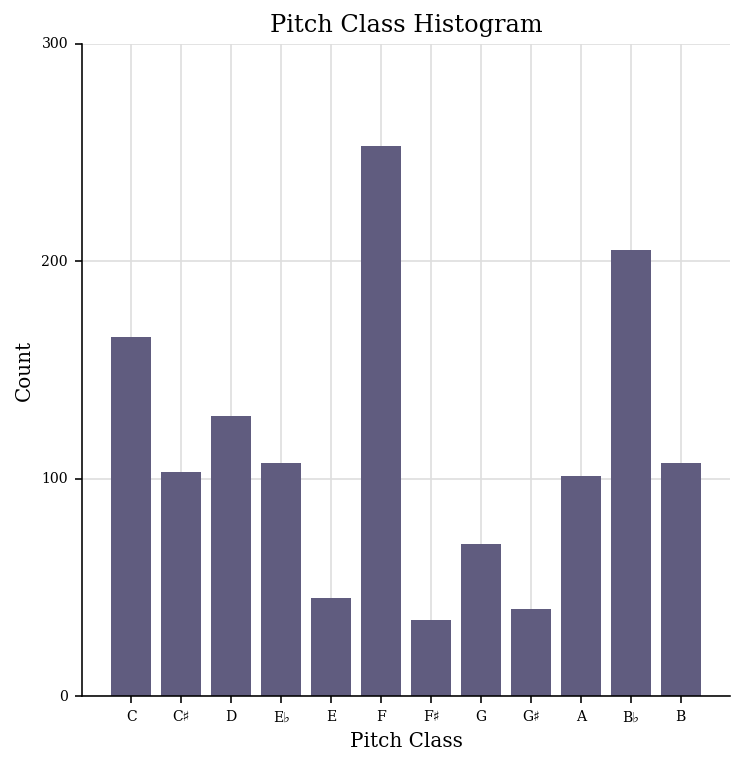

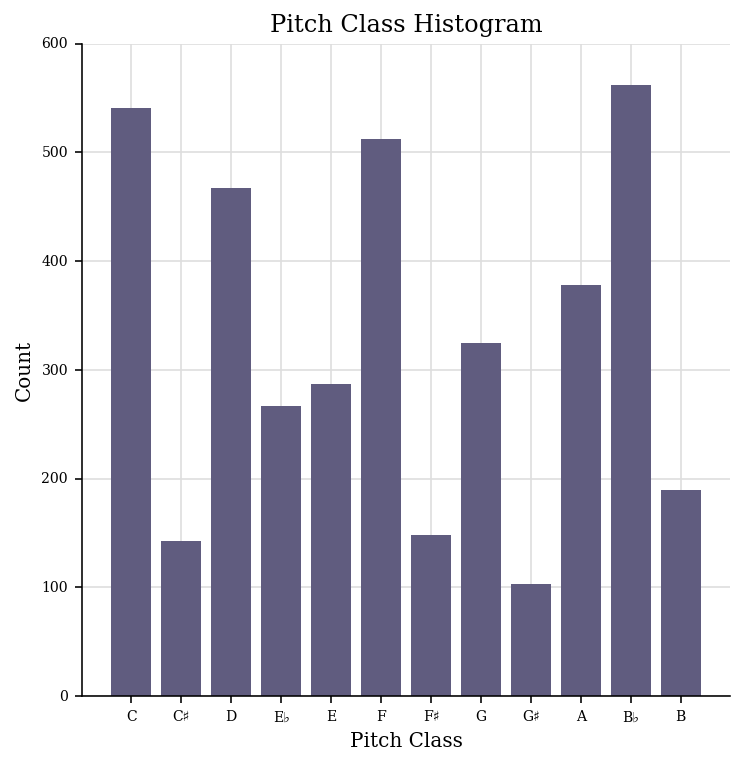

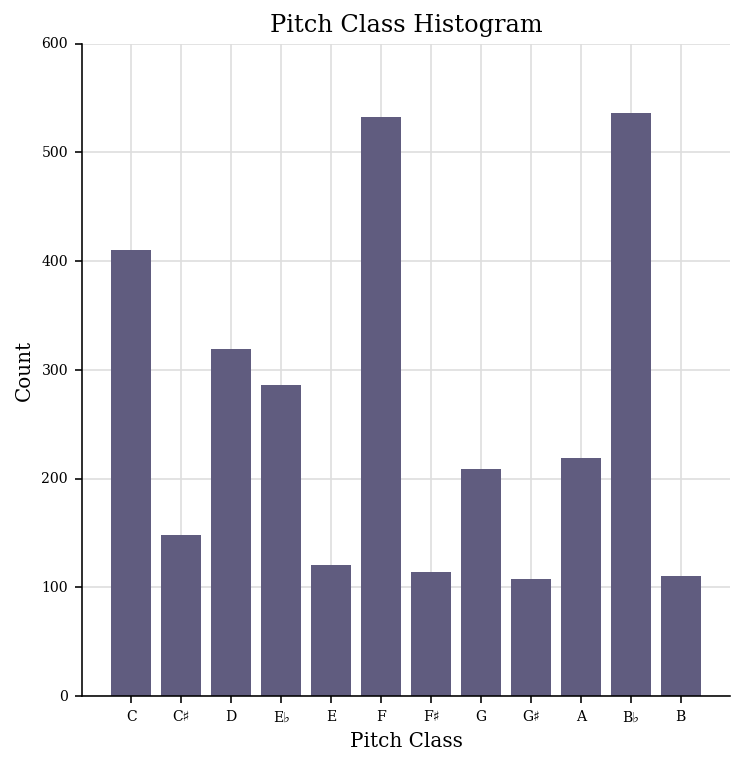

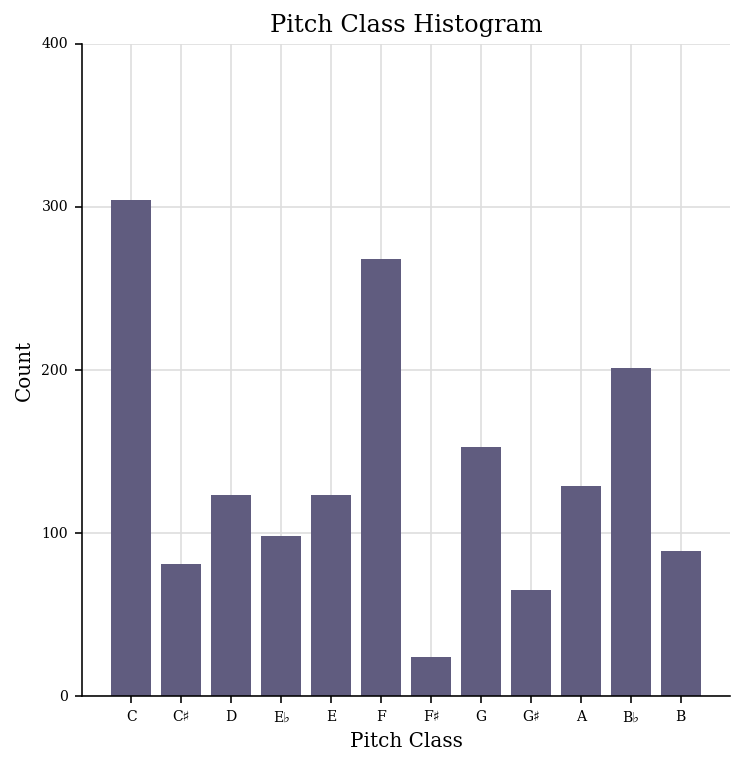

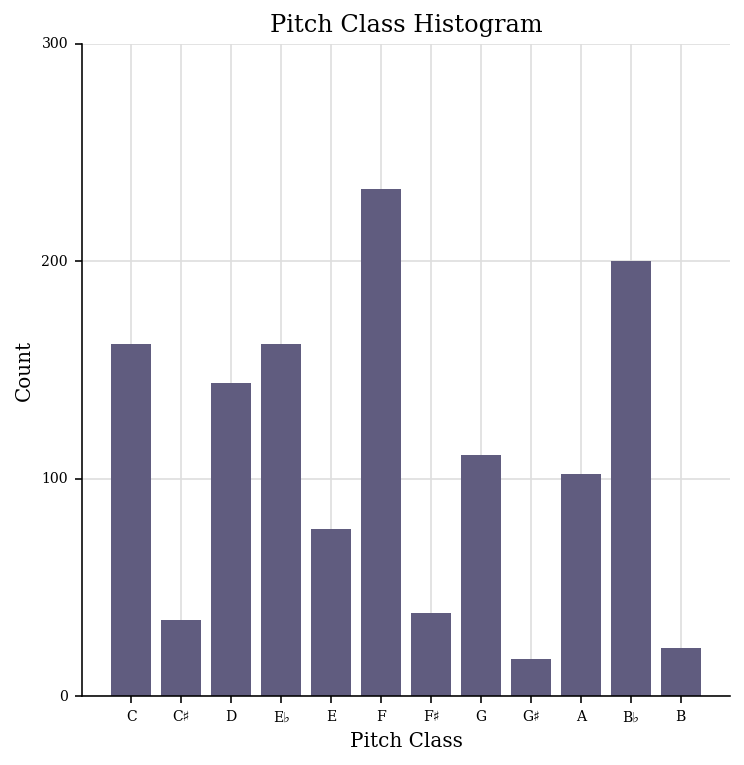

In [4]:
LSTMSongs[0].plot('histogram', 'pitchClass', 'count')
classics[2].plot('histogram', 'pitchClass', 'count')
classics[4].plot('histogram', 'pitchClass', 'count')
classics[13].plot('histogram', 'pitchClass', 'count')
classics[16].plot('histogram', 'pitchClass', 'count')
classics[27].plot('histogram', 'pitchClass', 'count')
classics[33].plot('histogram', 'pitchClass', 'count')

Usar essa mesma métrica para as música geradas pelo modelo RBM infelizmente não é tão facilmente visualizada uma vez que a variedade de Pitch geradas é significativamente menor

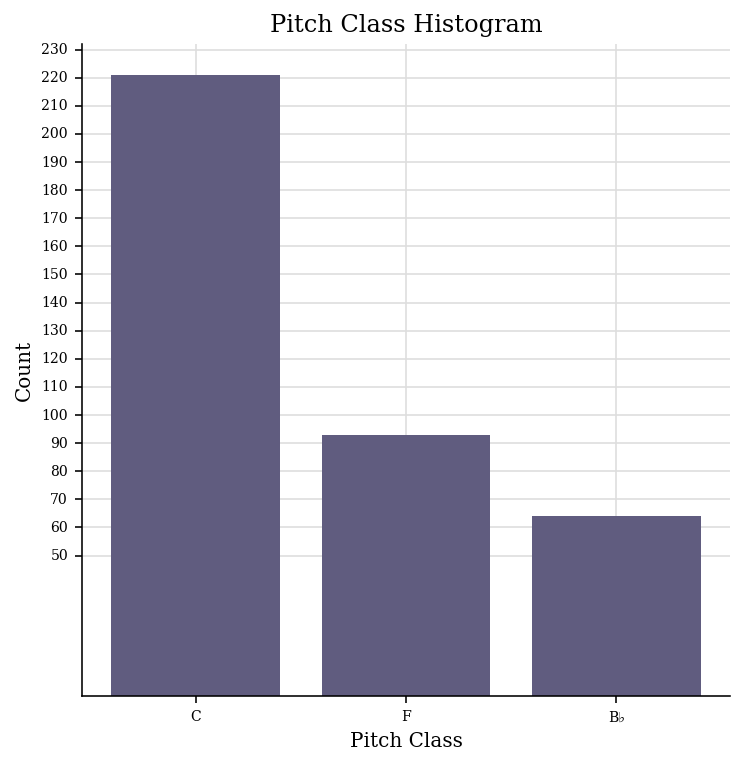

In [5]:
RBMSongs[0].plot('histogram', 'pitchClass', 'count')

Como podemos ver, são usados principalmente três pitchs. O RBM acabou ficando com uma diversidade pequena pois muitas vezes eram usados acordes (combinações de notas) que eram unicos ou escassos, já notas individuais eram bem mais significativas, mesmo tentando dar overfit no modelo, ele não foi capaz de aprender muitas notas.

------
Agrupando todas composições de cada tipo, podemos notar que algumas tendencias, especialmente nas notas de menor valor, seguem nos três modelos (apesar de que no RBM a maioria das notas não se encontram presentes)

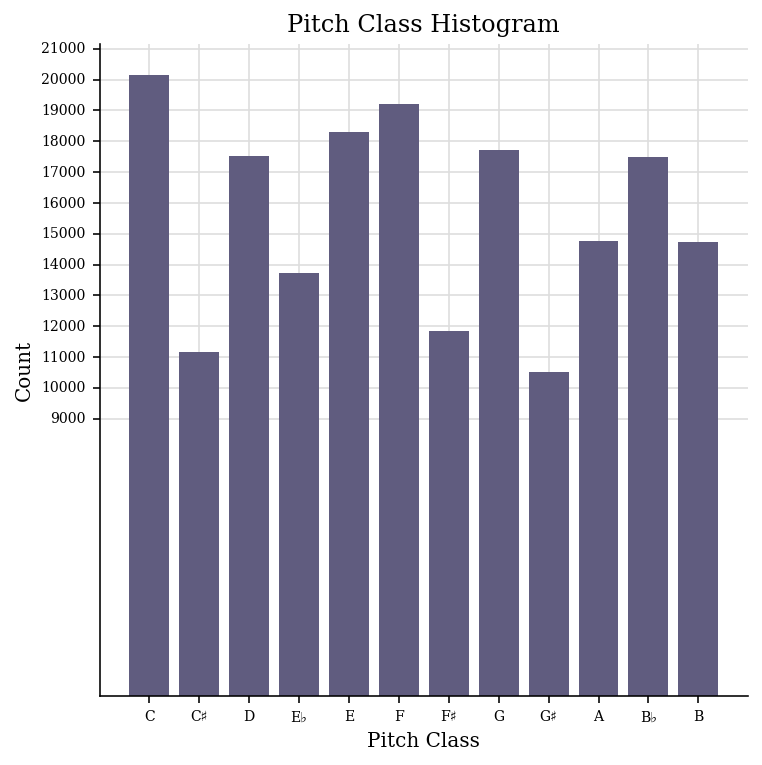

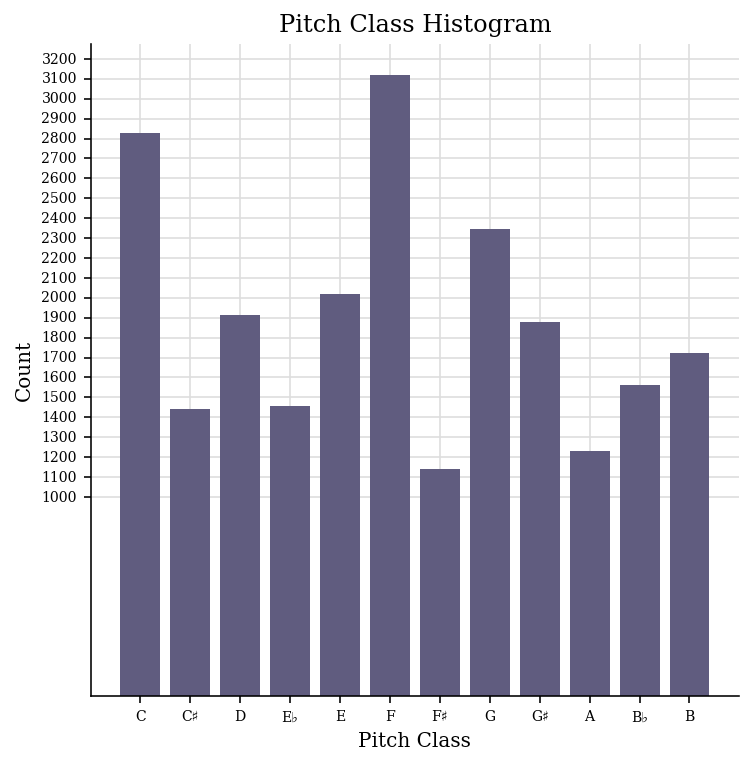

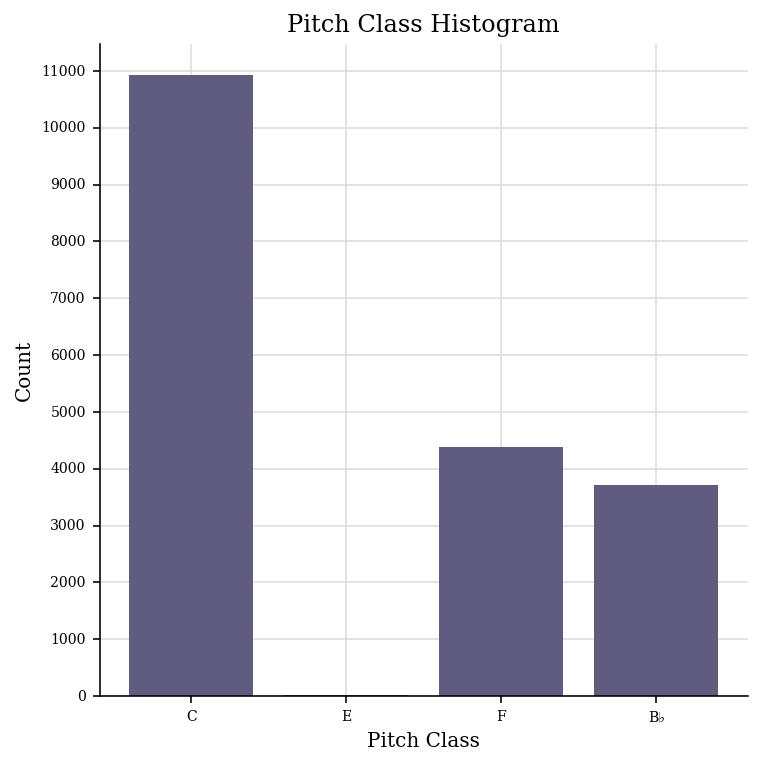

In [6]:
ALLclassics = classics[0]
for song in classics[1:len(classics)]:
    ALLclassics += song
    
ALLLSTM = LSTMSongs[0]
for song in LSTMSongs[1:len(LSTMSongs)]:
    ALLLSTM += song
    
ALLRBM = RBMSongs[0]
for song in RBMSongs[1:len(RBMSongs)]:
    ALLRBM += song
    
ALLclassics.plot('histogram', 'pitchClass', 'count')
ALLLSTM.plot('histogram', 'pitchClass', 'count')
ALLRBM.plot('histogram', 'pitchClass', 'count')

____________________________________

### Comparando usando Pitch class transition matrix (PCTM)

Usando essa métrica, podemos buscar qual é a música gerada por LSTM e RBM que mais se assemelham ao dataset original. Essa métrica consiste em mapear as transições de Pitch gerando uma matrix 12 X 12.

In [7]:
def getPitchNum(note):
    num = []
    if '.' in note: 
        for n in note.split('.'):
            if n.isdigit():
                num.append(int(n))
    else:
        if note.isdigit():
            num.append(int(note))
        else:
            num.append(pitch.Pitch(note).pitchClass)
    return num

# PCTM means Pitch class transition matrix
def getPCTM(song):
    count = 0
    matrix = np.zeros((12,12))
    notes = getNotes(song)
    for i in range(0, len(notes)-1):
        j = i + 1
        currentNote = getPitchNum(notes[i])
        nextNote = getPitchNum(notes[j])
        for currentval in currentNote:
            for nextVal in nextNote:
                matrix[currentval][nextVal] += 1
                count += 1
    return matrix/count

def printMatrix(matrix):
    for row in matrix:
        print(' '.join("{:.2f}".format(k) for k in row))

In [8]:
LSTMMatrix = getPCTM(LSTMSongs[0])
ClassicMatrix = getPCTM(classics[0])
RBMMatrix = getPCTM(RBMSongs[0])

diffLSTMMatrix = abs(LSTMMatrix - ClassicMatrix)
diffRBMMatrix = abs(RBMMatrix - ClassicMatrix)

ClassicLSTMIndex = 0
LSTMIndex = 0
ClassicRBMIndex = 0
RBMIndex = 0

menorLSTMDiff = sum(sum(diffLSTMMatrix))
menorRBMDiff = sum(sum(diffRBMMatrix))
LSTMSimilar = LSTMSongs[0]
ClassicLSTMSimilar = classics[0]
RBMSimilar = RBMSongs[0]
ClassicRBMSimilar = classics[0]
for i in range(0,len(LSTMSongs)):
    for j in range(0,len(classics)):
        LSTMMatrix = getPCTM(LSTMSongs[i])
        ClassicMatrix = getPCTM(classics[j])
        RBMMatrix = getPCTM(RBMSongs[i])
        
        diffLSTMMatrix = abs(LSTMMatrix - ClassicMatrix)
        diffRBMMatrix = abs(RBMMatrix - ClassicMatrix)
        
        valDiff = sum(sum(diffLSTMMatrix))
        if(valDiff < menorLSTMDiff):
            menorLSTMDiff = valDiff
            LSTMSimilar = LSTMSongs[i]
            ClassicLSTMSimilar = classics[j]
            ClassicLSTMIndex = j
            LSTMIndex = i
            
        valDiff = sum(sum(diffRBMMatrix))
        if(valDiff < menorRBMDiff):
            menorRBMDiff = valDiff
            RBMSimilar = RBMSongs[i]
            ClassicRBMSimilar = classics[j]
            ClassicRBMIndex = j
            RBMIndex = i

LSTM Matrix
0.00 0.00 0.00 0.00 0.01 0.01 0.00 0.00 0.01 0.01 0.00 0.00
0.00 0.02 0.01 0.01 0.03 0.00 0.00 0.01 0.01 0.02 0.00 0.02
0.01 0.01 0.02 0.00 0.01 0.00 0.00 0.01 0.00 0.02 0.00 0.01
0.00 0.01 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.00
0.01 0.03 0.01 0.01 0.03 0.00 0.01 0.01 0.00 0.02 0.00 0.04
0.01 0.00 0.01 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.01 0.00 0.00 0.01 0.00 0.01 0.01 0.00 0.02 0.00 0.01
0.00 0.00 0.01 0.00 0.01 0.00 0.00 0.02 0.00 0.01 0.00 0.01
0.00 0.01 0.00 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.01
0.01 0.01 0.01 0.00 0.02 0.00 0.02 0.01 0.00 0.02 0.01 0.02
0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.02 0.02 0.00 0.03 0.00 0.01 0.01 0.01 0.02 0.00 0.01
Classic Matrix
0.01 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.02 0.01 0.00 0.03 0.00 0.01 0.00 0.01 0.01 0.00 0.02
0.00 0.02 0.01 0.00 0.01 0.00 0.01 0.01 0.01 0.01 0.00 0.02
0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.00 0.02 0.0

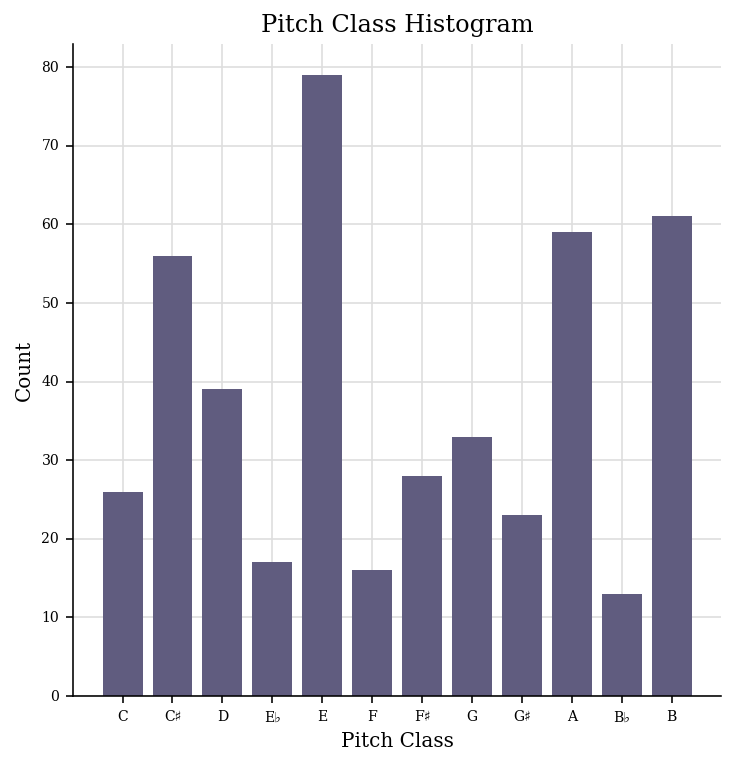

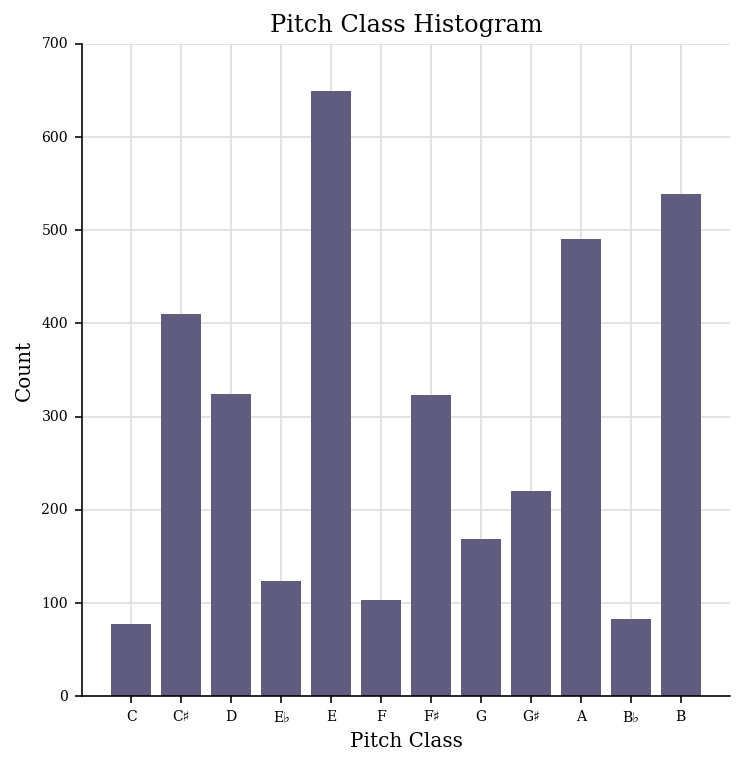

In [9]:
LSTMMatrix = getPCTM(LSTMSimilar)
ClassicLSTMMatrix = getPCTM(ClassicLSTMSimilar)

print("LSTM Matrix")
printMatrix(LSTMMatrix)
print("Classic Matrix")
printMatrix(ClassicLSTMMatrix)
LSTMSimilar.plot('histogram', 'pitchClass', 'count')
ClassicLSTMSimilar.plot('histogram', 'pitchClass', 'count')

RBM Matrix
0.39 0.00 0.00 0.00 0.00 0.12 0.00 0.00 0.00 0.00 0.04 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.12 0.00 0.00 0.00 0.00 0.22 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.04 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.07 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Classic Matrix
0.02 0.00 0.00 0.00 0.01 0.01 0.00 0.01 0.01 0.01 0.01 0.01
0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.00 0.00 0.01 0.00 0.01 0.02 0.00 0.00 0.00 0.00 0.00 0.01
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00

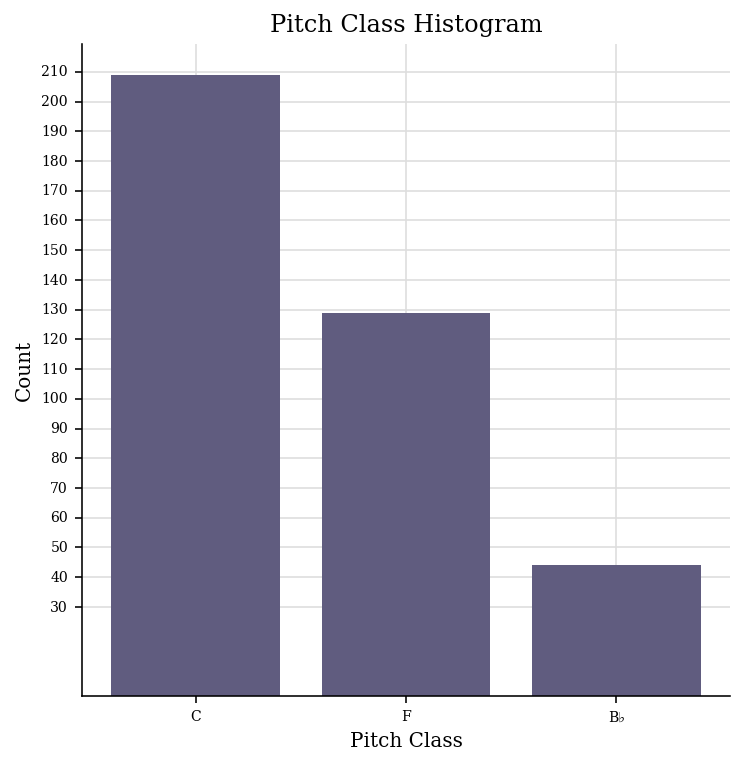

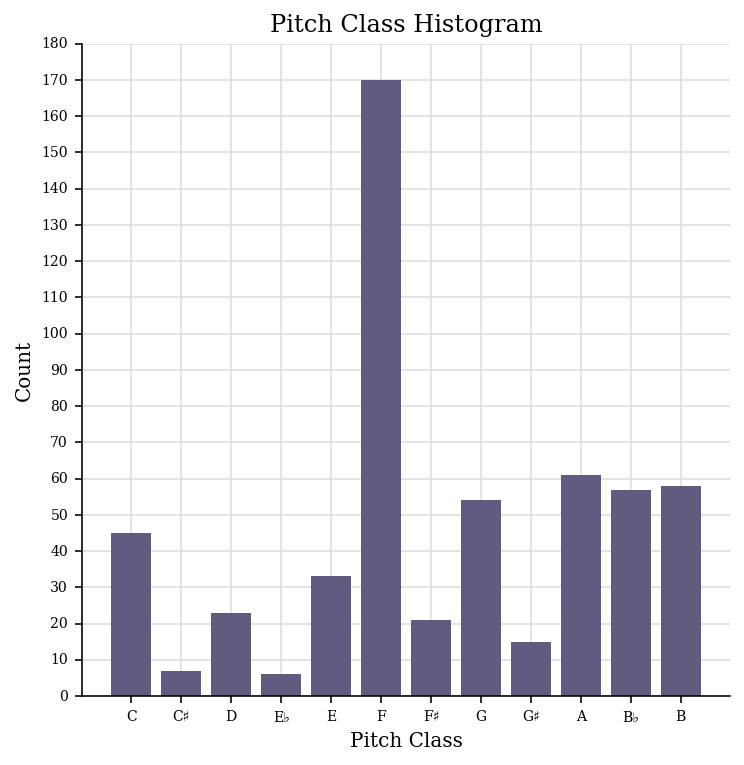

In [10]:
RBMMatrix = getPCTM(RBMSimilar)
ClassicRBMMatrix = getPCTM(ClassicRBMSimilar)

print("RBM Matrix")
printMatrix(RBMMatrix)
print("Classic Matrix")
printMatrix(ClassicRBMMatrix)
RBMSimilar.plot('histogram', 'pitchClass', 'count')
ClassicRBMSimilar.plot('histogram', 'pitchClass', 'count')

Podemos verificar que a similaridade dos histogramas não indica necessariamente similaridade entre as composições, usando PCTMs ganhamos mais uma dimenção para representar particularidades da música. Porém, da forma como está, é dificil perceber qualquer semelhança. Para solucionar esse problema podemos visualizar essa matriz com um heatmap

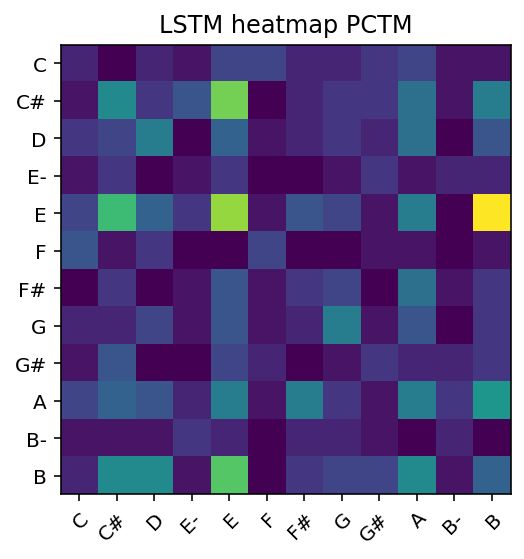

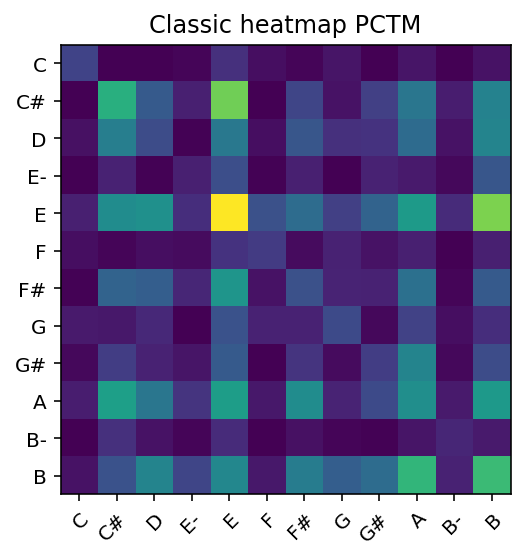

In [11]:
PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(LSTMMatrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))
# ... and label them with the respective list entries
ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("LSTM heatmap PCTM")
fig.tight_layout()
plt.show()

PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(ClassicLSTMMatrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))
# ... and label them with the respective list entries
ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Classic heatmap PCTM")
fig.tight_layout()
plt.show()

Podemos notar comportamentos bem similares nos heatmaps, como por exemplo a transição de E para E é bem iluminada em ambas as músicas

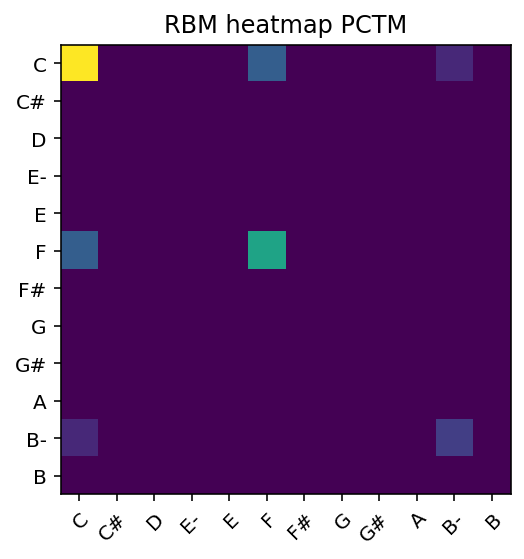

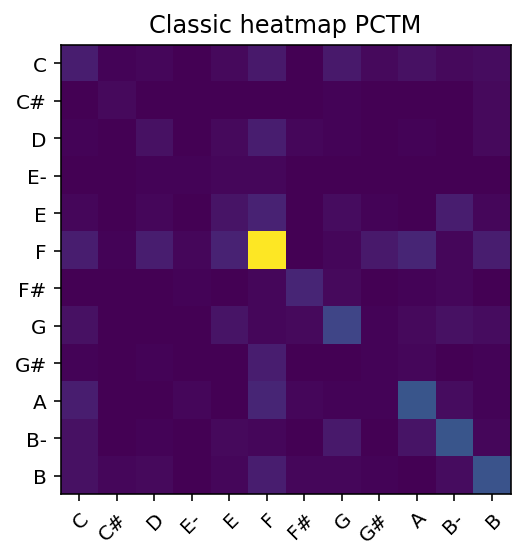

In [12]:
PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(RBMMatrix)

ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))

ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("RBM heatmap PCTM")
fig.tight_layout()
plt.show()

PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(ClassicRBMMatrix)

ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))

ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Classic heatmap PCTM")
fig.tight_layout()
plt.show()

Devido a pouca diversidade de notas nas músicas geradas pela RBM, fica mais facil de visualizar as semelhanças, podemos notar que essa composição do dataset por sua vez é bem repetitiva.

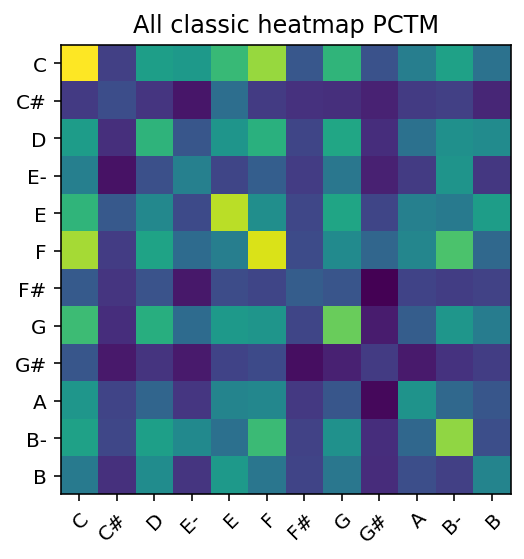

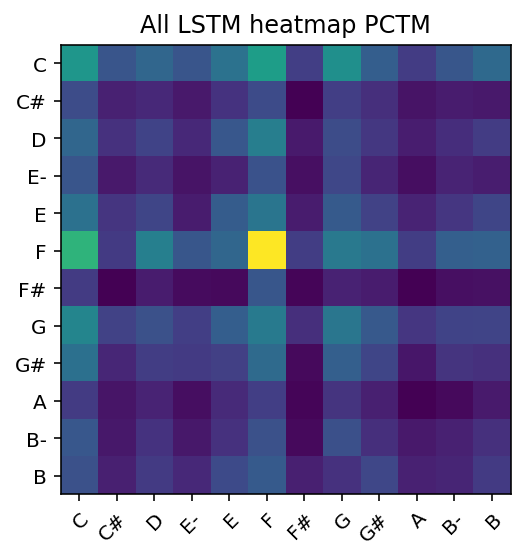

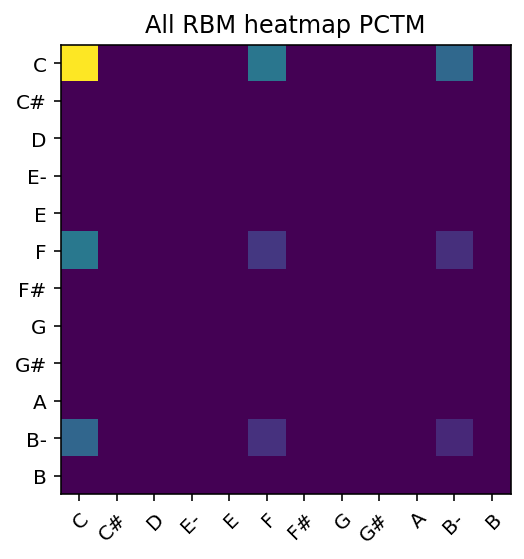

In [13]:
ALLClassicMatrix = getPCTM(ALLclassics)
ALLLSTMMatrix = getPCTM(ALLLSTM)
ALLRBMMatrix = getPCTM(ALLRBM)
###########################################################################
PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(ALLClassicMatrix)

ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))

ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("All classic heatmap PCTM")
fig.tight_layout()
plt.show()
###########################################################################
PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(ALLLSTMMatrix)

ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))

ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("All LSTM heatmap PCTM")
fig.tight_layout()
plt.show()
###########################################################################
PitchXY = [pitch.Pitch(0), pitch.Pitch(1), pitch.Pitch(2), pitch.Pitch(3),
          pitch.Pitch(4), pitch.Pitch(5), pitch.Pitch(6), pitch.Pitch(7),
          pitch.Pitch(8), pitch.Pitch(9), pitch.Pitch(10), pitch.Pitch(11)]

fig, ax = plt.subplots()
im = ax.imshow(ALLRBMMatrix)

ax.set_xticks(np.arange(len(PitchXY)))
ax.set_yticks(np.arange(len(PitchXY)))

ax.set_xticklabels(PitchXY)
ax.set_yticklabels(PitchXY)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("All RBM heatmap PCTM")
fig.tight_layout()
plt.show()

In [17]:


print(ClassicRBMIndex)
print(RBMIndex)

48
30
